# Adaptive and Gradient Boosting

In this notebook, we demonstrate the use of AdaBoost and gradient boosting, incuding several state-of-the-art implementations of this very powerful and flexible algorithm that greatly speed up training. 

We use the stock return dataset with a few engineered factors created in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature_engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb).

## Update

This notebook now uses `sklearn.ensemble.HistGradientBoostingClassifier`.

## Imports and Settings

In [41]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time

In [3]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [4]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

## Prepare Data

### Get source

We use the `engineered_features` dataset created in [Chapter 4, Alpha Factor Research](../04_alpha_factor_research)

Set data store location:

In [5]:
DATA_STORE = '../data/assets.h5'

In [6]:
def get_data(start='2000', end='2018', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()
        
    y = (df[target]>0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

### Factorize Categories

Define columns with categorical data:

In [7]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']

Integer-encode categorical columns:

In [8]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1).astype(int)
    return df

### One-Hot Encoding

Create dummy variables from categorical columns if needed:

In [9]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

### Get Holdout Set

Create holdout test set to estimate generalization error after cross-validation:

In [10]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

The algorithms in this chapter use a dataset generated in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature-engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb) that needs to be executed first.

In [11]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

In [12]:
X_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      358914 non-null  float64
 1   return_2m      358914 non-null  float64
 2   return_3m      358914 non-null  float64
 3   return_6m      358914 non-null  float64
 4   return_9m      358914 non-null  float64
 5   return_12m     358914 non-null  float64
 6   Mkt-RF         358914 non-null  float64
 7   SMB            358914 non-null  float64
 8   HML            358914 non-null  float64
 9   RMW            358914 non-null  float64
 10  CMA            358914 non-null  float64
 11  momentum_2     358914 non-null  float64
 12  momentum_3     358914 non-null  float64
 13  momentum_6     358914 non-null  float64
 14  momentum_9     358914 non-null  float64
 15  momentum_12    358914 non-null  float64
 16  

In [13]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

## Cross-Validation Setup

### Custom Time Series KFold Generator

Custom Time Series KFold generator.

In [14]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [15]:
cv = OneStepTimeSeriesSplit(n_splits=12, 
                            test_period_length=1, 
                            shuffle=False)

In [16]:
run_time = {}

### CV Metrics

Define some metrics for use with cross-validation:

In [17]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

Helper function that runs cross-validation for the various algorithms.

In [18]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                          X=X,
                          y=y,
                          scoring=list(metrics.keys()),
                          cv=cv,
                          return_train_score=True,
                          n_jobs=n_jobs,
                          verbose=1,
                          fit_params=fit_params)
    duration = time() - start
    return scores, duration

### CV Result Handler Functions

The following helper functions manipulate and plot the cross-validation results to produce the outputs below.

In [19]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [20]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

## Baseline Classifier

`sklearn` provides the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that makes predictions using simple rule and is useful as a simple baseline to compare with the other (real) classifiers we use below.

The `stratified` rule generates predictions based on the training set’s class distribution, i.e. always predicts the most frequent class.

In [21]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=42)

In [22]:
algo = 'dummy_clf'

In [23]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    dummy_cv_result, run_time[algo] = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    3.6s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.8s finished


Unsurprisingly, it produces results near the AUC threshold for arbitrary predictions of 0.5:

In [24]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.503582,0.500008
Accuracy,0.503582,0.500008
F1,0.516424,0.504660
Log Loss,-17.070718,-17.109954
Precision,0.548116,0.504698
Recall,0.505758,0.504622


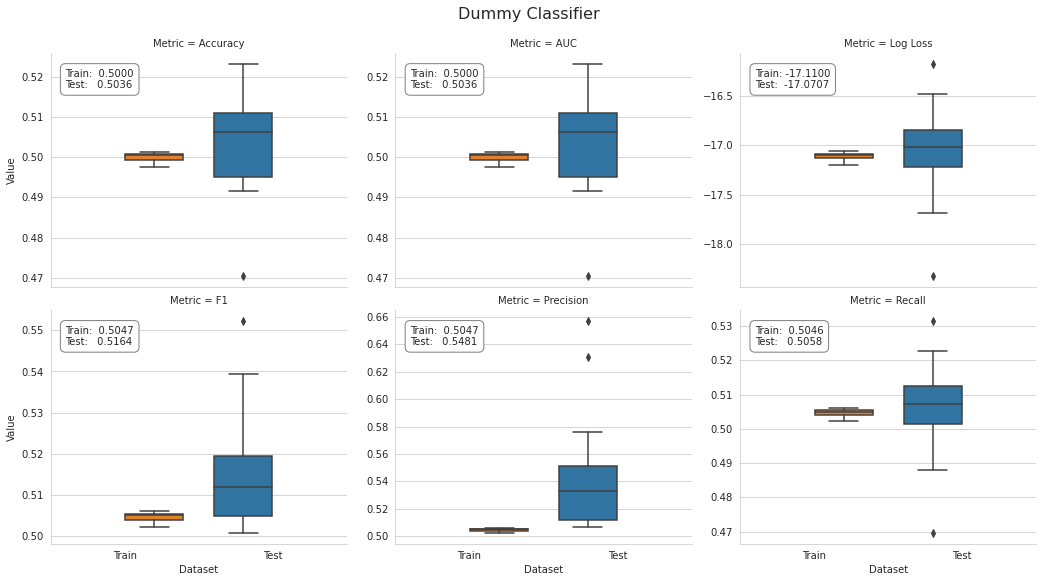

In [25]:
plot_result(dummy_result, model='Dummy Classifier')

## RandomForest

For comparison, we train a `RandomForestClassifier` as presented in [Chapter 11 on Decision Trees and Random Forests](../11_decision_trees_random_forests/02_random_forest.ipynb).

### Configure

In [26]:
rf_clf = RandomForestClassifier(n_estimators=100,
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [27]:
algo = 'random_forest'

In [28]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    rf_cv_result, run_time[algo] = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  8.9min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.9min finished


### Plot Results

In [29]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.527617,1.000000
Accuracy,0.517378,0.999999
F1,0.509683,0.999999
Log Loss,-0.692599,-0.169339
Precision,0.567070,0.999999
Recall,0.544931,0.999999


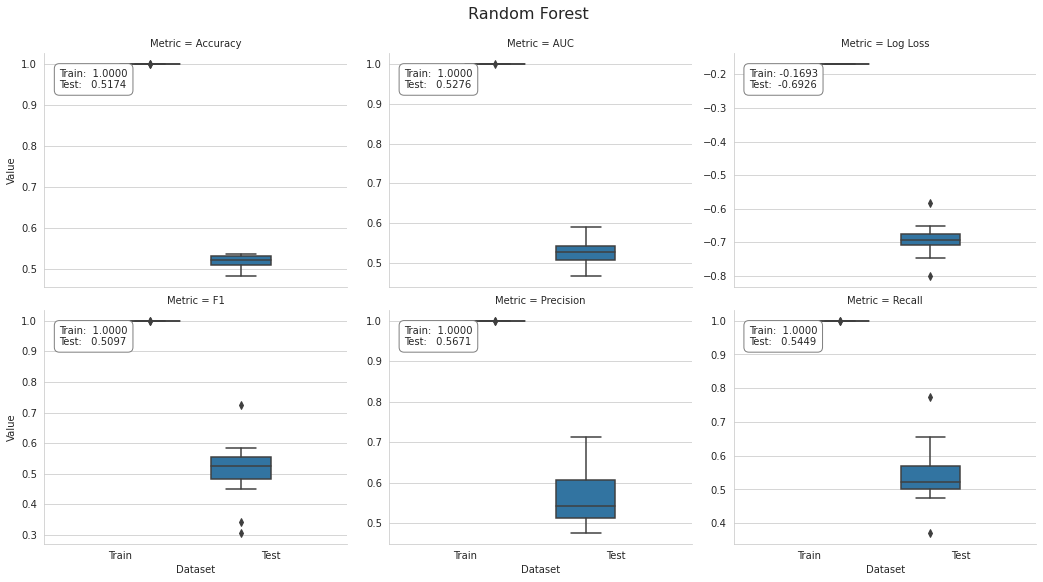

In [30]:
plot_result(rf_result, model='Random Forest')

## scikit-learn: AdaBoost

As part of its [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), sklearn provides an [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation that supports two or more classes. The code examples for this section are in the notebook gbm_baseline that compares the performance of various algorithms with a dummy classifier that always predicts the most frequent class.

### Base Estimator

We need to first define a base_estimator as a template for all ensemble members and then configure the ensemble itself. We'll use the default DecisionTreeClassifier with max_depth=1—that is, a stump with a single split. The complexity of the base_estimator is a key tuning parameter because it depends on the nature of the data. 

As demonstrated in the [previous chapter](../../10_decision_trees_random_forests), changes to `max_depth` should be combined with appropriate regularization constraints using adjustments to, for example, `min_samples_split`:

In [31]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        min_impurity_split=None, 
                                        class_weight=None)

### AdaBoost Configuration

In the second step, we'll design the ensemble. The n_estimators parameter controls the number of weak learners and the learning_rate determines the contribution of each weak learner, as shown in the following code. By default, weak learners are decision tree stumps:

In [32]:
ada_clf = AdaBoostClassifier(base_estimator=base_estimator,
                             n_estimators=100,
                             learning_rate=1.0,
                             algorithm='SAMME.R',
                             random_state=42)

The main tuning parameters that are responsible for good results are `n_estimators` and the base estimator complexity because the depth of the tree controls the extent of the interaction among the features. 

### Cross-validate

We will cross-validate the AdaBoost ensemble using a custom 12-fold rolling time-series split to predict 1 month ahead for the last 12 months in the sample, using all available prior data for training, as shown in the following code:

In [33]:
algo = 'adaboost'

In [34]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    ada_cv_result, run_time[algo] = run_cv(ada_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  6.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.6min finished


### Plot Result

In [35]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.536026,0.608159
Accuracy,0.504680,0.569104
F1,0.462678,0.570845
Log Loss,-0.692850,-0.692697
Precision,0.542952,0.583507
Recall,0.571182,0.588091


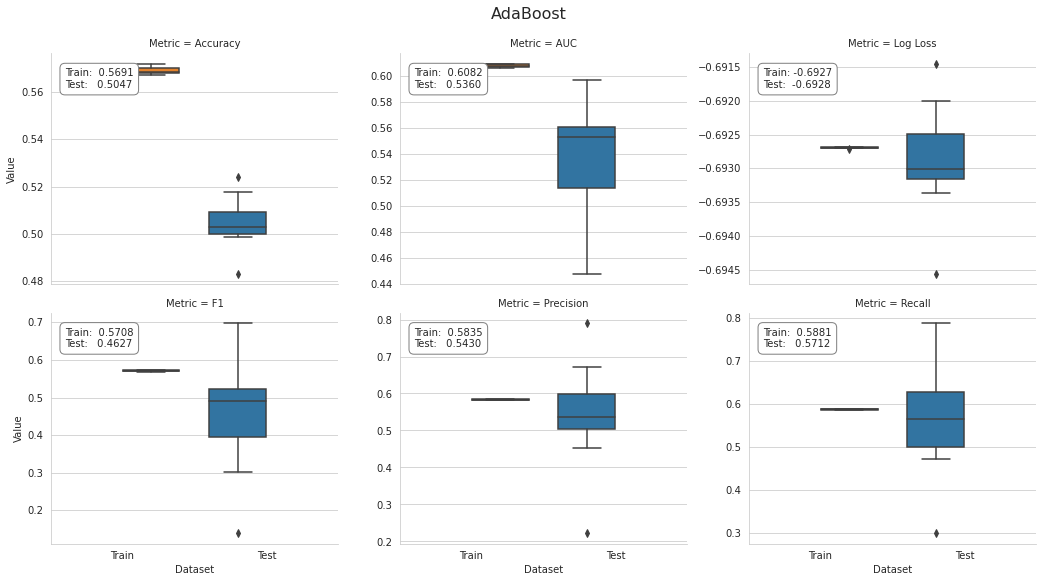

In [36]:
plot_result(ada_result, model='AdaBoost')

## scikit-learn: HistGradientBoostingClassifier

The ensemble module of sklearn contains an implementation of gradient boosting trees for regression and classification, both binary and multiclass. 

### Configure

The following [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) initialization code illustrates the key tuning parameters that we previously introduced, in addition to those that we are familiar with from looking at standalone decision tree models.

This estimator is much faster than [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) for big datasets (n_samples >= 10 000).

This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.

In [52]:
gb_clf = HistGradientBoostingClassifier(loss='binary_crossentropy',              
                                        learning_rate=0.1,          # regulates the contribution of each tree
                                        max_iter=100,               # number of boosting stages
                                        min_samples_leaf=20,
                                        max_depth=None,
                                        random_state=None,
                                        max_leaf_nodes=31,           # opt value depends on feature interaction
                                        warm_start=False,
#                                         early_stopping=True,
#                                         scoring='loss',
#                                         validation_fraction=0.1,
#                                         n_iter_no_change=None,
                                        verbose=0,
                                        tol=0.0001)

### Cross-validate

In [53]:
algo = 'sklearn_gbm'

In [54]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    gb_cv_result, run_time[algo] = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   54.4s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   54.5s finished


### Plot Results

In [56]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.536793,0.749371
Accuracy,0.505439,0.675401
F1,0.454815,0.681579
Log Loss,-0.696830,-0.595520
Precision,0.564898,0.693065
Recall,0.555223,0.689508


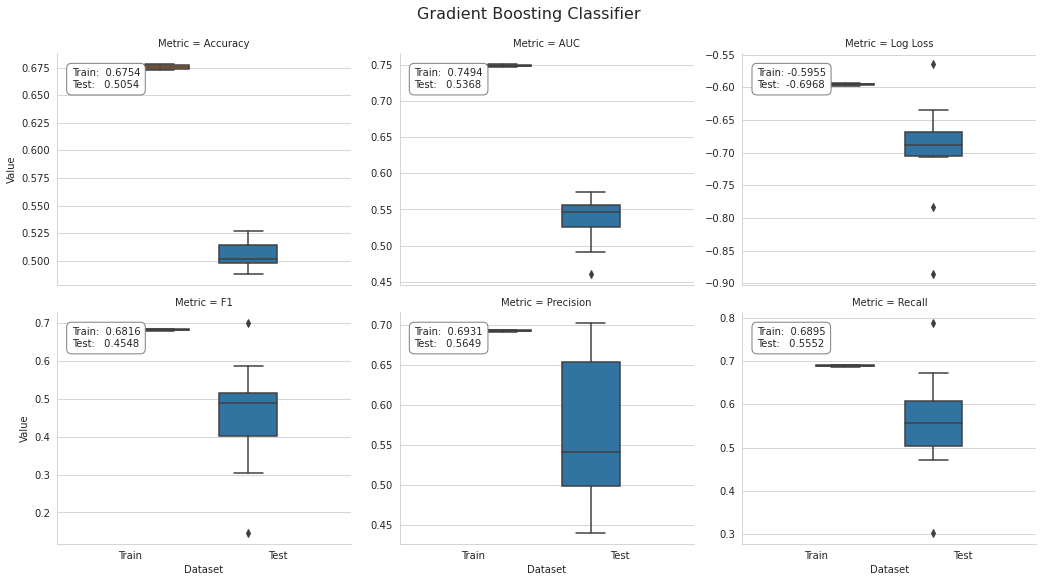

In [57]:
plot_result(gb_result, model='Gradient Boosting Classifier')

### Partial Dependence Plots

Drop time periods to avoid over-reliance for in-sample fit.

In [58]:
X_ = X_factors_clean.drop(['year', 'month'], axis=1)

In [59]:
fname = results_path / f'{algo}_model.joblib'
if not Path(fname).exists():
    gb_clf.fit(y=y_clean, X=X_)
    joblib.dump(gb_clf, fname)
else:
    gb_clf = joblib.load(fname)

In [60]:
# mean accuracy
gb_clf.score(X=X_, y=y_clean)

0.5864625169378761

In [61]:
y_score = gb_clf.predict_proba(X_)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.611720539220663

#### One-way and two-way partial depende plots

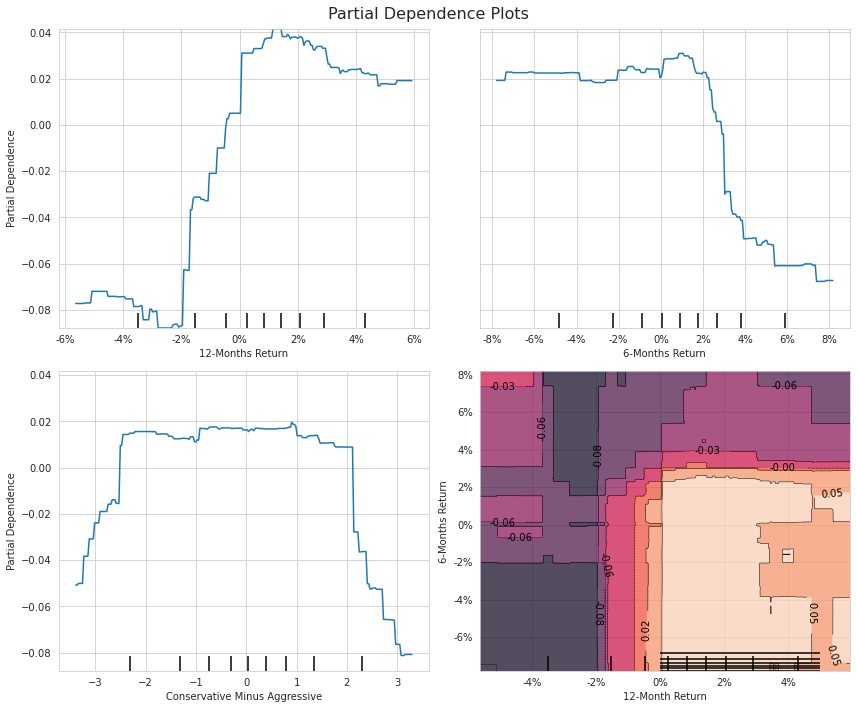

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

plot_partial_dependence(
    estimator=gb_clf,
    X=X_,
    features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
    percentiles=(0.05, 0.95),
    n_jobs=-1,
    n_cols=2,
    response_method='decision_function',
    grid_resolution=250,
    ax=axes)

for i, j in product([0, 1], repeat=2):
    if i!=1 or j!= 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95)
fig.savefig('figures/partial_dep_2d', dpi=300);

#### Two-way partial dependence as 3D plot

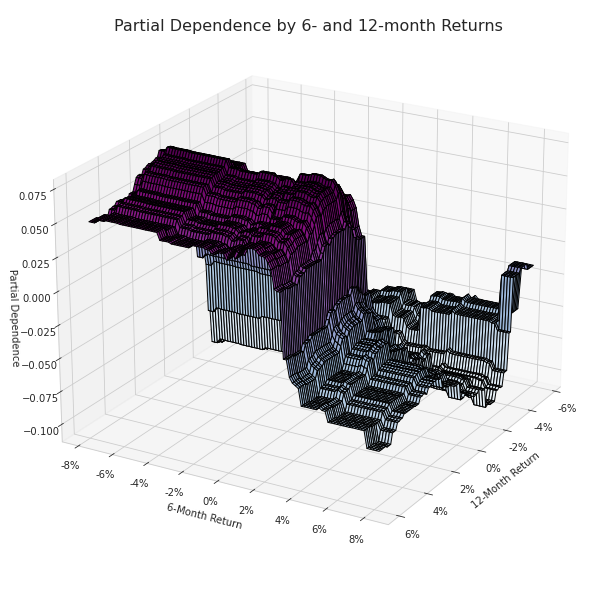

In [65]:
targets = ['return_12m', 'return_6m']
pdp, axes = partial_dependence(estimator=gb_clf,
                               features=targets,
                               X=X_,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z,
                          rstride=1,
                          cstride=1,
                          cmap=plt.cm.BuPu,
                          edgecolor='k')
ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)
fig.tight_layout()
fig.savefig('figures/partial_dep_3d', dpi=300)

## XGBoost

See XGBoost [docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html) for details on parameters and usage.

### Configure

In [66]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [67]:
algo = 'xgboost'

In [68]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  6.4min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.4min finished


### Plot Results

In [69]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.523467,0.685107
Accuracy,0.501340,0.618366
F1,0.392318,0.621540
Log Loss,-0.705452,-0.643732
Precision,0.503652,0.640619
Recall,0.496645,0.637335


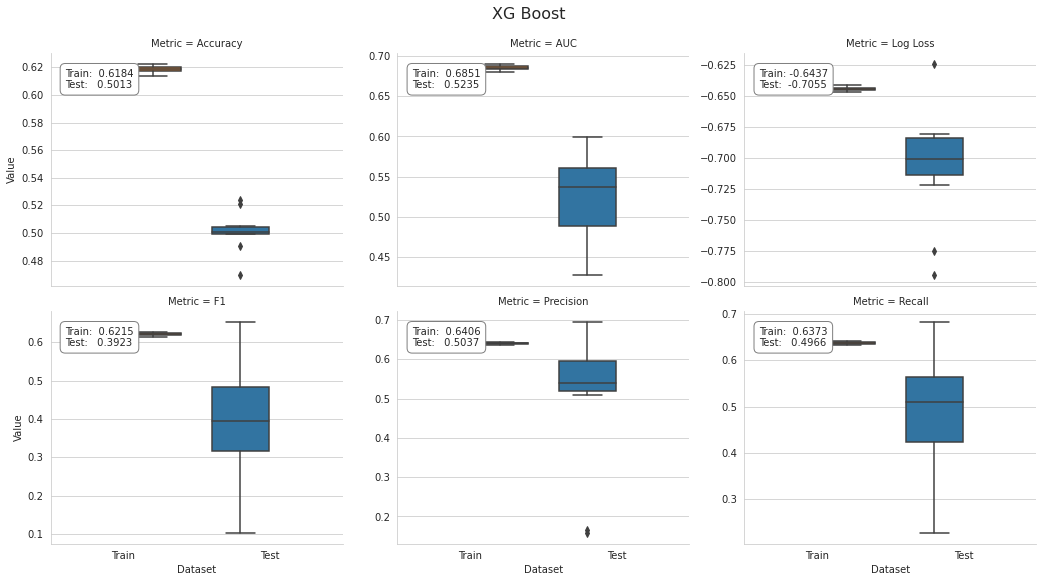

In [70]:
plot_result(xbg_result, model='XG Boost', fname=f'figures/{algo}_cv_result')

### Feature Importance

In [71]:
xgb_clf.fit(X=X_dummies, y=y)

[19:16:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:16:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [72]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X_dummies.columns)

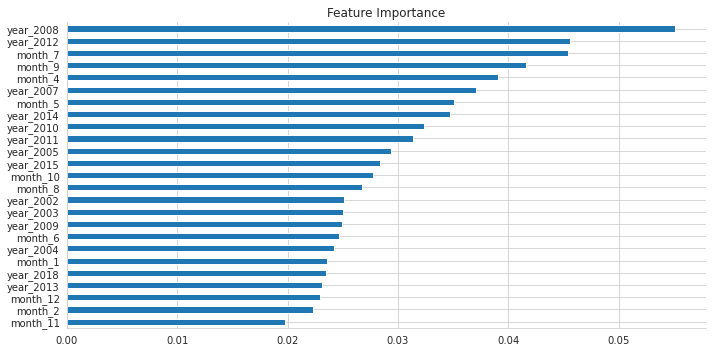

In [73]:
fi.nlargest(25).sort_values().plot.barh(figsize=(10, 5), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();

## LightGBM

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for details on parameters and usage.

### Configure

In [74]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
#                          device='gpu',
                         objective='binary',          # learning task
                         metric='auc',
                         num_leaves=31,               # Maximum tree leaves for base learners.
                         max_depth=-1,                # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,          # Adaptive lr via callback override in .fit() method  
                         n_estimators=100,            # Number of boosted trees to fit
                         subsample_for_bin=200000,    # Number of samples for constructing bins.
                         class_weight=None,           # dict, 'balanced' or None
                         min_split_gain=0.0,          # Minimum loss reduction for further split
                         min_child_weight=0.001,      # Minimum sum of instance weight(hessian)
                         min_child_samples=20,        # Minimum number of data need in a child(leaf)
                         subsample=1.0,               # Subsample ratio of training samples
                         subsample_freq=0,            # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,        # Subsampling ratio of features
                         reg_alpha=0.0,               # L1 regularization term on weights
                         reg_lambda=0.0,              # L2 regularization term on weights
                         random_state=42,             # Random number seed; default: C++ seed
                         n_jobs=-1,                   # Number of parallel threads.
                         silent=False,
                         importance_type='gain',      # default: 'split' or 'gain'
                        )

### Cross-Validate

#### Using categorical features

In [75]:
algo = 'lgb_factors'

In [76]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result, run_time[algo] = run_cv(lgb_clf, X=X_factors, fit_params={'categorical_feature': cat_cols})
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   57.0s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   57.2s finished


##### Plot Results

In [77]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.531961,0.750078
Accuracy,0.507112,0.676947
F1,0.423222,0.683303
Log Loss,-0.723949,-0.592515
Precision,0.555119,0.691271
Recall,0.505033,0.689602


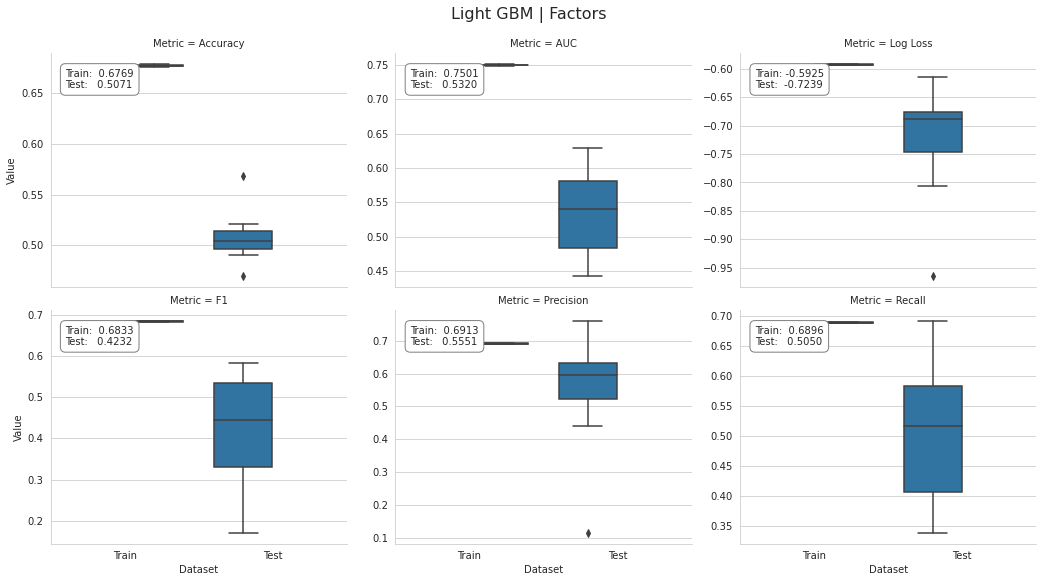

In [78]:
plot_result(lgb_factor_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

#### Using dummy variables

In [79]:
algo = 'lgb_dummies'

In [80]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result, run_time[algo] = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   49.3s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   49.5s finished


##### Plot results

In [81]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.531726,0.743801
Accuracy,0.512568,0.670181
F1,0.432572,0.676278
Log Loss,-0.704388,-0.600524
Precision,0.563982,0.688815
Recall,0.503945,0.684960


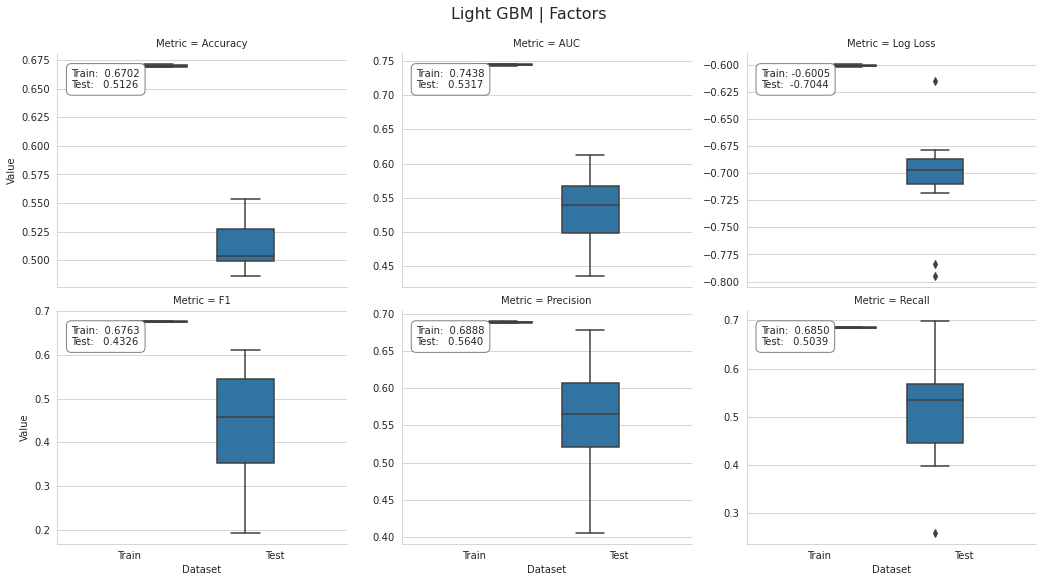

In [82]:
plot_result(lgb_dummy_result, model='Light GBM | Factors', fname=f'figures/{algo}_cv_result')

## Catboost

See CatBoost [docs](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) for details on parameters and usage.

### CPU

#### Configure

In [83]:
cat_clf = CatBoostClassifier()

#### Cross-Validate

In [84]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

Catboost requires integer values for categorical variables.

In [85]:
algo = 'catboost'

In [86]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    cat_cv_result, run_time[algo] = run_cv(cat_clf,
                                           X=X_factors,
                                           fit_params={
                                               'cat_features': cat_cols_idx},
                                           n_jobs=1)
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.126754
0:	learn: 0.6728320	total: 150ms	remaining: 2m 29s
1:	learn: 0.6574056	total: 243ms	remaining: 2m 1s
2:	learn: 0.6457044	total: 313ms	remaining: 1m 43s
3:	learn: 0.6373654	total: 379ms	remaining: 1m 34s
4:	learn: 0.6307113	total: 461ms	remaining: 1m 31s
5:	learn: 0.6254384	total: 531ms	remaining: 1m 27s
6:	learn: 0.6216878	total: 612ms	remaining: 1m 26s
7:	learn: 0.6185747	total: 703ms	remaining: 1m 27s
8:	learn: 0.6161785	total: 785ms	remaining: 1m 26s
9:	learn: 0.6115375	total: 865ms	remaining: 1m 25s
10:	learn: 0.6085422	total: 969ms	remaining: 1m 27s
11:	learn: 0.6057402	total: 1.04s	remaining: 1m 25s
12:	learn: 0.6033594	total: 1.11s	remaining: 1m 24s
13:	learn: 0.6015549	total: 1.22s	remaining: 1m 25s
14:	learn: 0.6010436	total: 1.35s	remaining: 1m 28s
15:	learn: 0.6008634	total: 1.48s	remaining: 1m 30s
16:	learn: 0.6007227	total: 1.62s	remaining: 1m 33s
17:	learn: 0.6005630	total: 1.75s	remaining: 1m 35s
18:	learn: 0.6002650	total: 1.88s	remaining: 

157:	learn: 0.5819038	total: 20.5s	remaining: 1m 49s
158:	learn: 0.5818321	total: 20.6s	remaining: 1m 49s
159:	learn: 0.5817853	total: 20.8s	remaining: 1m 49s
160:	learn: 0.5817339	total: 21s	remaining: 1m 49s
161:	learn: 0.5816881	total: 21.1s	remaining: 1m 49s
162:	learn: 0.5816391	total: 21.2s	remaining: 1m 48s
163:	learn: 0.5815629	total: 21.3s	remaining: 1m 48s
164:	learn: 0.5815107	total: 21.4s	remaining: 1m 48s
165:	learn: 0.5814638	total: 21.6s	remaining: 1m 48s
166:	learn: 0.5814234	total: 21.7s	remaining: 1m 48s
167:	learn: 0.5813833	total: 21.8s	remaining: 1m 47s
168:	learn: 0.5812927	total: 21.9s	remaining: 1m 47s
169:	learn: 0.5812503	total: 22.1s	remaining: 1m 47s
170:	learn: 0.5811516	total: 22.2s	remaining: 1m 47s
171:	learn: 0.5811019	total: 22.3s	remaining: 1m 47s
172:	learn: 0.5810742	total: 22.5s	remaining: 1m 47s
173:	learn: 0.5810138	total: 22.7s	remaining: 1m 47s
174:	learn: 0.5809654	total: 22.8s	remaining: 1m 47s
175:	learn: 0.5809211	total: 23s	remaining: 1m 4

314:	learn: 0.5750254	total: 44.8s	remaining: 1m 37s
315:	learn: 0.5750175	total: 44.9s	remaining: 1m 37s
316:	learn: 0.5749498	total: 45.1s	remaining: 1m 37s
317:	learn: 0.5748884	total: 45.3s	remaining: 1m 37s
318:	learn: 0.5748579	total: 45.5s	remaining: 1m 37s
319:	learn: 0.5748347	total: 45.7s	remaining: 1m 37s
320:	learn: 0.5748201	total: 45.8s	remaining: 1m 36s
321:	learn: 0.5747631	total: 46s	remaining: 1m 36s
322:	learn: 0.5747264	total: 46.1s	remaining: 1m 36s
323:	learn: 0.5746863	total: 46.3s	remaining: 1m 36s
324:	learn: 0.5746472	total: 46.5s	remaining: 1m 36s
325:	learn: 0.5746248	total: 46.7s	remaining: 1m 36s
326:	learn: 0.5745881	total: 46.9s	remaining: 1m 36s
327:	learn: 0.5745432	total: 47s	remaining: 1m 36s
328:	learn: 0.5745136	total: 47.2s	remaining: 1m 36s
329:	learn: 0.5744795	total: 47.3s	remaining: 1m 36s
330:	learn: 0.5744408	total: 47.5s	remaining: 1m 35s
331:	learn: 0.5744029	total: 47.6s	remaining: 1m 35s
332:	learn: 0.5743680	total: 47.7s	remaining: 1m 3

471:	learn: 0.5700681	total: 1m 6s	remaining: 1m 14s
472:	learn: 0.5700448	total: 1m 6s	remaining: 1m 14s
473:	learn: 0.5700023	total: 1m 6s	remaining: 1m 14s
474:	learn: 0.5699661	total: 1m 6s	remaining: 1m 13s
475:	learn: 0.5699177	total: 1m 7s	remaining: 1m 13s
476:	learn: 0.5698873	total: 1m 7s	remaining: 1m 13s
477:	learn: 0.5698779	total: 1m 7s	remaining: 1m 13s
478:	learn: 0.5698327	total: 1m 7s	remaining: 1m 13s
479:	learn: 0.5698028	total: 1m 7s	remaining: 1m 13s
480:	learn: 0.5697591	total: 1m 7s	remaining: 1m 13s
481:	learn: 0.5697195	total: 1m 7s	remaining: 1m 12s
482:	learn: 0.5696728	total: 1m 7s	remaining: 1m 12s
483:	learn: 0.5696334	total: 1m 8s	remaining: 1m 12s
484:	learn: 0.5695962	total: 1m 8s	remaining: 1m 12s
485:	learn: 0.5695626	total: 1m 8s	remaining: 1m 12s
486:	learn: 0.5695231	total: 1m 8s	remaining: 1m 12s
487:	learn: 0.5695047	total: 1m 8s	remaining: 1m 12s
488:	learn: 0.5694707	total: 1m 8s	remaining: 1m 11s
489:	learn: 0.5694445	total: 1m 8s	remaining: 

627:	learn: 0.5655462	total: 1m 28s	remaining: 52.1s
628:	learn: 0.5655203	total: 1m 28s	remaining: 52s
629:	learn: 0.5654893	total: 1m 28s	remaining: 51.9s
630:	learn: 0.5654722	total: 1m 28s	remaining: 51.7s
631:	learn: 0.5654304	total: 1m 28s	remaining: 51.6s
632:	learn: 0.5653995	total: 1m 28s	remaining: 51.4s
633:	learn: 0.5653924	total: 1m 28s	remaining: 51.3s
634:	learn: 0.5653765	total: 1m 28s	remaining: 51.1s
635:	learn: 0.5653423	total: 1m 29s	remaining: 51s
636:	learn: 0.5653267	total: 1m 29s	remaining: 50.9s
637:	learn: 0.5653014	total: 1m 29s	remaining: 50.7s
638:	learn: 0.5652721	total: 1m 29s	remaining: 50.6s
639:	learn: 0.5652317	total: 1m 29s	remaining: 50.4s
640:	learn: 0.5652039	total: 1m 29s	remaining: 50.3s
641:	learn: 0.5651748	total: 1m 29s	remaining: 50.1s
642:	learn: 0.5651572	total: 1m 30s	remaining: 50s
643:	learn: 0.5651213	total: 1m 30s	remaining: 49.9s
644:	learn: 0.5651017	total: 1m 30s	remaining: 49.7s
645:	learn: 0.5650704	total: 1m 30s	remaining: 49.6s

784:	learn: 0.5613624	total: 1m 49s	remaining: 30.1s
785:	learn: 0.5613290	total: 1m 49s	remaining: 29.9s
786:	learn: 0.5612980	total: 1m 50s	remaining: 29.8s
787:	learn: 0.5612727	total: 1m 50s	remaining: 29.6s
788:	learn: 0.5612452	total: 1m 50s	remaining: 29.5s
789:	learn: 0.5612156	total: 1m 50s	remaining: 29.4s
790:	learn: 0.5611873	total: 1m 50s	remaining: 29.2s
791:	learn: 0.5611582	total: 1m 50s	remaining: 29.1s
792:	learn: 0.5611323	total: 1m 50s	remaining: 29s
793:	learn: 0.5611010	total: 1m 51s	remaining: 28.8s
794:	learn: 0.5610679	total: 1m 51s	remaining: 28.7s
795:	learn: 0.5610310	total: 1m 51s	remaining: 28.5s
796:	learn: 0.5609996	total: 1m 51s	remaining: 28.4s
797:	learn: 0.5609623	total: 1m 51s	remaining: 28.3s
798:	learn: 0.5609242	total: 1m 51s	remaining: 28.1s
799:	learn: 0.5608968	total: 1m 51s	remaining: 28s
800:	learn: 0.5608650	total: 1m 52s	remaining: 27.8s
801:	learn: 0.5608513	total: 1m 52s	remaining: 27.7s
802:	learn: 0.5608159	total: 1m 52s	remaining: 27.

942:	learn: 0.5572474	total: 2m 11s	remaining: 7.94s
943:	learn: 0.5572176	total: 2m 11s	remaining: 7.8s
944:	learn: 0.5571815	total: 2m 11s	remaining: 7.66s
945:	learn: 0.5571726	total: 2m 11s	remaining: 7.52s
946:	learn: 0.5571386	total: 2m 11s	remaining: 7.38s
947:	learn: 0.5570971	total: 2m 12s	remaining: 7.24s
948:	learn: 0.5570668	total: 2m 12s	remaining: 7.1s
949:	learn: 0.5570286	total: 2m 12s	remaining: 6.96s
950:	learn: 0.5569971	total: 2m 12s	remaining: 6.82s
951:	learn: 0.5569659	total: 2m 12s	remaining: 6.68s
952:	learn: 0.5569298	total: 2m 12s	remaining: 6.54s
953:	learn: 0.5568892	total: 2m 12s	remaining: 6.41s
954:	learn: 0.5568665	total: 2m 13s	remaining: 6.27s
955:	learn: 0.5568447	total: 2m 13s	remaining: 6.13s
956:	learn: 0.5568079	total: 2m 13s	remaining: 5.99s
957:	learn: 0.5567860	total: 2m 13s	remaining: 5.85s
958:	learn: 0.5567543	total: 2m 13s	remaining: 5.71s
959:	learn: 0.5567457	total: 2m 13s	remaining: 5.57s
960:	learn: 0.5567178	total: 2m 13s	remaining: 5

99:	learn: 0.5857062	total: 12.4s	remaining: 1m 51s
100:	learn: 0.5856646	total: 12.5s	remaining: 1m 51s
101:	learn: 0.5856264	total: 12.6s	remaining: 1m 51s
102:	learn: 0.5855913	total: 12.8s	remaining: 1m 51s
103:	learn: 0.5854187	total: 12.9s	remaining: 1m 51s
104:	learn: 0.5853714	total: 13.1s	remaining: 1m 51s
105:	learn: 0.5852751	total: 13.2s	remaining: 1m 51s
106:	learn: 0.5851535	total: 13.3s	remaining: 1m 51s
107:	learn: 0.5850318	total: 13.4s	remaining: 1m 51s
108:	learn: 0.5849229	total: 13.6s	remaining: 1m 50s
109:	learn: 0.5848444	total: 13.7s	remaining: 1m 50s
110:	learn: 0.5847009	total: 13.8s	remaining: 1m 50s
111:	learn: 0.5846489	total: 13.9s	remaining: 1m 50s
112:	learn: 0.5845426	total: 14.1s	remaining: 1m 50s
113:	learn: 0.5844282	total: 14.1s	remaining: 1m 49s
114:	learn: 0.5842967	total: 14.3s	remaining: 1m 49s
115:	learn: 0.5842487	total: 14.4s	remaining: 1m 49s
116:	learn: 0.5841992	total: 14.5s	remaining: 1m 49s
117:	learn: 0.5841079	total: 14.7s	remaining: 1

255:	learn: 0.5772201	total: 33.1s	remaining: 1m 36s
256:	learn: 0.5771791	total: 33.2s	remaining: 1m 36s
257:	learn: 0.5771358	total: 33.3s	remaining: 1m 35s
258:	learn: 0.5770977	total: 33.5s	remaining: 1m 35s
259:	learn: 0.5770636	total: 33.6s	remaining: 1m 35s
260:	learn: 0.5770375	total: 33.7s	remaining: 1m 35s
261:	learn: 0.5769808	total: 33.9s	remaining: 1m 35s
262:	learn: 0.5769501	total: 34.1s	remaining: 1m 35s
263:	learn: 0.5769085	total: 34.2s	remaining: 1m 35s
264:	learn: 0.5768777	total: 34.4s	remaining: 1m 35s
265:	learn: 0.5768321	total: 34.5s	remaining: 1m 35s
266:	learn: 0.5768111	total: 34.7s	remaining: 1m 35s
267:	learn: 0.5767710	total: 34.8s	remaining: 1m 35s
268:	learn: 0.5767229	total: 34.9s	remaining: 1m 34s
269:	learn: 0.5766821	total: 35.1s	remaining: 1m 34s
270:	learn: 0.5766512	total: 35.2s	remaining: 1m 34s
271:	learn: 0.5766155	total: 35.3s	remaining: 1m 34s
272:	learn: 0.5765849	total: 35.4s	remaining: 1m 34s
273:	learn: 0.5765534	total: 35.6s	remaining: 

411:	learn: 0.5718600	total: 54.2s	remaining: 1m 17s
412:	learn: 0.5718286	total: 54.3s	remaining: 1m 17s
413:	learn: 0.5718044	total: 54.4s	remaining: 1m 17s
414:	learn: 0.5717707	total: 54.6s	remaining: 1m 16s
415:	learn: 0.5717341	total: 54.7s	remaining: 1m 16s
416:	learn: 0.5717017	total: 54.9s	remaining: 1m 16s
417:	learn: 0.5716583	total: 55s	remaining: 1m 16s
418:	learn: 0.5716200	total: 55.2s	remaining: 1m 16s
419:	learn: 0.5715835	total: 55.3s	remaining: 1m 16s
420:	learn: 0.5715663	total: 55.5s	remaining: 1m 16s
421:	learn: 0.5715219	total: 55.6s	remaining: 1m 16s
422:	learn: 0.5715098	total: 55.8s	remaining: 1m 16s
423:	learn: 0.5714447	total: 55.9s	remaining: 1m 15s
424:	learn: 0.5714088	total: 56s	remaining: 1m 15s
425:	learn: 0.5713897	total: 56.1s	remaining: 1m 15s
426:	learn: 0.5713569	total: 56.3s	remaining: 1m 15s
427:	learn: 0.5713238	total: 56.4s	remaining: 1m 15s
428:	learn: 0.5712879	total: 56.5s	remaining: 1m 15s
429:	learn: 0.5712530	total: 56.7s	remaining: 1m 1

569:	learn: 0.5669129	total: 1m 16s	remaining: 57.3s
570:	learn: 0.5669038	total: 1m 16s	remaining: 57.2s
571:	learn: 0.5668782	total: 1m 16s	remaining: 57.1s
572:	learn: 0.5668459	total: 1m 16s	remaining: 56.9s
573:	learn: 0.5668405	total: 1m 16s	remaining: 56.8s
574:	learn: 0.5668296	total: 1m 16s	remaining: 56.7s
575:	learn: 0.5667973	total: 1m 16s	remaining: 56.6s
576:	learn: 0.5667875	total: 1m 17s	remaining: 56.5s
577:	learn: 0.5667588	total: 1m 17s	remaining: 56.4s
578:	learn: 0.5667197	total: 1m 17s	remaining: 56.2s
579:	learn: 0.5667063	total: 1m 17s	remaining: 56.1s
580:	learn: 0.5666933	total: 1m 17s	remaining: 56s
581:	learn: 0.5666722	total: 1m 17s	remaining: 55.8s
582:	learn: 0.5666399	total: 1m 17s	remaining: 55.7s
583:	learn: 0.5666035	total: 1m 18s	remaining: 55.6s
584:	learn: 0.5665753	total: 1m 18s	remaining: 55.5s
585:	learn: 0.5665493	total: 1m 18s	remaining: 55.3s
586:	learn: 0.5665193	total: 1m 18s	remaining: 55.2s
587:	learn: 0.5664983	total: 1m 18s	remaining: 5

725:	learn: 0.5627517	total: 1m 37s	remaining: 36.8s
726:	learn: 0.5627141	total: 1m 37s	remaining: 36.6s
727:	learn: 0.5626971	total: 1m 37s	remaining: 36.5s
728:	learn: 0.5626643	total: 1m 37s	remaining: 36.4s
729:	learn: 0.5626255	total: 1m 37s	remaining: 36.2s
730:	learn: 0.5625921	total: 1m 38s	remaining: 36.1s
731:	learn: 0.5625667	total: 1m 38s	remaining: 36s
732:	learn: 0.5625436	total: 1m 38s	remaining: 35.8s
733:	learn: 0.5625103	total: 1m 38s	remaining: 35.7s
734:	learn: 0.5624731	total: 1m 38s	remaining: 35.6s
735:	learn: 0.5624343	total: 1m 38s	remaining: 35.4s
736:	learn: 0.5624301	total: 1m 38s	remaining: 35.3s
737:	learn: 0.5623951	total: 1m 39s	remaining: 35.2s
738:	learn: 0.5623654	total: 1m 39s	remaining: 35s
739:	learn: 0.5623374	total: 1m 39s	remaining: 34.9s
740:	learn: 0.5623049	total: 1m 39s	remaining: 34.8s
741:	learn: 0.5622734	total: 1m 39s	remaining: 34.6s
742:	learn: 0.5622474	total: 1m 39s	remaining: 34.5s
743:	learn: 0.5622215	total: 1m 39s	remaining: 34.

881:	learn: 0.5587003	total: 1m 59s	remaining: 16s
882:	learn: 0.5586692	total: 1m 59s	remaining: 15.8s
883:	learn: 0.5586553	total: 1m 59s	remaining: 15.7s
884:	learn: 0.5586282	total: 1m 59s	remaining: 15.6s
885:	learn: 0.5585968	total: 1m 59s	remaining: 15.4s
886:	learn: 0.5585606	total: 1m 59s	remaining: 15.3s
887:	learn: 0.5585316	total: 2m	remaining: 15.2s
888:	learn: 0.5584987	total: 2m	remaining: 15s
889:	learn: 0.5584656	total: 2m	remaining: 14.9s
890:	learn: 0.5584311	total: 2m	remaining: 14.7s
891:	learn: 0.5584053	total: 2m	remaining: 14.6s
892:	learn: 0.5583852	total: 2m	remaining: 14.5s
893:	learn: 0.5583652	total: 2m	remaining: 14.3s
894:	learn: 0.5583359	total: 2m 1s	remaining: 14.2s
895:	learn: 0.5583057	total: 2m 1s	remaining: 14.1s
896:	learn: 0.5582780	total: 2m 1s	remaining: 13.9s
897:	learn: 0.5582647	total: 2m 1s	remaining: 13.8s
898:	learn: 0.5582397	total: 2m 1s	remaining: 13.7s
899:	learn: 0.5582299	total: 2m 1s	remaining: 13.5s
900:	learn: 0.5582132	total: 2m

39:	learn: 0.5924400	total: 4.86s	remaining: 1m 56s
40:	learn: 0.5923910	total: 4.99s	remaining: 1m 56s
41:	learn: 0.5921141	total: 5.16s	remaining: 1m 57s
42:	learn: 0.5920675	total: 5.3s	remaining: 1m 57s
43:	learn: 0.5920177	total: 5.43s	remaining: 1m 58s
44:	learn: 0.5917453	total: 5.55s	remaining: 1m 57s
45:	learn: 0.5915727	total: 5.69s	remaining: 1m 57s
46:	learn: 0.5915174	total: 5.82s	remaining: 1m 58s
47:	learn: 0.5914521	total: 5.95s	remaining: 1m 57s
48:	learn: 0.5909410	total: 6.06s	remaining: 1m 57s
49:	learn: 0.5907580	total: 6.18s	remaining: 1m 57s
50:	learn: 0.5906815	total: 6.32s	remaining: 1m 57s
51:	learn: 0.5906786	total: 6.37s	remaining: 1m 56s
52:	learn: 0.5906279	total: 6.5s	remaining: 1m 56s
53:	learn: 0.5904554	total: 6.63s	remaining: 1m 56s
54:	learn: 0.5903989	total: 6.75s	remaining: 1m 56s
55:	learn: 0.5903600	total: 6.87s	remaining: 1m 55s
56:	learn: 0.5899816	total: 6.96s	remaining: 1m 55s
57:	learn: 0.5897323	total: 7.1s	remaining: 1m 55s
58:	learn: 0.58

196:	learn: 0.5796302	total: 26.3s	remaining: 1m 47s
197:	learn: 0.5795563	total: 26.4s	remaining: 1m 46s
198:	learn: 0.5795172	total: 26.5s	remaining: 1m 46s
199:	learn: 0.5794575	total: 26.6s	remaining: 1m 46s
200:	learn: 0.5794170	total: 26.8s	remaining: 1m 46s
201:	learn: 0.5793656	total: 26.9s	remaining: 1m 46s
202:	learn: 0.5793285	total: 27s	remaining: 1m 45s
203:	learn: 0.5792796	total: 27.1s	remaining: 1m 45s
204:	learn: 0.5792404	total: 27.2s	remaining: 1m 45s
205:	learn: 0.5791898	total: 27.3s	remaining: 1m 45s
206:	learn: 0.5791826	total: 27.4s	remaining: 1m 45s
207:	learn: 0.5791387	total: 27.6s	remaining: 1m 44s
208:	learn: 0.5791184	total: 27.7s	remaining: 1m 44s
209:	learn: 0.5790595	total: 27.8s	remaining: 1m 44s
210:	learn: 0.5789686	total: 28s	remaining: 1m 44s
211:	learn: 0.5789248	total: 28.1s	remaining: 1m 44s
212:	learn: 0.5789074	total: 28.2s	remaining: 1m 44s
213:	learn: 0.5788684	total: 28.3s	remaining: 1m 44s
214:	learn: 0.5788147	total: 28.5s	remaining: 1m 4

352:	learn: 0.5738930	total: 47.7s	remaining: 1m 27s
353:	learn: 0.5738614	total: 47.9s	remaining: 1m 27s
354:	learn: 0.5738368	total: 48s	remaining: 1m 27s
355:	learn: 0.5738066	total: 48.2s	remaining: 1m 27s
356:	learn: 0.5737771	total: 48.3s	remaining: 1m 27s
357:	learn: 0.5737431	total: 48.5s	remaining: 1m 26s
358:	learn: 0.5737132	total: 48.6s	remaining: 1m 26s
359:	learn: 0.5736764	total: 48.8s	remaining: 1m 26s
360:	learn: 0.5736393	total: 48.9s	remaining: 1m 26s
361:	learn: 0.5736049	total: 49.1s	remaining: 1m 26s
362:	learn: 0.5735656	total: 49.2s	remaining: 1m 26s
363:	learn: 0.5735329	total: 49.3s	remaining: 1m 26s
364:	learn: 0.5735041	total: 49.5s	remaining: 1m 26s
365:	learn: 0.5734863	total: 49.6s	remaining: 1m 25s
366:	learn: 0.5734547	total: 49.7s	remaining: 1m 25s
367:	learn: 0.5734109	total: 49.8s	remaining: 1m 25s
368:	learn: 0.5733779	total: 49.9s	remaining: 1m 25s
369:	learn: 0.5733444	total: 50.1s	remaining: 1m 25s
370:	learn: 0.5733135	total: 50.2s	remaining: 1m

508:	learn: 0.5689041	total: 1m 8s	remaining: 1m 6s
509:	learn: 0.5688676	total: 1m 8s	remaining: 1m 6s
510:	learn: 0.5688326	total: 1m 8s	remaining: 1m 5s
511:	learn: 0.5688059	total: 1m 9s	remaining: 1m 5s
512:	learn: 0.5687722	total: 1m 9s	remaining: 1m 5s
513:	learn: 0.5687444	total: 1m 9s	remaining: 1m 5s
514:	learn: 0.5687227	total: 1m 9s	remaining: 1m 5s
515:	learn: 0.5687053	total: 1m 9s	remaining: 1m 5s
516:	learn: 0.5686695	total: 1m 9s	remaining: 1m 5s
517:	learn: 0.5686634	total: 1m 9s	remaining: 1m 4s
518:	learn: 0.5686299	total: 1m 9s	remaining: 1m 4s
519:	learn: 0.5686242	total: 1m 10s	remaining: 1m 4s
520:	learn: 0.5685880	total: 1m 10s	remaining: 1m 4s
521:	learn: 0.5685548	total: 1m 10s	remaining: 1m 4s
522:	learn: 0.5685376	total: 1m 10s	remaining: 1m 4s
523:	learn: 0.5685336	total: 1m 10s	remaining: 1m 4s
524:	learn: 0.5684959	total: 1m 10s	remaining: 1m 3s
525:	learn: 0.5684629	total: 1m 10s	remaining: 1m 3s
526:	learn: 0.5684323	total: 1m 10s	remaining: 1m 3s
527:

664:	learn: 0.5645142	total: 1m 30s	remaining: 45.5s
665:	learn: 0.5644981	total: 1m 30s	remaining: 45.4s
666:	learn: 0.5644594	total: 1m 30s	remaining: 45.2s
667:	learn: 0.5644237	total: 1m 30s	remaining: 45.1s
668:	learn: 0.5644111	total: 1m 30s	remaining: 44.9s
669:	learn: 0.5643862	total: 1m 30s	remaining: 44.8s
670:	learn: 0.5643651	total: 1m 31s	remaining: 44.7s
671:	learn: 0.5643267	total: 1m 31s	remaining: 44.5s
672:	learn: 0.5643005	total: 1m 31s	remaining: 44.4s
673:	learn: 0.5642666	total: 1m 31s	remaining: 44.3s
674:	learn: 0.5642375	total: 1m 31s	remaining: 44.1s
675:	learn: 0.5642044	total: 1m 31s	remaining: 44s
676:	learn: 0.5641691	total: 1m 31s	remaining: 43.8s
677:	learn: 0.5641380	total: 1m 32s	remaining: 43.7s
678:	learn: 0.5641127	total: 1m 32s	remaining: 43.6s
679:	learn: 0.5641036	total: 1m 32s	remaining: 43.4s
680:	learn: 0.5640705	total: 1m 32s	remaining: 43.3s
681:	learn: 0.5640531	total: 1m 32s	remaining: 43.2s
682:	learn: 0.5640232	total: 1m 32s	remaining: 4

820:	learn: 0.5603758	total: 1m 50s	remaining: 24.1s
821:	learn: 0.5603418	total: 1m 50s	remaining: 24s
822:	learn: 0.5603173	total: 1m 50s	remaining: 23.8s
823:	learn: 0.5602981	total: 1m 50s	remaining: 23.7s
824:	learn: 0.5602949	total: 1m 51s	remaining: 23.6s
825:	learn: 0.5602664	total: 1m 51s	remaining: 23.4s
826:	learn: 0.5602269	total: 1m 51s	remaining: 23.3s
827:	learn: 0.5602034	total: 1m 51s	remaining: 23.2s
828:	learn: 0.5601903	total: 1m 51s	remaining: 23s
829:	learn: 0.5601840	total: 1m 51s	remaining: 22.9s
830:	learn: 0.5601477	total: 1m 51s	remaining: 22.7s
831:	learn: 0.5601159	total: 1m 51s	remaining: 22.6s
832:	learn: 0.5600931	total: 1m 52s	remaining: 22.5s
833:	learn: 0.5600618	total: 1m 52s	remaining: 22.3s
834:	learn: 0.5600337	total: 1m 52s	remaining: 22.2s
835:	learn: 0.5599971	total: 1m 52s	remaining: 22.1s
836:	learn: 0.5599741	total: 1m 52s	remaining: 21.9s
837:	learn: 0.5599405	total: 1m 52s	remaining: 21.8s
838:	learn: 0.5599093	total: 1m 52s	remaining: 21.

978:	learn: 0.5562711	total: 2m 11s	remaining: 2.82s
979:	learn: 0.5562386	total: 2m 11s	remaining: 2.68s
980:	learn: 0.5562080	total: 2m 11s	remaining: 2.55s
981:	learn: 0.5561690	total: 2m 11s	remaining: 2.42s
982:	learn: 0.5561449	total: 2m 11s	remaining: 2.28s
983:	learn: 0.5561264	total: 2m 12s	remaining: 2.15s
984:	learn: 0.5561012	total: 2m 12s	remaining: 2.01s
985:	learn: 0.5560882	total: 2m 12s	remaining: 1.88s
986:	learn: 0.5560564	total: 2m 12s	remaining: 1.75s
987:	learn: 0.5560278	total: 2m 12s	remaining: 1.61s
988:	learn: 0.5559935	total: 2m 12s	remaining: 1.48s
989:	learn: 0.5559623	total: 2m 13s	remaining: 1.34s
990:	learn: 0.5559320	total: 2m 13s	remaining: 1.21s
991:	learn: 0.5559081	total: 2m 13s	remaining: 1.08s
992:	learn: 0.5558821	total: 2m 13s	remaining: 942ms
993:	learn: 0.5558470	total: 2m 13s	remaining: 807ms
994:	learn: 0.5558203	total: 2m 13s	remaining: 673ms
995:	learn: 0.5558049	total: 2m 13s	remaining: 538ms
996:	learn: 0.5557742	total: 2m 14s	remaining:

135:	learn: 0.5826244	total: 17.3s	remaining: 1m 49s
136:	learn: 0.5825742	total: 17.4s	remaining: 1m 49s
137:	learn: 0.5825236	total: 17.6s	remaining: 1m 49s
138:	learn: 0.5824818	total: 17.7s	remaining: 1m 49s
139:	learn: 0.5824390	total: 17.9s	remaining: 1m 49s
140:	learn: 0.5823928	total: 18s	remaining: 1m 49s
141:	learn: 0.5823483	total: 18.1s	remaining: 1m 49s
142:	learn: 0.5822884	total: 18.3s	remaining: 1m 49s
143:	learn: 0.5822427	total: 18.4s	remaining: 1m 49s
144:	learn: 0.5821550	total: 18.5s	remaining: 1m 49s
145:	learn: 0.5820406	total: 18.6s	remaining: 1m 48s
146:	learn: 0.5819890	total: 18.7s	remaining: 1m 48s
147:	learn: 0.5819119	total: 18.9s	remaining: 1m 48s
148:	learn: 0.5818905	total: 19s	remaining: 1m 48s
149:	learn: 0.5818351	total: 19.1s	remaining: 1m 48s
150:	learn: 0.5817969	total: 19.3s	remaining: 1m 48s
151:	learn: 0.5817020	total: 19.4s	remaining: 1m 48s
152:	learn: 0.5816577	total: 19.5s	remaining: 1m 48s
153:	learn: 0.5816229	total: 19.7s	remaining: 1m 4

291:	learn: 0.5755105	total: 39.7s	remaining: 1m 36s
292:	learn: 0.5754697	total: 39.9s	remaining: 1m 36s
293:	learn: 0.5754328	total: 40s	remaining: 1m 35s
294:	learn: 0.5754012	total: 40.1s	remaining: 1m 35s
295:	learn: 0.5753648	total: 40.2s	remaining: 1m 35s
296:	learn: 0.5753474	total: 40.4s	remaining: 1m 35s
297:	learn: 0.5753038	total: 40.5s	remaining: 1m 35s
298:	learn: 0.5752730	total: 40.7s	remaining: 1m 35s
299:	learn: 0.5752550	total: 40.8s	remaining: 1m 35s
300:	learn: 0.5752217	total: 40.9s	remaining: 1m 34s
301:	learn: 0.5751776	total: 41.1s	remaining: 1m 34s
302:	learn: 0.5751396	total: 41.2s	remaining: 1m 34s
303:	learn: 0.5750908	total: 41.4s	remaining: 1m 34s
304:	learn: 0.5750406	total: 41.6s	remaining: 1m 34s
305:	learn: 0.5750024	total: 41.7s	remaining: 1m 34s
306:	learn: 0.5749286	total: 41.9s	remaining: 1m 34s
307:	learn: 0.5748773	total: 42s	remaining: 1m 34s
308:	learn: 0.5748222	total: 42.1s	remaining: 1m 34s
309:	learn: 0.5747766	total: 42.3s	remaining: 1m 3

447:	learn: 0.5703317	total: 1m 3s	remaining: 1m 18s
448:	learn: 0.5703035	total: 1m 3s	remaining: 1m 18s
449:	learn: 0.5702531	total: 1m 3s	remaining: 1m 18s
450:	learn: 0.5702413	total: 1m 4s	remaining: 1m 17s
451:	learn: 0.5702076	total: 1m 4s	remaining: 1m 17s
452:	learn: 0.5701828	total: 1m 4s	remaining: 1m 17s
453:	learn: 0.5701491	total: 1m 4s	remaining: 1m 17s
454:	learn: 0.5701063	total: 1m 4s	remaining: 1m 17s
455:	learn: 0.5700651	total: 1m 4s	remaining: 1m 17s
456:	learn: 0.5700340	total: 1m 4s	remaining: 1m 17s
457:	learn: 0.5700024	total: 1m 5s	remaining: 1m 16s
458:	learn: 0.5699715	total: 1m 5s	remaining: 1m 16s
459:	learn: 0.5699429	total: 1m 5s	remaining: 1m 16s
460:	learn: 0.5699073	total: 1m 5s	remaining: 1m 16s
461:	learn: 0.5698737	total: 1m 5s	remaining: 1m 16s
462:	learn: 0.5698285	total: 1m 5s	remaining: 1m 16s
463:	learn: 0.5698018	total: 1m 5s	remaining: 1m 16s
464:	learn: 0.5697876	total: 1m 6s	remaining: 1m 16s
465:	learn: 0.5697440	total: 1m 6s	remaining: 

603:	learn: 0.5656131	total: 1m 27s	remaining: 57.3s
604:	learn: 0.5655777	total: 1m 27s	remaining: 57.2s
605:	learn: 0.5655378	total: 1m 27s	remaining: 57s
606:	learn: 0.5655301	total: 1m 27s	remaining: 56.9s
607:	learn: 0.5654921	total: 1m 28s	remaining: 56.7s
608:	learn: 0.5654644	total: 1m 28s	remaining: 56.6s
609:	learn: 0.5654413	total: 1m 28s	remaining: 56.5s
610:	learn: 0.5654306	total: 1m 28s	remaining: 56.3s
611:	learn: 0.5653978	total: 1m 28s	remaining: 56.2s
612:	learn: 0.5653677	total: 1m 28s	remaining: 56s
613:	learn: 0.5653454	total: 1m 28s	remaining: 55.9s
614:	learn: 0.5653183	total: 1m 29s	remaining: 55.7s
615:	learn: 0.5652915	total: 1m 29s	remaining: 55.6s
616:	learn: 0.5652633	total: 1m 29s	remaining: 55.5s
617:	learn: 0.5652318	total: 1m 29s	remaining: 55.4s
618:	learn: 0.5652193	total: 1m 29s	remaining: 55.2s
619:	learn: 0.5651924	total: 1m 29s	remaining: 55.1s
620:	learn: 0.5651808	total: 1m 29s	remaining: 54.9s
621:	learn: 0.5651469	total: 1m 30s	remaining: 54.

759:	learn: 0.5612766	total: 1m 51s	remaining: 35.3s
760:	learn: 0.5612691	total: 1m 51s	remaining: 35.2s
761:	learn: 0.5612394	total: 1m 52s	remaining: 35s
762:	learn: 0.5612074	total: 1m 52s	remaining: 34.9s
763:	learn: 0.5611876	total: 1m 52s	remaining: 34.7s
764:	learn: 0.5611580	total: 1m 52s	remaining: 34.6s
765:	learn: 0.5611188	total: 1m 52s	remaining: 34.5s
766:	learn: 0.5610958	total: 1m 53s	remaining: 34.3s
767:	learn: 0.5610657	total: 1m 53s	remaining: 34.2s
768:	learn: 0.5610311	total: 1m 53s	remaining: 34s
769:	learn: 0.5610018	total: 1m 53s	remaining: 33.9s
770:	learn: 0.5609632	total: 1m 53s	remaining: 33.8s
771:	learn: 0.5609252	total: 1m 53s	remaining: 33.7s
772:	learn: 0.5608950	total: 1m 54s	remaining: 33.5s
773:	learn: 0.5608689	total: 1m 54s	remaining: 33.4s
774:	learn: 0.5608377	total: 1m 54s	remaining: 33.2s
775:	learn: 0.5608152	total: 1m 54s	remaining: 33.1s
776:	learn: 0.5607823	total: 1m 54s	remaining: 32.9s
777:	learn: 0.5607440	total: 1m 54s	remaining: 32.

916:	learn: 0.5569208	total: 2m 16s	remaining: 12.4s
917:	learn: 0.5569038	total: 2m 16s	remaining: 12.2s
918:	learn: 0.5568965	total: 2m 16s	remaining: 12.1s
919:	learn: 0.5568699	total: 2m 17s	remaining: 11.9s
920:	learn: 0.5568501	total: 2m 17s	remaining: 11.8s
921:	learn: 0.5568209	total: 2m 17s	remaining: 11.6s
922:	learn: 0.5568086	total: 2m 17s	remaining: 11.5s
923:	learn: 0.5567840	total: 2m 17s	remaining: 11.3s
924:	learn: 0.5567508	total: 2m 17s	remaining: 11.2s
925:	learn: 0.5567384	total: 2m 17s	remaining: 11s
926:	learn: 0.5567103	total: 2m 18s	remaining: 10.9s
927:	learn: 0.5566827	total: 2m 18s	remaining: 10.7s
928:	learn: 0.5566608	total: 2m 18s	remaining: 10.6s
929:	learn: 0.5566408	total: 2m 18s	remaining: 10.4s
930:	learn: 0.5566159	total: 2m 18s	remaining: 10.3s
931:	learn: 0.5565768	total: 2m 18s	remaining: 10.1s
932:	learn: 0.5565641	total: 2m 19s	remaining: 9.98s
933:	learn: 0.5565401	total: 2m 19s	remaining: 9.83s
934:	learn: 0.5565299	total: 2m 19s	remaining: 9

72:	learn: 0.5881068	total: 9.36s	remaining: 1m 58s
73:	learn: 0.5878020	total: 9.51s	remaining: 1m 59s
74:	learn: 0.5877606	total: 9.65s	remaining: 1m 59s
75:	learn: 0.5877191	total: 9.8s	remaining: 1m 59s
76:	learn: 0.5875311	total: 9.94s	remaining: 1m 59s
77:	learn: 0.5873038	total: 10.1s	remaining: 1m 59s
78:	learn: 0.5872685	total: 10.3s	remaining: 1m 59s
79:	learn: 0.5872305	total: 10.5s	remaining: 2m
80:	learn: 0.5870459	total: 10.7s	remaining: 2m
81:	learn: 0.5869792	total: 10.8s	remaining: 2m 1s
82:	learn: 0.5869541	total: 10.9s	remaining: 2m
83:	learn: 0.5868820	total: 11.1s	remaining: 2m 1s
84:	learn: 0.5866605	total: 11.3s	remaining: 2m 1s
85:	learn: 0.5865909	total: 11.4s	remaining: 2m 1s
86:	learn: 0.5865817	total: 11.5s	remaining: 2m
87:	learn: 0.5865447	total: 11.6s	remaining: 2m
88:	learn: 0.5863337	total: 11.8s	remaining: 2m
89:	learn: 0.5862973	total: 11.9s	remaining: 2m
90:	learn: 0.5862569	total: 12.1s	remaining: 2m
91:	learn: 0.5861111	total: 12.2s	remaining: 2m
9

232:	learn: 0.5778892	total: 33.4s	remaining: 1m 49s
233:	learn: 0.5778461	total: 33.5s	remaining: 1m 49s
234:	learn: 0.5777832	total: 33.7s	remaining: 1m 49s
235:	learn: 0.5777389	total: 33.8s	remaining: 1m 49s
236:	learn: 0.5776700	total: 33.9s	remaining: 1m 49s
237:	learn: 0.5776189	total: 34s	remaining: 1m 48s
238:	learn: 0.5775799	total: 34.2s	remaining: 1m 48s
239:	learn: 0.5775096	total: 34.3s	remaining: 1m 48s
240:	learn: 0.5774757	total: 34.5s	remaining: 1m 48s
241:	learn: 0.5774311	total: 34.6s	remaining: 1m 48s
242:	learn: 0.5773947	total: 34.8s	remaining: 1m 48s
243:	learn: 0.5773528	total: 35s	remaining: 1m 48s
244:	learn: 0.5773011	total: 35.1s	remaining: 1m 48s
245:	learn: 0.5772509	total: 35.3s	remaining: 1m 48s
246:	learn: 0.5771985	total: 35.4s	remaining: 1m 47s
247:	learn: 0.5771610	total: 35.5s	remaining: 1m 47s
248:	learn: 0.5771212	total: 35.7s	remaining: 1m 47s
249:	learn: 0.5770975	total: 35.8s	remaining: 1m 47s
250:	learn: 0.5770696	total: 36s	remaining: 1m 47s

389:	learn: 0.5722132	total: 56.6s	remaining: 1m 28s
390:	learn: 0.5721638	total: 56.7s	remaining: 1m 28s
391:	learn: 0.5721183	total: 56.8s	remaining: 1m 28s
392:	learn: 0.5721029	total: 57s	remaining: 1m 28s
393:	learn: 0.5720701	total: 57.1s	remaining: 1m 27s
394:	learn: 0.5720318	total: 57.3s	remaining: 1m 27s
395:	learn: 0.5719981	total: 57.4s	remaining: 1m 27s
396:	learn: 0.5719522	total: 57.6s	remaining: 1m 27s
397:	learn: 0.5719272	total: 57.7s	remaining: 1m 27s
398:	learn: 0.5718444	total: 57.9s	remaining: 1m 27s
399:	learn: 0.5718002	total: 58s	remaining: 1m 27s
400:	learn: 0.5717677	total: 58.2s	remaining: 1m 26s
401:	learn: 0.5717176	total: 58.4s	remaining: 1m 26s
402:	learn: 0.5716948	total: 58.6s	remaining: 1m 26s
403:	learn: 0.5716513	total: 58.8s	remaining: 1m 26s
404:	learn: 0.5716249	total: 58.9s	remaining: 1m 26s
405:	learn: 0.5715859	total: 59.1s	remaining: 1m 26s
406:	learn: 0.5715604	total: 59.2s	remaining: 1m 26s
407:	learn: 0.5715354	total: 59.4s	remaining: 1m 2

544:	learn: 0.5675287	total: 1m 20s	remaining: 1m 7s
545:	learn: 0.5674950	total: 1m 20s	remaining: 1m 7s
546:	learn: 0.5674627	total: 1m 21s	remaining: 1m 7s
547:	learn: 0.5674255	total: 1m 21s	remaining: 1m 6s
548:	learn: 0.5673982	total: 1m 21s	remaining: 1m 6s
549:	learn: 0.5673585	total: 1m 21s	remaining: 1m 6s
550:	learn: 0.5673322	total: 1m 21s	remaining: 1m 6s
551:	learn: 0.5673090	total: 1m 21s	remaining: 1m 6s
552:	learn: 0.5672720	total: 1m 21s	remaining: 1m 6s
553:	learn: 0.5672457	total: 1m 22s	remaining: 1m 6s
554:	learn: 0.5672212	total: 1m 22s	remaining: 1m 5s
555:	learn: 0.5671789	total: 1m 22s	remaining: 1m 5s
556:	learn: 0.5671402	total: 1m 22s	remaining: 1m 5s
557:	learn: 0.5670764	total: 1m 22s	remaining: 1m 5s
558:	learn: 0.5670509	total: 1m 22s	remaining: 1m 5s
559:	learn: 0.5670114	total: 1m 23s	remaining: 1m 5s
560:	learn: 0.5669855	total: 1m 23s	remaining: 1m 5s
561:	learn: 0.5669742	total: 1m 23s	remaining: 1m 4s
562:	learn: 0.5669367	total: 1m 23s	remaining:

700:	learn: 0.5627538	total: 1m 44s	remaining: 44.6s
701:	learn: 0.5627148	total: 1m 44s	remaining: 44.4s
702:	learn: 0.5626844	total: 1m 44s	remaining: 44.3s
703:	learn: 0.5626654	total: 1m 44s	remaining: 44.1s
704:	learn: 0.5626365	total: 1m 45s	remaining: 44s
705:	learn: 0.5625998	total: 1m 45s	remaining: 43.8s
706:	learn: 0.5625708	total: 1m 45s	remaining: 43.7s
707:	learn: 0.5625353	total: 1m 45s	remaining: 43.5s
708:	learn: 0.5625233	total: 1m 45s	remaining: 43.4s
709:	learn: 0.5624998	total: 1m 45s	remaining: 43.2s
710:	learn: 0.5624848	total: 1m 46s	remaining: 43.1s
711:	learn: 0.5624715	total: 1m 46s	remaining: 42.9s
712:	learn: 0.5624628	total: 1m 46s	remaining: 42.8s
713:	learn: 0.5624316	total: 1m 46s	remaining: 42.6s
714:	learn: 0.5624212	total: 1m 46s	remaining: 42.5s
715:	learn: 0.5623893	total: 1m 46s	remaining: 42.3s
716:	learn: 0.5623540	total: 1m 46s	remaining: 42.2s
717:	learn: 0.5623102	total: 1m 47s	remaining: 42.1s
718:	learn: 0.5622839	total: 1m 47s	remaining: 4

858:	learn: 0.5584550	total: 2m 9s	remaining: 21.2s
859:	learn: 0.5584458	total: 2m 9s	remaining: 21.1s
860:	learn: 0.5584123	total: 2m 9s	remaining: 20.9s
861:	learn: 0.5583822	total: 2m 9s	remaining: 20.8s
862:	learn: 0.5583739	total: 2m 9s	remaining: 20.6s
863:	learn: 0.5583486	total: 2m 10s	remaining: 20.5s
864:	learn: 0.5583218	total: 2m 10s	remaining: 20.3s
865:	learn: 0.5583122	total: 2m 10s	remaining: 20.2s
866:	learn: 0.5582841	total: 2m 10s	remaining: 20s
867:	learn: 0.5582506	total: 2m 10s	remaining: 19.9s
868:	learn: 0.5582293	total: 2m 10s	remaining: 19.7s
869:	learn: 0.5582226	total: 2m 10s	remaining: 19.6s
870:	learn: 0.5582057	total: 2m 11s	remaining: 19.4s
871:	learn: 0.5581822	total: 2m 11s	remaining: 19.3s
872:	learn: 0.5581528	total: 2m 11s	remaining: 19.1s
873:	learn: 0.5581193	total: 2m 11s	remaining: 19s
874:	learn: 0.5580884	total: 2m 11s	remaining: 18.8s
875:	learn: 0.5580620	total: 2m 12s	remaining: 18.7s
876:	learn: 0.5580379	total: 2m 12s	remaining: 18.5s
87

14:	learn: 0.6004359	total: 1.5s	remaining: 1m 38s
15:	learn: 0.5999398	total: 1.66s	remaining: 1m 42s
16:	learn: 0.5990367	total: 1.79s	remaining: 1m 43s
17:	learn: 0.5988987	total: 1.93s	remaining: 1m 45s
18:	learn: 0.5981632	total: 2.08s	remaining: 1m 47s
19:	learn: 0.5980370	total: 2.22s	remaining: 1m 48s
20:	learn: 0.5977092	total: 2.37s	remaining: 1m 50s
21:	learn: 0.5971512	total: 2.49s	remaining: 1m 50s
22:	learn: 0.5970532	total: 2.63s	remaining: 1m 51s
23:	learn: 0.5968721	total: 2.79s	remaining: 1m 53s
24:	learn: 0.5967644	total: 2.95s	remaining: 1m 55s
25:	learn: 0.5966674	total: 3.1s	remaining: 1m 56s
26:	learn: 0.5965932	total: 3.25s	remaining: 1m 56s
27:	learn: 0.5958284	total: 3.37s	remaining: 1m 56s
28:	learn: 0.5957429	total: 3.52s	remaining: 1m 57s
29:	learn: 0.5956649	total: 3.66s	remaining: 1m 58s
30:	learn: 0.5955791	total: 3.82s	remaining: 1m 59s
31:	learn: 0.5947863	total: 3.94s	remaining: 1m 59s
32:	learn: 0.5946746	total: 4.08s	remaining: 1m 59s
33:	learn: 0.5

173:	learn: 0.5800852	total: 21.9s	remaining: 1m 44s
174:	learn: 0.5800316	total: 22.1s	remaining: 1m 43s
175:	learn: 0.5799555	total: 22.2s	remaining: 1m 43s
176:	learn: 0.5798777	total: 22.3s	remaining: 1m 43s
177:	learn: 0.5798144	total: 22.4s	remaining: 1m 43s
178:	learn: 0.5797698	total: 22.6s	remaining: 1m 43s
179:	learn: 0.5797263	total: 22.7s	remaining: 1m 43s
180:	learn: 0.5796485	total: 22.9s	remaining: 1m 43s
181:	learn: 0.5796049	total: 23s	remaining: 1m 43s
182:	learn: 0.5795562	total: 23.1s	remaining: 1m 43s
183:	learn: 0.5795200	total: 23.3s	remaining: 1m 43s
184:	learn: 0.5794805	total: 23.4s	remaining: 1m 43s
185:	learn: 0.5794391	total: 23.5s	remaining: 1m 42s
186:	learn: 0.5793989	total: 23.7s	remaining: 1m 42s
187:	learn: 0.5793448	total: 23.8s	remaining: 1m 42s
188:	learn: 0.5792836	total: 23.9s	remaining: 1m 42s
189:	learn: 0.5792532	total: 24.1s	remaining: 1m 42s
190:	learn: 0.5791819	total: 24.2s	remaining: 1m 42s
191:	learn: 0.5791592	total: 24.3s	remaining: 1m

329:	learn: 0.5738993	total: 41.9s	remaining: 1m 25s
330:	learn: 0.5738428	total: 42s	remaining: 1m 24s
331:	learn: 0.5737998	total: 42.1s	remaining: 1m 24s
332:	learn: 0.5737823	total: 42.2s	remaining: 1m 24s
333:	learn: 0.5737436	total: 42.4s	remaining: 1m 24s
334:	learn: 0.5737103	total: 42.5s	remaining: 1m 24s
335:	learn: 0.5736567	total: 42.6s	remaining: 1m 24s
336:	learn: 0.5736103	total: 42.7s	remaining: 1m 24s
337:	learn: 0.5735028	total: 42.9s	remaining: 1m 23s
338:	learn: 0.5734496	total: 43s	remaining: 1m 23s
339:	learn: 0.5734122	total: 43.1s	remaining: 1m 23s
340:	learn: 0.5733869	total: 43.2s	remaining: 1m 23s
341:	learn: 0.5733424	total: 43.4s	remaining: 1m 23s
342:	learn: 0.5733148	total: 43.5s	remaining: 1m 23s
343:	learn: 0.5732722	total: 43.6s	remaining: 1m 23s
344:	learn: 0.5732294	total: 43.8s	remaining: 1m 23s
345:	learn: 0.5732165	total: 43.9s	remaining: 1m 22s
346:	learn: 0.5731703	total: 44.1s	remaining: 1m 22s
347:	learn: 0.5731021	total: 44.2s	remaining: 1m 2

487:	learn: 0.5685129	total: 1m 2s	remaining: 1m 5s
488:	learn: 0.5684927	total: 1m 2s	remaining: 1m 4s
489:	learn: 0.5684624	total: 1m 2s	remaining: 1m 4s
490:	learn: 0.5684218	total: 1m 2s	remaining: 1m 4s
491:	learn: 0.5684045	total: 1m 2s	remaining: 1m 4s
492:	learn: 0.5683977	total: 1m 2s	remaining: 1m 4s
493:	learn: 0.5683551	total: 1m 2s	remaining: 1m 4s
494:	learn: 0.5683173	total: 1m 2s	remaining: 1m 4s
495:	learn: 0.5682849	total: 1m 3s	remaining: 1m 4s
496:	learn: 0.5682665	total: 1m 3s	remaining: 1m 3s
497:	learn: 0.5682240	total: 1m 3s	remaining: 1m 3s
498:	learn: 0.5681766	total: 1m 3s	remaining: 1m 3s
499:	learn: 0.5681426	total: 1m 3s	remaining: 1m 3s
500:	learn: 0.5681152	total: 1m 3s	remaining: 1m 3s
501:	learn: 0.5680869	total: 1m 3s	remaining: 1m 3s
502:	learn: 0.5680528	total: 1m 3s	remaining: 1m 3s
503:	learn: 0.5680330	total: 1m 4s	remaining: 1m 3s
504:	learn: 0.5679962	total: 1m 4s	remaining: 1m 2s
505:	learn: 0.5679580	total: 1m 4s	remaining: 1m 2s
506:	learn: 

645:	learn: 0.5638628	total: 1m 22s	remaining: 45.2s
646:	learn: 0.5638387	total: 1m 22s	remaining: 45.1s
647:	learn: 0.5637949	total: 1m 22s	remaining: 45s
648:	learn: 0.5637801	total: 1m 22s	remaining: 44.9s
649:	learn: 0.5637465	total: 1m 23s	remaining: 44.7s
650:	learn: 0.5636836	total: 1m 23s	remaining: 44.6s
651:	learn: 0.5636411	total: 1m 23s	remaining: 44.5s
652:	learn: 0.5636067	total: 1m 23s	remaining: 44.4s
653:	learn: 0.5635694	total: 1m 23s	remaining: 44.3s
654:	learn: 0.5635440	total: 1m 23s	remaining: 44.1s
655:	learn: 0.5635220	total: 1m 23s	remaining: 44s
656:	learn: 0.5634949	total: 1m 24s	remaining: 43.9s
657:	learn: 0.5634640	total: 1m 24s	remaining: 43.7s
658:	learn: 0.5634405	total: 1m 24s	remaining: 43.6s
659:	learn: 0.5634134	total: 1m 24s	remaining: 43.5s
660:	learn: 0.5634000	total: 1m 24s	remaining: 43.4s
661:	learn: 0.5633832	total: 1m 24s	remaining: 43.2s
662:	learn: 0.5633502	total: 1m 24s	remaining: 43.1s
663:	learn: 0.5633215	total: 1m 24s	remaining: 43s

801:	learn: 0.5597903	total: 1m 42s	remaining: 25.4s
802:	learn: 0.5597713	total: 1m 42s	remaining: 25.2s
803:	learn: 0.5597568	total: 1m 43s	remaining: 25.1s
804:	learn: 0.5597245	total: 1m 43s	remaining: 25s
805:	learn: 0.5596876	total: 1m 43s	remaining: 24.9s
806:	learn: 0.5596525	total: 1m 43s	remaining: 24.7s
807:	learn: 0.5596330	total: 1m 43s	remaining: 24.6s
808:	learn: 0.5595974	total: 1m 43s	remaining: 24.5s
809:	learn: 0.5595679	total: 1m 43s	remaining: 24.3s
810:	learn: 0.5595336	total: 1m 43s	remaining: 24.2s
811:	learn: 0.5595031	total: 1m 44s	remaining: 24.1s
812:	learn: 0.5594801	total: 1m 44s	remaining: 24s
813:	learn: 0.5594503	total: 1m 44s	remaining: 23.8s
814:	learn: 0.5594086	total: 1m 44s	remaining: 23.7s
815:	learn: 0.5593917	total: 1m 44s	remaining: 23.6s
816:	learn: 0.5593649	total: 1m 44s	remaining: 23.5s
817:	learn: 0.5593365	total: 1m 44s	remaining: 23.3s
818:	learn: 0.5593165	total: 1m 45s	remaining: 23.2s
819:	learn: 0.5592893	total: 1m 45s	remaining: 23.

957:	learn: 0.5557003	total: 2m 2s	remaining: 5.39s
958:	learn: 0.5556733	total: 2m 3s	remaining: 5.26s
959:	learn: 0.5556423	total: 2m 3s	remaining: 5.13s
960:	learn: 0.5556163	total: 2m 3s	remaining: 5s
961:	learn: 0.5555869	total: 2m 3s	remaining: 4.88s
962:	learn: 0.5555590	total: 2m 3s	remaining: 4.75s
963:	learn: 0.5555319	total: 2m 3s	remaining: 4.62s
964:	learn: 0.5554951	total: 2m 3s	remaining: 4.49s
965:	learn: 0.5554692	total: 2m 3s	remaining: 4.36s
966:	learn: 0.5554588	total: 2m 4s	remaining: 4.24s
967:	learn: 0.5554382	total: 2m 4s	remaining: 4.11s
968:	learn: 0.5554332	total: 2m 4s	remaining: 3.98s
969:	learn: 0.5554014	total: 2m 4s	remaining: 3.85s
970:	learn: 0.5553764	total: 2m 4s	remaining: 3.72s
971:	learn: 0.5553607	total: 2m 4s	remaining: 3.59s
972:	learn: 0.5553266	total: 2m 4s	remaining: 3.46s
973:	learn: 0.5553023	total: 2m 5s	remaining: 3.34s
974:	learn: 0.5552732	total: 2m 5s	remaining: 3.21s
975:	learn: 0.5552538	total: 2m 5s	remaining: 3.08s
976:	learn: 0.5

116:	learn: 0.5844336	total: 13.3s	remaining: 1m 40s
117:	learn: 0.5843380	total: 13.5s	remaining: 1m 40s
118:	learn: 0.5842254	total: 13.6s	remaining: 1m 40s
119:	learn: 0.5840938	total: 13.7s	remaining: 1m 40s
120:	learn: 0.5840461	total: 13.8s	remaining: 1m 40s
121:	learn: 0.5839996	total: 13.9s	remaining: 1m 40s
122:	learn: 0.5839250	total: 14.1s	remaining: 1m 40s
123:	learn: 0.5838208	total: 14.2s	remaining: 1m 40s
124:	learn: 0.5837584	total: 14.3s	remaining: 1m 40s
125:	learn: 0.5836849	total: 14.5s	remaining: 1m 40s
126:	learn: 0.5836188	total: 14.6s	remaining: 1m 40s
127:	learn: 0.5835640	total: 14.7s	remaining: 1m 40s
128:	learn: 0.5835169	total: 14.9s	remaining: 1m 40s
129:	learn: 0.5834007	total: 15s	remaining: 1m 40s
130:	learn: 0.5833480	total: 15.1s	remaining: 1m 40s
131:	learn: 0.5833030	total: 15.2s	remaining: 1m 40s
132:	learn: 0.5832482	total: 15.4s	remaining: 1m 40s
133:	learn: 0.5832069	total: 15.5s	remaining: 1m 40s
134:	learn: 0.5831667	total: 15.6s	remaining: 1m

273:	learn: 0.5763733	total: 33s	remaining: 1m 27s
274:	learn: 0.5763386	total: 33.1s	remaining: 1m 27s
275:	learn: 0.5762993	total: 33.3s	remaining: 1m 27s
276:	learn: 0.5762550	total: 33.4s	remaining: 1m 27s
277:	learn: 0.5762118	total: 33.5s	remaining: 1m 27s
278:	learn: 0.5761909	total: 33.6s	remaining: 1m 26s
279:	learn: 0.5761576	total: 33.8s	remaining: 1m 26s
280:	learn: 0.5761043	total: 33.9s	remaining: 1m 26s
281:	learn: 0.5760640	total: 34s	remaining: 1m 26s
282:	learn: 0.5760210	total: 34.1s	remaining: 1m 26s
283:	learn: 0.5759855	total: 34.2s	remaining: 1m 26s
284:	learn: 0.5759438	total: 34.4s	remaining: 1m 26s
285:	learn: 0.5759034	total: 34.5s	remaining: 1m 26s
286:	learn: 0.5758625	total: 34.6s	remaining: 1m 26s
287:	learn: 0.5758418	total: 34.7s	remaining: 1m 25s
288:	learn: 0.5758036	total: 34.9s	remaining: 1m 25s
289:	learn: 0.5757848	total: 35s	remaining: 1m 25s
290:	learn: 0.5757472	total: 35.1s	remaining: 1m 25s
291:	learn: 0.5757102	total: 35.2s	remaining: 1m 25s

429:	learn: 0.5710829	total: 54.4s	remaining: 1m 12s
430:	learn: 0.5710532	total: 54.6s	remaining: 1m 12s
431:	learn: 0.5710443	total: 54.7s	remaining: 1m 11s
432:	learn: 0.5710305	total: 54.8s	remaining: 1m 11s
433:	learn: 0.5709970	total: 54.9s	remaining: 1m 11s
434:	learn: 0.5709649	total: 55s	remaining: 1m 11s
435:	learn: 0.5709507	total: 55.1s	remaining: 1m 11s
436:	learn: 0.5709362	total: 55.2s	remaining: 1m 11s
437:	learn: 0.5709253	total: 55.4s	remaining: 1m 11s
438:	learn: 0.5708898	total: 55.5s	remaining: 1m 10s
439:	learn: 0.5708529	total: 55.6s	remaining: 1m 10s
440:	learn: 0.5708219	total: 55.8s	remaining: 1m 10s
441:	learn: 0.5707898	total: 55.9s	remaining: 1m 10s
442:	learn: 0.5707428	total: 56s	remaining: 1m 10s
443:	learn: 0.5707060	total: 56.1s	remaining: 1m 10s
444:	learn: 0.5706967	total: 56.3s	remaining: 1m 10s
445:	learn: 0.5706569	total: 56.4s	remaining: 1m 10s
446:	learn: 0.5706173	total: 56.5s	remaining: 1m 9s
447:	learn: 0.5705843	total: 56.6s	remaining: 1m 9s

587:	learn: 0.5665046	total: 1m 14s	remaining: 52.4s
588:	learn: 0.5664663	total: 1m 14s	remaining: 52.3s
589:	learn: 0.5664443	total: 1m 15s	remaining: 52.2s
590:	learn: 0.5664126	total: 1m 15s	remaining: 52s
591:	learn: 0.5663841	total: 1m 15s	remaining: 51.9s
592:	learn: 0.5663567	total: 1m 15s	remaining: 51.8s
593:	learn: 0.5663190	total: 1m 15s	remaining: 51.7s
594:	learn: 0.5662824	total: 1m 15s	remaining: 51.6s
595:	learn: 0.5662531	total: 1m 15s	remaining: 51.4s
596:	learn: 0.5662239	total: 1m 15s	remaining: 51.3s
597:	learn: 0.5662181	total: 1m 16s	remaining: 51.2s
598:	learn: 0.5661875	total: 1m 16s	remaining: 51s
599:	learn: 0.5661557	total: 1m 16s	remaining: 50.9s
600:	learn: 0.5661320	total: 1m 16s	remaining: 50.8s
601:	learn: 0.5660956	total: 1m 16s	remaining: 50.6s
602:	learn: 0.5660686	total: 1m 16s	remaining: 50.5s
603:	learn: 0.5660374	total: 1m 16s	remaining: 50.4s
604:	learn: 0.5660207	total: 1m 16s	remaining: 50.2s
605:	learn: 0.5659866	total: 1m 17s	remaining: 50.

744:	learn: 0.5622229	total: 1m 35s	remaining: 32.5s
745:	learn: 0.5621861	total: 1m 35s	remaining: 32.4s
746:	learn: 0.5621430	total: 1m 35s	remaining: 32.3s
747:	learn: 0.5621177	total: 1m 35s	remaining: 32.2s
748:	learn: 0.5620812	total: 1m 35s	remaining: 32s
749:	learn: 0.5620421	total: 1m 35s	remaining: 31.9s
750:	learn: 0.5620365	total: 1m 35s	remaining: 31.8s
751:	learn: 0.5620146	total: 1m 35s	remaining: 31.6s
752:	learn: 0.5619865	total: 1m 36s	remaining: 31.5s
753:	learn: 0.5619592	total: 1m 36s	remaining: 31.4s
754:	learn: 0.5619510	total: 1m 36s	remaining: 31.3s
755:	learn: 0.5619053	total: 1m 36s	remaining: 31.1s
756:	learn: 0.5618939	total: 1m 36s	remaining: 31s
757:	learn: 0.5618632	total: 1m 36s	remaining: 30.9s
758:	learn: 0.5618286	total: 1m 36s	remaining: 30.8s
759:	learn: 0.5617959	total: 1m 37s	remaining: 30.6s
760:	learn: 0.5617647	total: 1m 37s	remaining: 30.5s
761:	learn: 0.5617322	total: 1m 37s	remaining: 30.4s
762:	learn: 0.5616953	total: 1m 37s	remaining: 30.

901:	learn: 0.5578223	total: 1m 55s	remaining: 12.6s
902:	learn: 0.5577969	total: 1m 56s	remaining: 12.5s
903:	learn: 0.5577617	total: 1m 56s	remaining: 12.3s
904:	learn: 0.5577282	total: 1m 56s	remaining: 12.2s
905:	learn: 0.5576986	total: 1m 56s	remaining: 12.1s
906:	learn: 0.5576732	total: 1m 56s	remaining: 12s
907:	learn: 0.5576499	total: 1m 56s	remaining: 11.8s
908:	learn: 0.5576227	total: 1m 56s	remaining: 11.7s
909:	learn: 0.5575914	total: 1m 57s	remaining: 11.6s
910:	learn: 0.5575575	total: 1m 57s	remaining: 11.4s
911:	learn: 0.5575270	total: 1m 57s	remaining: 11.3s
912:	learn: 0.5575001	total: 1m 57s	remaining: 11.2s
913:	learn: 0.5574754	total: 1m 57s	remaining: 11.1s
914:	learn: 0.5574463	total: 1m 57s	remaining: 10.9s
915:	learn: 0.5574156	total: 1m 57s	remaining: 10.8s
916:	learn: 0.5573997	total: 1m 58s	remaining: 10.7s
917:	learn: 0.5573714	total: 1m 58s	remaining: 10.6s
918:	learn: 0.5573427	total: 1m 58s	remaining: 10.4s
919:	learn: 0.5573133	total: 1m 58s	remaining: 1

60:	learn: 0.5899372	total: 7.67s	remaining: 1m 58s
61:	learn: 0.5897504	total: 7.81s	remaining: 1m 58s
62:	learn: 0.5896829	total: 7.94s	remaining: 1m 58s
63:	learn: 0.5893301	total: 8.09s	remaining: 1m 58s
64:	learn: 0.5891570	total: 8.21s	remaining: 1m 58s
65:	learn: 0.5889625	total: 8.31s	remaining: 1m 57s
66:	learn: 0.5887973	total: 8.4s	remaining: 1m 57s
67:	learn: 0.5885507	total: 8.51s	remaining: 1m 56s
68:	learn: 0.5884916	total: 8.62s	remaining: 1m 56s
69:	learn: 0.5882007	total: 8.71s	remaining: 1m 55s
70:	learn: 0.5881777	total: 8.82s	remaining: 1m 55s
71:	learn: 0.5880577	total: 8.93s	remaining: 1m 55s
72:	learn: 0.5879242	total: 9.07s	remaining: 1m 55s
73:	learn: 0.5878882	total: 9.21s	remaining: 1m 55s
74:	learn: 0.5878130	total: 9.36s	remaining: 1m 55s
75:	learn: 0.5876134	total: 9.46s	remaining: 1m 54s
76:	learn: 0.5875552	total: 9.59s	remaining: 1m 54s
77:	learn: 0.5875250	total: 9.73s	remaining: 1m 55s
78:	learn: 0.5873769	total: 9.85s	remaining: 1m 54s
79:	learn: 0.

216:	learn: 0.5782576	total: 28.1s	remaining: 1m 41s
217:	learn: 0.5782289	total: 28.2s	remaining: 1m 41s
218:	learn: 0.5781822	total: 28.4s	remaining: 1m 41s
219:	learn: 0.5781346	total: 28.5s	remaining: 1m 41s
220:	learn: 0.5780940	total: 28.6s	remaining: 1m 40s
221:	learn: 0.5780550	total: 28.8s	remaining: 1m 40s
222:	learn: 0.5780060	total: 28.9s	remaining: 1m 40s
223:	learn: 0.5779581	total: 29.1s	remaining: 1m 40s
224:	learn: 0.5779122	total: 29.2s	remaining: 1m 40s
225:	learn: 0.5778574	total: 29.4s	remaining: 1m 40s
226:	learn: 0.5778241	total: 29.5s	remaining: 1m 40s
227:	learn: 0.5777917	total: 29.6s	remaining: 1m 40s
228:	learn: 0.5777499	total: 29.7s	remaining: 1m 40s
229:	learn: 0.5777071	total: 29.8s	remaining: 1m 39s
230:	learn: 0.5776610	total: 30s	remaining: 1m 39s
231:	learn: 0.5776318	total: 30.1s	remaining: 1m 39s
232:	learn: 0.5776072	total: 30.2s	remaining: 1m 39s
233:	learn: 0.5775536	total: 30.4s	remaining: 1m 39s
234:	learn: 0.5775218	total: 30.5s	remaining: 1m

373:	learn: 0.5723891	total: 49.5s	remaining: 1m 22s
374:	learn: 0.5723430	total: 49.6s	remaining: 1m 22s
375:	learn: 0.5723057	total: 49.8s	remaining: 1m 22s
376:	learn: 0.5722605	total: 50s	remaining: 1m 22s
377:	learn: 0.5722326	total: 50.1s	remaining: 1m 22s
378:	learn: 0.5722001	total: 50.3s	remaining: 1m 22s
379:	learn: 0.5721667	total: 50.4s	remaining: 1m 22s
380:	learn: 0.5721248	total: 50.5s	remaining: 1m 22s
381:	learn: 0.5721071	total: 50.7s	remaining: 1m 21s
382:	learn: 0.5720506	total: 50.9s	remaining: 1m 21s
383:	learn: 0.5720126	total: 51s	remaining: 1m 21s
384:	learn: 0.5719855	total: 51.2s	remaining: 1m 21s
385:	learn: 0.5719634	total: 51.3s	remaining: 1m 21s
386:	learn: 0.5718895	total: 51.4s	remaining: 1m 21s
387:	learn: 0.5718741	total: 51.5s	remaining: 1m 21s
388:	learn: 0.5718384	total: 51.7s	remaining: 1m 21s
389:	learn: 0.5718032	total: 51.8s	remaining: 1m 21s
390:	learn: 0.5717831	total: 51.9s	remaining: 1m 20s
391:	learn: 0.5717480	total: 52.1s	remaining: 1m 2

531:	learn: 0.5673316	total: 1m 10s	remaining: 1m 2s
532:	learn: 0.5673193	total: 1m 10s	remaining: 1m 2s
533:	learn: 0.5672960	total: 1m 10s	remaining: 1m 1s
534:	learn: 0.5672644	total: 1m 11s	remaining: 1m 1s
535:	learn: 0.5672229	total: 1m 11s	remaining: 1m 1s
536:	learn: 0.5671902	total: 1m 11s	remaining: 1m 1s
537:	learn: 0.5671657	total: 1m 11s	remaining: 1m 1s
538:	learn: 0.5671577	total: 1m 11s	remaining: 1m 1s
539:	learn: 0.5671488	total: 1m 11s	remaining: 1m 1s
540:	learn: 0.5671122	total: 1m 11s	remaining: 1m 1s
541:	learn: 0.5670685	total: 1m 12s	remaining: 1m
542:	learn: 0.5670275	total: 1m 12s	remaining: 1m
543:	learn: 0.5669981	total: 1m 12s	remaining: 1m
544:	learn: 0.5669600	total: 1m 12s	remaining: 1m
545:	learn: 0.5669464	total: 1m 12s	remaining: 1m
546:	learn: 0.5669053	total: 1m 12s	remaining: 1m
547:	learn: 0.5668739	total: 1m 12s	remaining: 1m
548:	learn: 0.5668429	total: 1m 13s	remaining: 1m
549:	learn: 0.5668193	total: 1m 13s	remaining: 59.9s
550:	learn: 0.566

687:	learn: 0.5626453	total: 1m 32s	remaining: 42s
688:	learn: 0.5626179	total: 1m 32s	remaining: 41.9s
689:	learn: 0.5626027	total: 1m 33s	remaining: 41.8s
690:	learn: 0.5625675	total: 1m 33s	remaining: 41.7s
691:	learn: 0.5625508	total: 1m 33s	remaining: 41.5s
692:	learn: 0.5625183	total: 1m 33s	remaining: 41.4s
693:	learn: 0.5624900	total: 1m 33s	remaining: 41.3s
694:	learn: 0.5624540	total: 1m 33s	remaining: 41.1s
695:	learn: 0.5624316	total: 1m 33s	remaining: 41s
696:	learn: 0.5624009	total: 1m 33s	remaining: 40.9s
697:	learn: 0.5623787	total: 1m 34s	remaining: 40.7s
698:	learn: 0.5623436	total: 1m 34s	remaining: 40.6s
699:	learn: 0.5623262	total: 1m 34s	remaining: 40.5s
700:	learn: 0.5622937	total: 1m 34s	remaining: 40.3s
701:	learn: 0.5622521	total: 1m 34s	remaining: 40.2s
702:	learn: 0.5622220	total: 1m 34s	remaining: 40.1s
703:	learn: 0.5622069	total: 1m 34s	remaining: 39.9s
704:	learn: 0.5621818	total: 1m 35s	remaining: 39.8s
705:	learn: 0.5621467	total: 1m 35s	remaining: 39.

843:	learn: 0.5583936	total: 2m 1s	remaining: 22.5s
844:	learn: 0.5583621	total: 2m 1s	remaining: 22.4s
845:	learn: 0.5583397	total: 2m 2s	remaining: 22.2s
846:	learn: 0.5583207	total: 2m 2s	remaining: 22.1s
847:	learn: 0.5582870	total: 2m 2s	remaining: 22s
848:	learn: 0.5582725	total: 2m 2s	remaining: 21.8s
849:	learn: 0.5582406	total: 2m 3s	remaining: 21.7s
850:	learn: 0.5582012	total: 2m 3s	remaining: 21.6s
851:	learn: 0.5581754	total: 2m 3s	remaining: 21.5s
852:	learn: 0.5581522	total: 2m 3s	remaining: 21.3s
853:	learn: 0.5581186	total: 2m 4s	remaining: 21.2s
854:	learn: 0.5580890	total: 2m 4s	remaining: 21.1s
855:	learn: 0.5580593	total: 2m 4s	remaining: 21s
856:	learn: 0.5580292	total: 2m 4s	remaining: 20.8s
857:	learn: 0.5579933	total: 2m 4s	remaining: 20.7s
858:	learn: 0.5579666	total: 2m 5s	remaining: 20.6s
859:	learn: 0.5579341	total: 2m 5s	remaining: 20.4s
860:	learn: 0.5579074	total: 2m 5s	remaining: 20.3s
861:	learn: 0.5579024	total: 2m 5s	remaining: 20.2s
862:	learn: 0.55

999:	learn: 0.5541848	total: 2m 35s	remaining: 0us
Learning rate set to 0.124499
0:	learn: 0.6729407	total: 141ms	remaining: 2m 21s
1:	learn: 0.6575440	total: 252ms	remaining: 2m 5s
2:	learn: 0.6458496	total: 340ms	remaining: 1m 52s
3:	learn: 0.6370226	total: 457ms	remaining: 1m 53s
4:	learn: 0.6298846	total: 563ms	remaining: 1m 52s
5:	learn: 0.6245955	total: 708ms	remaining: 1m 57s
6:	learn: 0.6206075	total: 834ms	remaining: 1m 58s
7:	learn: 0.6175525	total: 965ms	remaining: 1m 59s
8:	learn: 0.6150433	total: 1.06s	remaining: 1m 56s
9:	learn: 0.6106251	total: 1.16s	remaining: 1m 54s
10:	learn: 0.6072204	total: 1.25s	remaining: 1m 52s
11:	learn: 0.6044398	total: 1.35s	remaining: 1m 50s
12:	learn: 0.6021661	total: 1.46s	remaining: 1m 51s
13:	learn: 0.6004552	total: 1.57s	remaining: 1m 50s
14:	learn: 0.5993039	total: 1.68s	remaining: 1m 50s
15:	learn: 0.5980567	total: 1.82s	remaining: 1m 51s
16:	learn: 0.5972402	total: 1.93s	remaining: 1m 51s
17:	learn: 0.5970784	total: 2.07s	remaining: 1

158:	learn: 0.5808064	total: 31.3s	remaining: 2m 45s
159:	learn: 0.5806853	total: 31.4s	remaining: 2m 45s
160:	learn: 0.5806377	total: 31.6s	remaining: 2m 44s
161:	learn: 0.5805907	total: 31.8s	remaining: 2m 44s
162:	learn: 0.5805460	total: 31.9s	remaining: 2m 44s
163:	learn: 0.5805136	total: 32.1s	remaining: 2m 43s
164:	learn: 0.5804274	total: 32.2s	remaining: 2m 43s
165:	learn: 0.5803933	total: 32.4s	remaining: 2m 42s
166:	learn: 0.5803511	total: 32.5s	remaining: 2m 42s
167:	learn: 0.5802681	total: 32.7s	remaining: 2m 41s
168:	learn: 0.5802032	total: 32.8s	remaining: 2m 41s
169:	learn: 0.5801534	total: 33s	remaining: 2m 40s
170:	learn: 0.5800973	total: 33.1s	remaining: 2m 40s
171:	learn: 0.5800469	total: 33.2s	remaining: 2m 40s
172:	learn: 0.5800046	total: 33.4s	remaining: 2m 39s
173:	learn: 0.5799301	total: 33.6s	remaining: 2m 39s
174:	learn: 0.5798510	total: 33.8s	remaining: 2m 39s
175:	learn: 0.5797930	total: 34s	remaining: 2m 38s
176:	learn: 0.5797480	total: 34.1s	remaining: 2m 3

314:	learn: 0.5745803	total: 1m 1s	remaining: 2m 14s
315:	learn: 0.5745307	total: 1m 2s	remaining: 2m 14s
316:	learn: 0.5744856	total: 1m 2s	remaining: 2m 14s
317:	learn: 0.5744318	total: 1m 2s	remaining: 2m 13s
318:	learn: 0.5743990	total: 1m 2s	remaining: 2m 13s
319:	learn: 0.5743547	total: 1m 2s	remaining: 2m 13s
320:	learn: 0.5743248	total: 1m 2s	remaining: 2m 13s
321:	learn: 0.5742801	total: 1m 3s	remaining: 2m 12s
322:	learn: 0.5742508	total: 1m 3s	remaining: 2m 12s
323:	learn: 0.5742294	total: 1m 3s	remaining: 2m 12s
324:	learn: 0.5741481	total: 1m 3s	remaining: 2m 11s
325:	learn: 0.5741034	total: 1m 3s	remaining: 2m 11s
326:	learn: 0.5740733	total: 1m 3s	remaining: 2m 11s
327:	learn: 0.5740179	total: 1m 4s	remaining: 2m 11s
328:	learn: 0.5740038	total: 1m 4s	remaining: 2m 11s
329:	learn: 0.5739590	total: 1m 4s	remaining: 2m 11s
330:	learn: 0.5739158	total: 1m 4s	remaining: 2m 10s
331:	learn: 0.5738875	total: 1m 4s	remaining: 2m 10s
332:	learn: 0.5738494	total: 1m 5s	remaining: 

469:	learn: 0.5693858	total: 1m 32s	remaining: 1m 44s
470:	learn: 0.5693729	total: 1m 33s	remaining: 1m 44s
471:	learn: 0.5693171	total: 1m 33s	remaining: 1m 44s
472:	learn: 0.5692725	total: 1m 33s	remaining: 1m 44s
473:	learn: 0.5692404	total: 1m 33s	remaining: 1m 43s
474:	learn: 0.5691990	total: 1m 33s	remaining: 1m 43s
475:	learn: 0.5691692	total: 1m 34s	remaining: 1m 43s
476:	learn: 0.5691360	total: 1m 34s	remaining: 1m 43s
477:	learn: 0.5690966	total: 1m 34s	remaining: 1m 43s
478:	learn: 0.5690703	total: 1m 34s	remaining: 1m 43s
479:	learn: 0.5690265	total: 1m 34s	remaining: 1m 42s
480:	learn: 0.5690132	total: 1m 35s	remaining: 1m 42s
481:	learn: 0.5689755	total: 1m 35s	remaining: 1m 42s
482:	learn: 0.5689583	total: 1m 35s	remaining: 1m 42s
483:	learn: 0.5689225	total: 1m 35s	remaining: 1m 42s
484:	learn: 0.5689018	total: 1m 36s	remaining: 1m 41s
485:	learn: 0.5688856	total: 1m 36s	remaining: 1m 41s
486:	learn: 0.5688440	total: 1m 36s	remaining: 1m 41s
487:	learn: 0.5688220	total:

622:	learn: 0.5646547	total: 2m 3s	remaining: 1m 14s
623:	learn: 0.5646205	total: 2m 4s	remaining: 1m 14s
624:	learn: 0.5645843	total: 2m 4s	remaining: 1m 14s
625:	learn: 0.5645583	total: 2m 4s	remaining: 1m 14s
626:	learn: 0.5645237	total: 2m 4s	remaining: 1m 14s
627:	learn: 0.5644914	total: 2m 4s	remaining: 1m 14s
628:	learn: 0.5644584	total: 2m 5s	remaining: 1m 13s
629:	learn: 0.5644431	total: 2m 5s	remaining: 1m 13s
630:	learn: 0.5644054	total: 2m 5s	remaining: 1m 13s
631:	learn: 0.5643945	total: 2m 5s	remaining: 1m 13s
632:	learn: 0.5643847	total: 2m 6s	remaining: 1m 13s
633:	learn: 0.5643612	total: 2m 6s	remaining: 1m 12s
634:	learn: 0.5643469	total: 2m 6s	remaining: 1m 12s
635:	learn: 0.5643167	total: 2m 6s	remaining: 1m 12s
636:	learn: 0.5642839	total: 2m 7s	remaining: 1m 12s
637:	learn: 0.5642465	total: 2m 7s	remaining: 1m 12s
638:	learn: 0.5642159	total: 2m 7s	remaining: 1m 11s
639:	learn: 0.5642035	total: 2m 7s	remaining: 1m 11s
640:	learn: 0.5641800	total: 2m 7s	remaining: 

778:	learn: 0.5602516	total: 2m 34s	remaining: 43.8s
779:	learn: 0.5602426	total: 2m 34s	remaining: 43.6s
780:	learn: 0.5602162	total: 2m 34s	remaining: 43.4s
781:	learn: 0.5601764	total: 2m 34s	remaining: 43.2s
782:	learn: 0.5601491	total: 2m 35s	remaining: 43s
783:	learn: 0.5601408	total: 2m 35s	remaining: 42.8s
784:	learn: 0.5601080	total: 2m 35s	remaining: 42.6s
785:	learn: 0.5600948	total: 2m 35s	remaining: 42.4s
786:	learn: 0.5600662	total: 2m 36s	remaining: 42.2s
787:	learn: 0.5600383	total: 2m 36s	remaining: 42s
788:	learn: 0.5600257	total: 2m 36s	remaining: 41.8s
789:	learn: 0.5599895	total: 2m 36s	remaining: 41.7s
790:	learn: 0.5599555	total: 2m 36s	remaining: 41.5s
791:	learn: 0.5599420	total: 2m 37s	remaining: 41.3s
792:	learn: 0.5599061	total: 2m 37s	remaining: 41.1s
793:	learn: 0.5598691	total: 2m 37s	remaining: 40.9s
794:	learn: 0.5598372	total: 2m 37s	remaining: 40.7s
795:	learn: 0.5598223	total: 2m 38s	remaining: 40.5s
796:	learn: 0.5597943	total: 2m 38s	remaining: 40.

934:	learn: 0.5562262	total: 3m 3s	remaining: 12.7s
935:	learn: 0.5561920	total: 3m 3s	remaining: 12.5s
936:	learn: 0.5561635	total: 3m 3s	remaining: 12.3s
937:	learn: 0.5561483	total: 3m 3s	remaining: 12.1s
938:	learn: 0.5561193	total: 3m 3s	remaining: 11.9s
939:	learn: 0.5560946	total: 3m 4s	remaining: 11.7s
940:	learn: 0.5560700	total: 3m 4s	remaining: 11.5s
941:	learn: 0.5560581	total: 3m 4s	remaining: 11.3s
942:	learn: 0.5560395	total: 3m 4s	remaining: 11.2s
943:	learn: 0.5560313	total: 3m 4s	remaining: 11s
944:	learn: 0.5560082	total: 3m 4s	remaining: 10.8s
945:	learn: 0.5559805	total: 3m 4s	remaining: 10.6s
946:	learn: 0.5559473	total: 3m 5s	remaining: 10.4s
947:	learn: 0.5559237	total: 3m 5s	remaining: 10.2s
948:	learn: 0.5559008	total: 3m 5s	remaining: 9.96s
949:	learn: 0.5558740	total: 3m 5s	remaining: 9.77s
950:	learn: 0.5558425	total: 3m 5s	remaining: 9.57s
951:	learn: 0.5558094	total: 3m 5s	remaining: 9.37s
952:	learn: 0.5557751	total: 3m 6s	remaining: 9.17s
953:	learn: 0.

93:	learn: 0.5848810	total: 16.3s	remaining: 2m 37s
94:	learn: 0.5848447	total: 16.5s	remaining: 2m 36s
95:	learn: 0.5847120	total: 16.6s	remaining: 2m 36s
96:	learn: 0.5845914	total: 16.8s	remaining: 2m 36s
97:	learn: 0.5845397	total: 16.9s	remaining: 2m 35s
98:	learn: 0.5844967	total: 17.1s	remaining: 2m 35s
99:	learn: 0.5843873	total: 17.3s	remaining: 2m 35s
100:	learn: 0.5843139	total: 17.4s	remaining: 2m 35s
101:	learn: 0.5842736	total: 17.6s	remaining: 2m 34s
102:	learn: 0.5841325	total: 17.7s	remaining: 2m 34s
103:	learn: 0.5840228	total: 17.9s	remaining: 2m 34s
104:	learn: 0.5839009	total: 18.1s	remaining: 2m 34s
105:	learn: 0.5838733	total: 18.3s	remaining: 2m 34s
106:	learn: 0.5837880	total: 18.5s	remaining: 2m 34s
107:	learn: 0.5836844	total: 18.7s	remaining: 2m 34s
108:	learn: 0.5835972	total: 18.9s	remaining: 2m 34s
109:	learn: 0.5835436	total: 19.1s	remaining: 2m 34s
110:	learn: 0.5835059	total: 19.3s	remaining: 2m 34s
111:	learn: 0.5834087	total: 19.5s	remaining: 2m 34s


249:	learn: 0.5765842	total: 46.6s	remaining: 2m 19s
250:	learn: 0.5765439	total: 46.8s	remaining: 2m 19s
251:	learn: 0.5764915	total: 46.9s	remaining: 2m 19s
252:	learn: 0.5764675	total: 47.1s	remaining: 2m 18s
253:	learn: 0.5764508	total: 47.2s	remaining: 2m 18s
254:	learn: 0.5763964	total: 47.4s	remaining: 2m 18s
255:	learn: 0.5763560	total: 47.5s	remaining: 2m 18s
256:	learn: 0.5763024	total: 47.7s	remaining: 2m 17s
257:	learn: 0.5762639	total: 47.9s	remaining: 2m 17s
258:	learn: 0.5762413	total: 48.1s	remaining: 2m 17s
259:	learn: 0.5761810	total: 48.3s	remaining: 2m 17s
260:	learn: 0.5761382	total: 48.4s	remaining: 2m 17s
261:	learn: 0.5761231	total: 48.5s	remaining: 2m 16s
262:	learn: 0.5760563	total: 48.7s	remaining: 2m 16s
263:	learn: 0.5760135	total: 48.8s	remaining: 2m 16s
264:	learn: 0.5759465	total: 49s	remaining: 2m 15s
265:	learn: 0.5759042	total: 49.1s	remaining: 2m 15s
266:	learn: 0.5758794	total: 49.2s	remaining: 2m 15s
267:	learn: 0.5758380	total: 49.4s	remaining: 2m

406:	learn: 0.5711469	total: 1m 17s	remaining: 1m 52s
407:	learn: 0.5711228	total: 1m 17s	remaining: 1m 52s
408:	learn: 0.5710939	total: 1m 17s	remaining: 1m 51s
409:	learn: 0.5710483	total: 1m 17s	remaining: 1m 51s
410:	learn: 0.5710114	total: 1m 17s	remaining: 1m 51s
411:	learn: 0.5709700	total: 1m 17s	remaining: 1m 51s
412:	learn: 0.5709279	total: 1m 18s	remaining: 1m 50s
413:	learn: 0.5709127	total: 1m 18s	remaining: 1m 50s
414:	learn: 0.5709009	total: 1m 18s	remaining: 1m 50s
415:	learn: 0.5708745	total: 1m 18s	remaining: 1m 50s
416:	learn: 0.5708269	total: 1m 18s	remaining: 1m 49s
417:	learn: 0.5708128	total: 1m 18s	remaining: 1m 49s
418:	learn: 0.5707928	total: 1m 18s	remaining: 1m 49s
419:	learn: 0.5707701	total: 1m 19s	remaining: 1m 49s
420:	learn: 0.5707386	total: 1m 19s	remaining: 1m 49s
421:	learn: 0.5707134	total: 1m 19s	remaining: 1m 48s
422:	learn: 0.5706909	total: 1m 19s	remaining: 1m 48s
423:	learn: 0.5706624	total: 1m 19s	remaining: 1m 48s
424:	learn: 0.5706321	total:

558:	learn: 0.5666235	total: 1m 46s	remaining: 1m 24s
559:	learn: 0.5666078	total: 1m 46s	remaining: 1m 23s
560:	learn: 0.5665689	total: 1m 46s	remaining: 1m 23s
561:	learn: 0.5665412	total: 1m 47s	remaining: 1m 23s
562:	learn: 0.5665319	total: 1m 47s	remaining: 1m 23s
563:	learn: 0.5665014	total: 1m 47s	remaining: 1m 23s
564:	learn: 0.5664902	total: 1m 47s	remaining: 1m 22s
565:	learn: 0.5664562	total: 1m 47s	remaining: 1m 22s
566:	learn: 0.5664292	total: 1m 48s	remaining: 1m 22s
567:	learn: 0.5663795	total: 1m 48s	remaining: 1m 22s
568:	learn: 0.5663706	total: 1m 48s	remaining: 1m 22s
569:	learn: 0.5663600	total: 1m 48s	remaining: 1m 21s
570:	learn: 0.5663264	total: 1m 48s	remaining: 1m 21s
571:	learn: 0.5662996	total: 1m 48s	remaining: 1m 21s
572:	learn: 0.5662738	total: 1m 49s	remaining: 1m 21s
573:	learn: 0.5662498	total: 1m 49s	remaining: 1m 21s
574:	learn: 0.5662208	total: 1m 49s	remaining: 1m 20s
575:	learn: 0.5661890	total: 1m 49s	remaining: 1m 20s
576:	learn: 0.5661701	total:

713:	learn: 0.5620839	total: 2m 16s	remaining: 54.7s
714:	learn: 0.5620642	total: 2m 16s	remaining: 54.5s
715:	learn: 0.5620333	total: 2m 16s	remaining: 54.3s
716:	learn: 0.5619975	total: 2m 17s	remaining: 54.2s
717:	learn: 0.5619698	total: 2m 17s	remaining: 54s
718:	learn: 0.5619341	total: 2m 17s	remaining: 53.8s
719:	learn: 0.5619030	total: 2m 17s	remaining: 53.6s
720:	learn: 0.5618646	total: 2m 18s	remaining: 53.4s
721:	learn: 0.5618239	total: 2m 18s	remaining: 53.3s
722:	learn: 0.5617965	total: 2m 18s	remaining: 53.1s
723:	learn: 0.5617622	total: 2m 18s	remaining: 52.9s
724:	learn: 0.5617411	total: 2m 18s	remaining: 52.7s
725:	learn: 0.5617099	total: 2m 19s	remaining: 52.5s
726:	learn: 0.5616718	total: 2m 19s	remaining: 52.4s
727:	learn: 0.5616411	total: 2m 19s	remaining: 52.2s
728:	learn: 0.5616138	total: 2m 19s	remaining: 52s
729:	learn: 0.5615790	total: 2m 20s	remaining: 51.8s
730:	learn: 0.5615379	total: 2m 20s	remaining: 51.6s
731:	learn: 0.5615184	total: 2m 20s	remaining: 51.

870:	learn: 0.5574924	total: 2m 47s	remaining: 24.8s
871:	learn: 0.5574677	total: 2m 47s	remaining: 24.6s
872:	learn: 0.5574352	total: 2m 48s	remaining: 24.5s
873:	learn: 0.5574136	total: 2m 48s	remaining: 24.3s
874:	learn: 0.5573838	total: 2m 48s	remaining: 24.1s
875:	learn: 0.5573565	total: 2m 48s	remaining: 23.9s
876:	learn: 0.5573302	total: 2m 48s	remaining: 23.7s
877:	learn: 0.5572977	total: 2m 49s	remaining: 23.5s
878:	learn: 0.5572713	total: 2m 49s	remaining: 23.3s
879:	learn: 0.5572526	total: 2m 49s	remaining: 23.1s
880:	learn: 0.5572207	total: 2m 49s	remaining: 22.9s
881:	learn: 0.5572082	total: 2m 50s	remaining: 22.8s
882:	learn: 0.5571835	total: 2m 50s	remaining: 22.6s
883:	learn: 0.5571466	total: 2m 50s	remaining: 22.4s
884:	learn: 0.5571145	total: 2m 50s	remaining: 22.2s
885:	learn: 0.5570802	total: 2m 50s	remaining: 22s
886:	learn: 0.5570414	total: 2m 51s	remaining: 21.8s
887:	learn: 0.5570117	total: 2m 51s	remaining: 21.6s
888:	learn: 0.5569979	total: 2m 51s	remaining: 2

27:	learn: 0.5956355	total: 5.57s	remaining: 3m 13s
28:	learn: 0.5948047	total: 5.77s	remaining: 3m 13s
29:	learn: 0.5944737	total: 5.96s	remaining: 3m 12s
30:	learn: 0.5941034	total: 6.17s	remaining: 3m 12s
31:	learn: 0.5940249	total: 6.4s	remaining: 3m 13s
32:	learn: 0.5939205	total: 6.57s	remaining: 3m 12s
33:	learn: 0.5938510	total: 6.79s	remaining: 3m 12s
34:	learn: 0.5934622	total: 6.98s	remaining: 3m 12s
35:	learn: 0.5931431	total: 7.18s	remaining: 3m 12s
36:	learn: 0.5930969	total: 7.4s	remaining: 3m 12s
37:	learn: 0.5930307	total: 7.66s	remaining: 3m 13s
38:	learn: 0.5929352	total: 7.83s	remaining: 3m 12s
39:	learn: 0.5924618	total: 7.94s	remaining: 3m 10s
40:	learn: 0.5924093	total: 8.08s	remaining: 3m 9s
41:	learn: 0.5923370	total: 8.26s	remaining: 3m 8s
42:	learn: 0.5922806	total: 8.4s	remaining: 3m 6s
43:	learn: 0.5922313	total: 8.53s	remaining: 3m 5s
44:	learn: 0.5916544	total: 8.66s	remaining: 3m 3s
45:	learn: 0.5916087	total: 8.82s	remaining: 3m 2s
46:	learn: 0.5915618	

184:	learn: 0.5793430	total: 33.2s	remaining: 2m 26s
185:	learn: 0.5793079	total: 33.4s	remaining: 2m 26s
186:	learn: 0.5792639	total: 33.6s	remaining: 2m 26s
187:	learn: 0.5791962	total: 33.8s	remaining: 2m 26s
188:	learn: 0.5791486	total: 34s	remaining: 2m 26s
189:	learn: 0.5790877	total: 34.3s	remaining: 2m 26s
190:	learn: 0.5790094	total: 34.4s	remaining: 2m 25s
191:	learn: 0.5789814	total: 34.6s	remaining: 2m 25s
192:	learn: 0.5789279	total: 34.9s	remaining: 2m 25s
193:	learn: 0.5788830	total: 35.1s	remaining: 2m 25s
194:	learn: 0.5788503	total: 35.4s	remaining: 2m 26s
195:	learn: 0.5787931	total: 35.6s	remaining: 2m 26s
196:	learn: 0.5787379	total: 35.8s	remaining: 2m 26s
197:	learn: 0.5786950	total: 36s	remaining: 2m 25s
198:	learn: 0.5786428	total: 36.2s	remaining: 2m 25s
199:	learn: 0.5785945	total: 36.4s	remaining: 2m 25s
200:	learn: 0.5785497	total: 36.6s	remaining: 2m 25s
201:	learn: 0.5785352	total: 36.9s	remaining: 2m 25s
202:	learn: 0.5784927	total: 37.1s	remaining: 2m 2

342:	learn: 0.5731500	total: 1m 3s	remaining: 2m 1s
343:	learn: 0.5731047	total: 1m 3s	remaining: 2m 1s
344:	learn: 0.5730449	total: 1m 3s	remaining: 2m 1s
345:	learn: 0.5730099	total: 1m 3s	remaining: 2m
346:	learn: 0.5729926	total: 1m 4s	remaining: 2m
347:	learn: 0.5729776	total: 1m 4s	remaining: 2m
348:	learn: 0.5729396	total: 1m 4s	remaining: 2m
349:	learn: 0.5728909	total: 1m 4s	remaining: 2m
350:	learn: 0.5728762	total: 1m 4s	remaining: 2m
351:	learn: 0.5728235	total: 1m 5s	remaining: 2m
352:	learn: 0.5727994	total: 1m 5s	remaining: 1m 59s
353:	learn: 0.5727946	total: 1m 5s	remaining: 1m 59s
354:	learn: 0.5727596	total: 1m 5s	remaining: 1m 59s
355:	learn: 0.5727445	total: 1m 6s	remaining: 1m 59s
356:	learn: 0.5726977	total: 1m 6s	remaining: 1m 59s
357:	learn: 0.5726554	total: 1m 6s	remaining: 1m 59s
358:	learn: 0.5726277	total: 1m 6s	remaining: 1m 59s
359:	learn: 0.5726006	total: 1m 7s	remaining: 1m 59s
360:	learn: 0.5725710	total: 1m 7s	remaining: 1m 58s
361:	learn: 0.5725365	to

495:	learn: 0.5682778	total: 1m 34s	remaining: 1m 36s
496:	learn: 0.5682541	total: 1m 34s	remaining: 1m 35s
497:	learn: 0.5682187	total: 1m 34s	remaining: 1m 35s
498:	learn: 0.5681993	total: 1m 35s	remaining: 1m 35s
499:	learn: 0.5681915	total: 1m 35s	remaining: 1m 35s
500:	learn: 0.5681663	total: 1m 35s	remaining: 1m 35s
501:	learn: 0.5681388	total: 1m 35s	remaining: 1m 34s
502:	learn: 0.5681070	total: 1m 35s	remaining: 1m 34s
503:	learn: 0.5680872	total: 1m 35s	remaining: 1m 34s
504:	learn: 0.5680517	total: 1m 36s	remaining: 1m 34s
505:	learn: 0.5680422	total: 1m 36s	remaining: 1m 33s
506:	learn: 0.5680043	total: 1m 36s	remaining: 1m 33s
507:	learn: 0.5679723	total: 1m 36s	remaining: 1m 33s
508:	learn: 0.5679585	total: 1m 36s	remaining: 1m 33s
509:	learn: 0.5679463	total: 1m 36s	remaining: 1m 32s
510:	learn: 0.5679090	total: 1m 36s	remaining: 1m 32s
511:	learn: 0.5678868	total: 1m 37s	remaining: 1m 32s
512:	learn: 0.5678728	total: 1m 37s	remaining: 1m 32s
513:	learn: 0.5678322	total:

648:	learn: 0.5636440	total: 2m 5s	remaining: 1m 8s
649:	learn: 0.5636089	total: 2m 6s	remaining: 1m 7s
650:	learn: 0.5635805	total: 2m 6s	remaining: 1m 7s
651:	learn: 0.5635469	total: 2m 6s	remaining: 1m 7s
652:	learn: 0.5635172	total: 2m 7s	remaining: 1m 7s
653:	learn: 0.5634868	total: 2m 7s	remaining: 1m 7s
654:	learn: 0.5634777	total: 2m 7s	remaining: 1m 7s
655:	learn: 0.5634636	total: 2m 7s	remaining: 1m 7s
656:	learn: 0.5634417	total: 2m 8s	remaining: 1m 6s
657:	learn: 0.5634107	total: 2m 8s	remaining: 1m 6s
658:	learn: 0.5633775	total: 2m 9s	remaining: 1m 6s
659:	learn: 0.5633538	total: 2m 9s	remaining: 1m 6s
660:	learn: 0.5633347	total: 2m 10s	remaining: 1m 6s
661:	learn: 0.5633094	total: 2m 10s	remaining: 1m 6s
662:	learn: 0.5632728	total: 2m 10s	remaining: 1m 6s
663:	learn: 0.5632519	total: 2m 10s	remaining: 1m 6s
664:	learn: 0.5632127	total: 2m 10s	remaining: 1m 5s
665:	learn: 0.5632008	total: 2m 10s	remaining: 1m 5s
666:	learn: 0.5631941	total: 2m 11s	remaining: 1m 5s
667:	

805:	learn: 0.5594038	total: 2m 41s	remaining: 38.9s
806:	learn: 0.5593741	total: 2m 41s	remaining: 38.7s
807:	learn: 0.5593407	total: 2m 42s	remaining: 38.5s
808:	learn: 0.5593114	total: 2m 42s	remaining: 38.3s
809:	learn: 0.5592853	total: 2m 42s	remaining: 38.1s
810:	learn: 0.5592526	total: 2m 42s	remaining: 37.9s
811:	learn: 0.5592406	total: 2m 42s	remaining: 37.7s
812:	learn: 0.5592108	total: 2m 42s	remaining: 37.5s
813:	learn: 0.5591933	total: 2m 42s	remaining: 37.2s
814:	learn: 0.5591706	total: 2m 43s	remaining: 37s
815:	learn: 0.5591410	total: 2m 43s	remaining: 36.8s
816:	learn: 0.5591287	total: 2m 43s	remaining: 36.6s
817:	learn: 0.5590864	total: 2m 43s	remaining: 36.4s
818:	learn: 0.5590575	total: 2m 43s	remaining: 36.2s
819:	learn: 0.5590029	total: 2m 44s	remaining: 36s
820:	learn: 0.5589727	total: 2m 44s	remaining: 35.8s
821:	learn: 0.5589554	total: 2m 44s	remaining: 35.6s
822:	learn: 0.5589287	total: 2m 44s	remaining: 35.4s
823:	learn: 0.5588983	total: 2m 44s	remaining: 35.

962:	learn: 0.5552262	total: 3m 13s	remaining: 7.43s
963:	learn: 0.5551941	total: 3m 13s	remaining: 7.23s
964:	learn: 0.5551637	total: 3m 13s	remaining: 7.03s
965:	learn: 0.5551507	total: 3m 14s	remaining: 6.83s
966:	learn: 0.5551212	total: 3m 14s	remaining: 6.63s
967:	learn: 0.5550906	total: 3m 14s	remaining: 6.43s
968:	learn: 0.5550626	total: 3m 14s	remaining: 6.23s
969:	learn: 0.5550357	total: 3m 14s	remaining: 6.03s
970:	learn: 0.5550143	total: 3m 15s	remaining: 5.83s
971:	learn: 0.5549965	total: 3m 15s	remaining: 5.62s
972:	learn: 0.5549671	total: 3m 15s	remaining: 5.42s
973:	learn: 0.5549562	total: 3m 15s	remaining: 5.22s
974:	learn: 0.5549394	total: 3m 15s	remaining: 5.02s
975:	learn: 0.5549306	total: 3m 15s	remaining: 4.82s
976:	learn: 0.5548960	total: 3m 16s	remaining: 4.61s
977:	learn: 0.5548641	total: 3m 16s	remaining: 4.41s
978:	learn: 0.5548534	total: 3m 16s	remaining: 4.21s
979:	learn: 0.5548320	total: 3m 16s	remaining: 4.01s
980:	learn: 0.5547977	total: 3m 16s	remaining:

120:	learn: 0.5823420	total: 23.7s	remaining: 2m 51s
121:	learn: 0.5823038	total: 23.9s	remaining: 2m 52s
122:	learn: 0.5822579	total: 24.2s	remaining: 2m 52s
123:	learn: 0.5821942	total: 24.4s	remaining: 2m 52s
124:	learn: 0.5821589	total: 24.6s	remaining: 2m 52s
125:	learn: 0.5820528	total: 24.8s	remaining: 2m 52s
126:	learn: 0.5819956	total: 25s	remaining: 2m 51s
127:	learn: 0.5819065	total: 25.2s	remaining: 2m 51s
128:	learn: 0.5818815	total: 25.4s	remaining: 2m 51s
129:	learn: 0.5818207	total: 25.6s	remaining: 2m 51s
130:	learn: 0.5817765	total: 25.8s	remaining: 2m 50s
131:	learn: 0.5817008	total: 26s	remaining: 2m 50s
132:	learn: 0.5816431	total: 26.1s	remaining: 2m 50s
133:	learn: 0.5816111	total: 26.3s	remaining: 2m 50s
134:	learn: 0.5815577	total: 26.5s	remaining: 2m 49s
135:	learn: 0.5815190	total: 26.6s	remaining: 2m 49s
136:	learn: 0.5814686	total: 26.8s	remaining: 2m 49s
137:	learn: 0.5813720	total: 27.1s	remaining: 2m 48s
138:	learn: 0.5813232	total: 27.2s	remaining: 2m 4

276:	learn: 0.5751505	total: 54.9s	remaining: 2m 23s
277:	learn: 0.5751171	total: 55.2s	remaining: 2m 23s
278:	learn: 0.5750762	total: 55.4s	remaining: 2m 23s
279:	learn: 0.5750460	total: 55.6s	remaining: 2m 22s
280:	learn: 0.5750224	total: 55.8s	remaining: 2m 22s
281:	learn: 0.5749790	total: 56s	remaining: 2m 22s
282:	learn: 0.5749535	total: 56.2s	remaining: 2m 22s
283:	learn: 0.5749213	total: 56.4s	remaining: 2m 22s
284:	learn: 0.5748690	total: 56.6s	remaining: 2m 22s
285:	learn: 0.5748226	total: 56.8s	remaining: 2m 21s
286:	learn: 0.5747832	total: 57s	remaining: 2m 21s
287:	learn: 0.5747561	total: 57.2s	remaining: 2m 21s
288:	learn: 0.5747177	total: 57.4s	remaining: 2m 21s
289:	learn: 0.5746519	total: 57.7s	remaining: 2m 21s
290:	learn: 0.5746122	total: 57.9s	remaining: 2m 21s
291:	learn: 0.5745880	total: 58.1s	remaining: 2m 20s
292:	learn: 0.5745541	total: 58.3s	remaining: 2m 20s
293:	learn: 0.5745214	total: 58.5s	remaining: 2m 20s
294:	learn: 0.5744877	total: 58.7s	remaining: 2m 2

431:	learn: 0.5696066	total: 1m 25s	remaining: 1m 52s
432:	learn: 0.5695650	total: 1m 25s	remaining: 1m 52s
433:	learn: 0.5695258	total: 1m 26s	remaining: 1m 52s
434:	learn: 0.5694885	total: 1m 26s	remaining: 1m 52s
435:	learn: 0.5694561	total: 1m 26s	remaining: 1m 51s
436:	learn: 0.5694139	total: 1m 26s	remaining: 1m 51s
437:	learn: 0.5693731	total: 1m 26s	remaining: 1m 51s
438:	learn: 0.5693380	total: 1m 27s	remaining: 1m 51s
439:	learn: 0.5693289	total: 1m 27s	remaining: 1m 51s
440:	learn: 0.5692925	total: 1m 27s	remaining: 1m 50s
441:	learn: 0.5692655	total: 1m 27s	remaining: 1m 50s
442:	learn: 0.5692526	total: 1m 27s	remaining: 1m 50s
443:	learn: 0.5692415	total: 1m 28s	remaining: 1m 50s
444:	learn: 0.5691928	total: 1m 28s	remaining: 1m 50s
445:	learn: 0.5691826	total: 1m 28s	remaining: 1m 49s
446:	learn: 0.5691448	total: 1m 28s	remaining: 1m 49s
447:	learn: 0.5691358	total: 1m 28s	remaining: 1m 49s
448:	learn: 0.5690709	total: 1m 29s	remaining: 1m 49s
449:	learn: 0.5690353	total:

584:	learn: 0.5649384	total: 1m 56s	remaining: 1m 22s
585:	learn: 0.5649021	total: 1m 57s	remaining: 1m 22s
586:	learn: 0.5648648	total: 1m 57s	remaining: 1m 22s
587:	learn: 0.5648357	total: 1m 57s	remaining: 1m 22s
588:	learn: 0.5648335	total: 1m 57s	remaining: 1m 22s
589:	learn: 0.5647957	total: 1m 57s	remaining: 1m 21s
590:	learn: 0.5647622	total: 1m 57s	remaining: 1m 21s
591:	learn: 0.5647428	total: 1m 58s	remaining: 1m 21s
592:	learn: 0.5647323	total: 1m 58s	remaining: 1m 21s
593:	learn: 0.5647109	total: 1m 58s	remaining: 1m 20s
594:	learn: 0.5646890	total: 1m 58s	remaining: 1m 20s
595:	learn: 0.5646530	total: 1m 58s	remaining: 1m 20s
596:	learn: 0.5646125	total: 1m 58s	remaining: 1m 20s
597:	learn: 0.5645740	total: 1m 59s	remaining: 1m 20s
598:	learn: 0.5645364	total: 1m 59s	remaining: 1m 19s
599:	learn: 0.5645077	total: 1m 59s	remaining: 1m 19s
600:	learn: 0.5644987	total: 1m 59s	remaining: 1m 19s
601:	learn: 0.5644823	total: 1m 59s	remaining: 1m 19s
602:	learn: 0.5644584	total:

739:	learn: 0.5605486	total: 2m 29s	remaining: 52.4s
740:	learn: 0.5605159	total: 2m 29s	remaining: 52.2s
741:	learn: 0.5604895	total: 2m 29s	remaining: 52s
742:	learn: 0.5604577	total: 2m 29s	remaining: 51.8s
743:	learn: 0.5604279	total: 2m 30s	remaining: 51.7s
744:	learn: 0.5603963	total: 2m 30s	remaining: 51.5s
745:	learn: 0.5603823	total: 2m 30s	remaining: 51.3s
746:	learn: 0.5603568	total: 2m 30s	remaining: 51.1s
747:	learn: 0.5603279	total: 2m 30s	remaining: 50.9s
748:	learn: 0.5603011	total: 2m 31s	remaining: 50.7s
749:	learn: 0.5602815	total: 2m 31s	remaining: 50.5s
750:	learn: 0.5602595	total: 2m 31s	remaining: 50.3s
751:	learn: 0.5602301	total: 2m 31s	remaining: 50.1s
752:	learn: 0.5601882	total: 2m 32s	remaining: 49.9s
753:	learn: 0.5601787	total: 2m 32s	remaining: 49.7s
754:	learn: 0.5601494	total: 2m 32s	remaining: 49.5s
755:	learn: 0.5601318	total: 2m 32s	remaining: 49.3s
756:	learn: 0.5600957	total: 2m 33s	remaining: 49.1s
757:	learn: 0.5600637	total: 2m 33s	remaining: 4

895:	learn: 0.5564189	total: 3m	remaining: 20.9s
896:	learn: 0.5563881	total: 3m	remaining: 20.8s
897:	learn: 0.5563609	total: 3m	remaining: 20.5s
898:	learn: 0.5563237	total: 3m 1s	remaining: 20.3s
899:	learn: 0.5562955	total: 3m 1s	remaining: 20.1s
900:	learn: 0.5562766	total: 3m 1s	remaining: 19.9s
901:	learn: 0.5562474	total: 3m 1s	remaining: 19.7s
902:	learn: 0.5562152	total: 3m 1s	remaining: 19.5s
903:	learn: 0.5561809	total: 3m 1s	remaining: 19.3s
904:	learn: 0.5561622	total: 3m 2s	remaining: 19.1s
905:	learn: 0.5561426	total: 3m 2s	remaining: 18.9s
906:	learn: 0.5561212	total: 3m 2s	remaining: 18.7s
907:	learn: 0.5560932	total: 3m 2s	remaining: 18.5s
908:	learn: 0.5560666	total: 3m 2s	remaining: 18.3s
909:	learn: 0.5560316	total: 3m 2s	remaining: 18.1s
910:	learn: 0.5559989	total: 3m 3s	remaining: 17.9s
911:	learn: 0.5559650	total: 3m 3s	remaining: 17.7s
912:	learn: 0.5559379	total: 3m 3s	remaining: 17.5s
913:	learn: 0.5559134	total: 3m 3s	remaining: 17.3s
914:	learn: 0.5558820

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 32.5min finished


#### Plot Results

In [87]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.535570,0.802247
Accuracy,0.530186,0.720580
F1,0.539839,0.726449
Log Loss,-0.690083,-0.539102
Precision,0.579023,0.729410
Recall,0.551868,0.729155


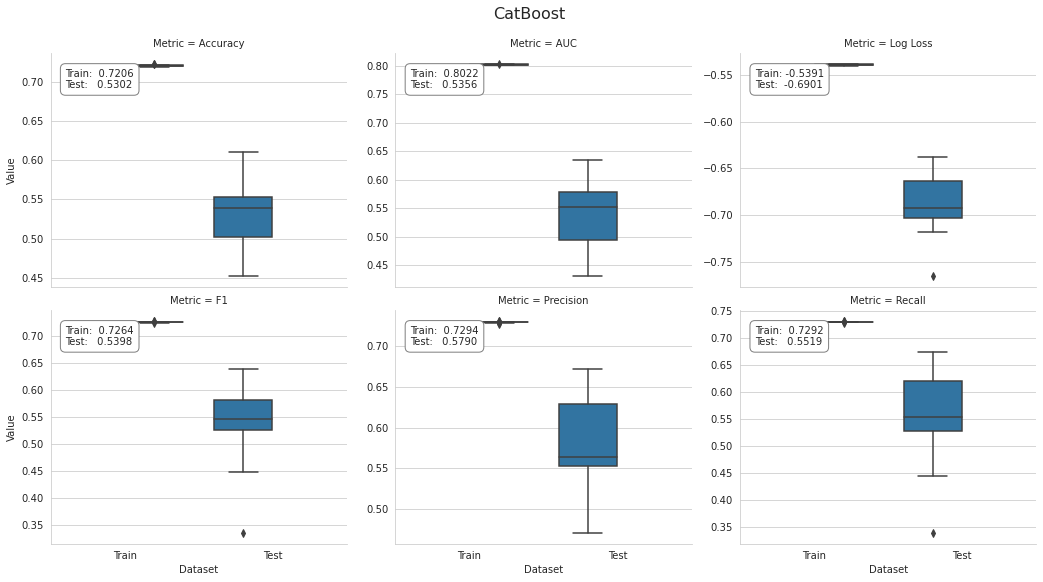

In [88]:
plot_result(cat_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

### GPU

> Naturally, the following requires that you have a GPU and install CatBoost [accordingly](https://catboost.ai/docs/features/training-on-gpu.html).

#### Configure

In [89]:
cat_clf_gpu = CatBoostClassifier(task_type='GPU')

#### Cross-Validate

In [90]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [91]:
algo = 'catboost_gpu'

In [92]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    cat_gpu_cv_result, run_time[algo] = run_cv(cat_clf_gpu,
                                               X=X_factors,
                                               fit_params={
                                                   'cat_features': cat_cols_idx},
                                               n_jobs=1)
    joblib.dump(cat_gpu_cv_result, fname)
else:
    cat_gpu_cv_result = joblib.load(fname)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.024399
0:	learn: 0.6886494	total: 66.3ms	remaining: 1m 6s
1:	learn: 0.6844047	total: 156ms	remaining: 1m 17s
2:	learn: 0.6803455	total: 239ms	remaining: 1m 19s
3:	learn: 0.6764823	total: 318ms	remaining: 1m 19s
4:	learn: 0.6728023	total: 360ms	remaining: 1m 11s
5:	learn: 0.6692983	total: 432ms	remaining: 1m 11s
6:	learn: 0.6660265	total: 526ms	remaining: 1m 14s
7:	learn: 0.6628542	total: 583ms	remaining: 1m 12s
8:	learn: 0.6598707	total: 653ms	remaining: 1m 11s
9:	learn: 0.6569938	total: 730ms	remaining: 1m 12s
10:	learn: 0.6543084	total: 830ms	remaining: 1m 14s
11:	learn: 0.6516863	total: 907ms	remaining: 1m 14s
12:	learn: 0.6491966	total: 972ms	remaining: 1m 13s
13:	learn: 0.6468082	total: 1.03s	remaining: 1m 12s
14:	learn: 0.6445762	total: 1.09s	remaining: 1m 11s
15:	learn: 0.6424384	total: 1.16s	remaining: 1m 11s
16:	learn: 0.6403281	total: 1.22s	remaining: 1m 10s
17:	learn: 0.6383903	total: 1.28s	remaining: 1m 9s
18:	learn: 0.6364532	total: 1.36s	remaining: 

163:	learn: 0.5892605	total: 10.4s	remaining: 53.1s
164:	learn: 0.5892344	total: 10.4s	remaining: 52.8s
165:	learn: 0.5892120	total: 10.5s	remaining: 52.6s
166:	learn: 0.5891837	total: 10.5s	remaining: 52.3s
167:	learn: 0.5891609	total: 10.5s	remaining: 52.1s
168:	learn: 0.5891487	total: 10.5s	remaining: 51.8s
169:	learn: 0.5891253	total: 10.6s	remaining: 51.5s
170:	learn: 0.5890867	total: 10.6s	remaining: 51.3s
171:	learn: 0.5890622	total: 10.6s	remaining: 51s
172:	learn: 0.5890368	total: 10.6s	remaining: 50.8s
173:	learn: 0.5890151	total: 10.7s	remaining: 50.6s
174:	learn: 0.5889983	total: 10.7s	remaining: 50.3s
175:	learn: 0.5889779	total: 10.7s	remaining: 50.1s
176:	learn: 0.5889604	total: 10.7s	remaining: 50s
177:	learn: 0.5889377	total: 10.8s	remaining: 49.7s
178:	learn: 0.5889208	total: 10.8s	remaining: 49.5s
179:	learn: 0.5889008	total: 10.8s	remaining: 49.3s
180:	learn: 0.5888766	total: 10.8s	remaining: 49s
181:	learn: 0.5888622	total: 10.9s	remaining: 48.8s
182:	learn: 0.5888

323:	learn: 0.5863863	total: 17.2s	remaining: 35.8s
324:	learn: 0.5863793	total: 17.2s	remaining: 35.8s
325:	learn: 0.5863551	total: 17.3s	remaining: 35.7s
326:	learn: 0.5863392	total: 17.4s	remaining: 35.8s
327:	learn: 0.5863238	total: 17.4s	remaining: 35.7s
328:	learn: 0.5863158	total: 17.5s	remaining: 35.7s
329:	learn: 0.5863056	total: 17.6s	remaining: 35.7s
330:	learn: 0.5862965	total: 17.6s	remaining: 35.7s
331:	learn: 0.5862731	total: 17.7s	remaining: 35.6s
332:	learn: 0.5862499	total: 17.8s	remaining: 35.6s
333:	learn: 0.5862376	total: 17.8s	remaining: 35.6s
334:	learn: 0.5862218	total: 17.9s	remaining: 35.5s
335:	learn: 0.5862021	total: 18s	remaining: 35.5s
336:	learn: 0.5861891	total: 18s	remaining: 35.5s
337:	learn: 0.5861778	total: 18.1s	remaining: 35.4s
338:	learn: 0.5861721	total: 18.2s	remaining: 35.4s
339:	learn: 0.5861615	total: 18.2s	remaining: 35.4s
340:	learn: 0.5861502	total: 18.3s	remaining: 35.4s
341:	learn: 0.5861406	total: 18.4s	remaining: 35.4s
342:	learn: 0.58

489:	learn: 0.5845183	total: 23.3s	remaining: 24.3s
490:	learn: 0.5845108	total: 23.3s	remaining: 24.2s
491:	learn: 0.5845012	total: 23.4s	remaining: 24.1s
492:	learn: 0.5844981	total: 23.4s	remaining: 24.1s
493:	learn: 0.5844895	total: 23.4s	remaining: 24s
494:	learn: 0.5844816	total: 23.4s	remaining: 23.9s
495:	learn: 0.5844739	total: 23.5s	remaining: 23.8s
496:	learn: 0.5844653	total: 23.5s	remaining: 23.8s
497:	learn: 0.5844586	total: 23.5s	remaining: 23.7s
498:	learn: 0.5844543	total: 23.5s	remaining: 23.6s
499:	learn: 0.5844401	total: 23.6s	remaining: 23.6s
500:	learn: 0.5844353	total: 23.6s	remaining: 23.5s
501:	learn: 0.5844204	total: 23.6s	remaining: 23.4s
502:	learn: 0.5844108	total: 23.6s	remaining: 23.3s
503:	learn: 0.5844039	total: 23.6s	remaining: 23.3s
504:	learn: 0.5843991	total: 23.7s	remaining: 23.2s
505:	learn: 0.5843959	total: 23.7s	remaining: 23.1s
506:	learn: 0.5843861	total: 23.7s	remaining: 23.1s
507:	learn: 0.5843790	total: 23.8s	remaining: 23s
508:	learn: 0.58

649:	learn: 0.5831665	total: 27.1s	remaining: 14.6s
650:	learn: 0.5831606	total: 27.1s	remaining: 14.6s
651:	learn: 0.5831554	total: 27.2s	remaining: 14.5s
652:	learn: 0.5831500	total: 27.2s	remaining: 14.5s
653:	learn: 0.5831419	total: 27.2s	remaining: 14.4s
654:	learn: 0.5831371	total: 27.2s	remaining: 14.4s
655:	learn: 0.5831340	total: 27.3s	remaining: 14.3s
656:	learn: 0.5831212	total: 27.3s	remaining: 14.3s
657:	learn: 0.5831124	total: 27.3s	remaining: 14.2s
658:	learn: 0.5831041	total: 27.4s	remaining: 14.2s
659:	learn: 0.5830971	total: 27.4s	remaining: 14.1s
660:	learn: 0.5830940	total: 27.4s	remaining: 14s
661:	learn: 0.5830895	total: 27.4s	remaining: 14s
662:	learn: 0.5830850	total: 27.4s	remaining: 13.9s
663:	learn: 0.5830694	total: 27.5s	remaining: 13.9s
664:	learn: 0.5830666	total: 27.5s	remaining: 13.8s
665:	learn: 0.5830631	total: 27.5s	remaining: 13.8s
666:	learn: 0.5830521	total: 27.5s	remaining: 13.7s
667:	learn: 0.5830443	total: 27.6s	remaining: 13.7s
668:	learn: 0.58

813:	learn: 0.5820603	total: 31.4s	remaining: 7.17s
814:	learn: 0.5820565	total: 31.4s	remaining: 7.13s
815:	learn: 0.5820484	total: 31.4s	remaining: 7.09s
816:	learn: 0.5820421	total: 31.4s	remaining: 7.04s
817:	learn: 0.5820304	total: 31.5s	remaining: 7s
818:	learn: 0.5820221	total: 31.5s	remaining: 6.96s
819:	learn: 0.5820147	total: 31.5s	remaining: 6.92s
820:	learn: 0.5820050	total: 31.6s	remaining: 6.88s
821:	learn: 0.5819988	total: 31.6s	remaining: 6.84s
822:	learn: 0.5819965	total: 31.6s	remaining: 6.8s
823:	learn: 0.5819899	total: 31.7s	remaining: 6.76s
824:	learn: 0.5819875	total: 31.7s	remaining: 6.72s
825:	learn: 0.5819822	total: 31.7s	remaining: 6.68s
826:	learn: 0.5819793	total: 31.7s	remaining: 6.64s
827:	learn: 0.5819771	total: 31.8s	remaining: 6.6s
828:	learn: 0.5819678	total: 31.8s	remaining: 6.55s
829:	learn: 0.5819602	total: 31.8s	remaining: 6.51s
830:	learn: 0.5819543	total: 31.8s	remaining: 6.47s
831:	learn: 0.5819507	total: 31.9s	remaining: 6.43s
832:	learn: 0.581

973:	learn: 0.5810719	total: 35.4s	remaining: 944ms
974:	learn: 0.5810674	total: 35.4s	remaining: 907ms
975:	learn: 0.5810583	total: 35.4s	remaining: 871ms
976:	learn: 0.5810518	total: 35.4s	remaining: 834ms
977:	learn: 0.5810427	total: 35.5s	remaining: 797ms
978:	learn: 0.5810407	total: 35.5s	remaining: 761ms
979:	learn: 0.5810361	total: 35.5s	remaining: 725ms
980:	learn: 0.5810329	total: 35.5s	remaining: 688ms
981:	learn: 0.5810232	total: 35.5s	remaining: 652ms
982:	learn: 0.5810192	total: 35.6s	remaining: 615ms
983:	learn: 0.5810141	total: 35.6s	remaining: 579ms
984:	learn: 0.5810090	total: 35.6s	remaining: 542ms
985:	learn: 0.5809884	total: 35.6s	remaining: 506ms
986:	learn: 0.5809851	total: 35.7s	remaining: 470ms
987:	learn: 0.5809815	total: 35.7s	remaining: 434ms
988:	learn: 0.5809776	total: 35.7s	remaining: 397ms
989:	learn: 0.5809723	total: 35.7s	remaining: 361ms
990:	learn: 0.5809673	total: 35.8s	remaining: 325ms
991:	learn: 0.5809572	total: 35.8s	remaining: 289ms
992:	learn: 

136:	learn: 0.5904692	total: 3.27s	remaining: 20.6s
137:	learn: 0.5904307	total: 3.29s	remaining: 20.6s
138:	learn: 0.5903945	total: 3.32s	remaining: 20.5s
139:	learn: 0.5903657	total: 3.34s	remaining: 20.5s
140:	learn: 0.5903324	total: 3.36s	remaining: 20.5s
141:	learn: 0.5902969	total: 3.38s	remaining: 20.5s
142:	learn: 0.5902650	total: 3.41s	remaining: 20.4s
143:	learn: 0.5902296	total: 3.43s	remaining: 20.4s
144:	learn: 0.5902033	total: 3.45s	remaining: 20.4s
145:	learn: 0.5901555	total: 3.48s	remaining: 20.3s
146:	learn: 0.5901259	total: 3.5s	remaining: 20.3s
147:	learn: 0.5901053	total: 3.52s	remaining: 20.3s
148:	learn: 0.5900887	total: 3.54s	remaining: 20.2s
149:	learn: 0.5900580	total: 3.57s	remaining: 20.2s
150:	learn: 0.5900255	total: 3.59s	remaining: 20.2s
151:	learn: 0.5899903	total: 3.62s	remaining: 20.2s
152:	learn: 0.5899660	total: 3.64s	remaining: 20.2s
153:	learn: 0.5899203	total: 3.67s	remaining: 20.1s
154:	learn: 0.5898918	total: 3.69s	remaining: 20.1s
155:	learn: 0

295:	learn: 0.5872896	total: 7.12s	remaining: 16.9s
296:	learn: 0.5872824	total: 7.14s	remaining: 16.9s
297:	learn: 0.5872684	total: 7.17s	remaining: 16.9s
298:	learn: 0.5872456	total: 7.19s	remaining: 16.9s
299:	learn: 0.5872339	total: 7.21s	remaining: 16.8s
300:	learn: 0.5872223	total: 7.23s	remaining: 16.8s
301:	learn: 0.5872045	total: 7.25s	remaining: 16.8s
302:	learn: 0.5871928	total: 7.28s	remaining: 16.7s
303:	learn: 0.5871820	total: 7.3s	remaining: 16.7s
304:	learn: 0.5871732	total: 7.33s	remaining: 16.7s
305:	learn: 0.5871577	total: 7.35s	remaining: 16.7s
306:	learn: 0.5871440	total: 7.39s	remaining: 16.7s
307:	learn: 0.5871289	total: 7.42s	remaining: 16.7s
308:	learn: 0.5871186	total: 7.44s	remaining: 16.6s
309:	learn: 0.5870939	total: 7.47s	remaining: 16.6s
310:	learn: 0.5870704	total: 7.49s	remaining: 16.6s
311:	learn: 0.5870282	total: 7.51s	remaining: 16.6s
312:	learn: 0.5870165	total: 7.54s	remaining: 16.5s
313:	learn: 0.5870055	total: 7.56s	remaining: 16.5s
314:	learn: 0

458:	learn: 0.5854203	total: 10.9s	remaining: 12.9s
459:	learn: 0.5854128	total: 11s	remaining: 12.9s
460:	learn: 0.5854038	total: 11s	remaining: 12.8s
461:	learn: 0.5853972	total: 11s	remaining: 12.8s
462:	learn: 0.5853858	total: 11s	remaining: 12.8s
463:	learn: 0.5853817	total: 11.1s	remaining: 12.8s
464:	learn: 0.5853740	total: 11.1s	remaining: 12.8s
465:	learn: 0.5853641	total: 11.1s	remaining: 12.7s
466:	learn: 0.5853603	total: 11.1s	remaining: 12.7s
467:	learn: 0.5853531	total: 11.2s	remaining: 12.7s
468:	learn: 0.5853402	total: 11.2s	remaining: 12.7s
469:	learn: 0.5853309	total: 11.2s	remaining: 12.6s
470:	learn: 0.5853193	total: 11.2s	remaining: 12.6s
471:	learn: 0.5853115	total: 11.2s	remaining: 12.6s
472:	learn: 0.5853020	total: 11.3s	remaining: 12.6s
473:	learn: 0.5852963	total: 11.3s	remaining: 12.5s
474:	learn: 0.5852892	total: 11.3s	remaining: 12.5s
475:	learn: 0.5852852	total: 11.3s	remaining: 12.5s
476:	learn: 0.5852723	total: 11.4s	remaining: 12.5s
477:	learn: 0.585259

619:	learn: 0.5841054	total: 14.7s	remaining: 9.01s
620:	learn: 0.5840965	total: 14.7s	remaining: 8.99s
621:	learn: 0.5840912	total: 14.8s	remaining: 8.96s
622:	learn: 0.5840866	total: 14.8s	remaining: 8.94s
623:	learn: 0.5840838	total: 14.8s	remaining: 8.91s
624:	learn: 0.5840755	total: 14.8s	remaining: 8.89s
625:	learn: 0.5840660	total: 14.8s	remaining: 8.86s
626:	learn: 0.5840620	total: 14.9s	remaining: 8.84s
627:	learn: 0.5840513	total: 14.9s	remaining: 8.82s
628:	learn: 0.5840433	total: 14.9s	remaining: 8.79s
629:	learn: 0.5840357	total: 14.9s	remaining: 8.77s
630:	learn: 0.5840316	total: 15s	remaining: 8.74s
631:	learn: 0.5840256	total: 15s	remaining: 8.72s
632:	learn: 0.5840192	total: 15s	remaining: 8.7s
633:	learn: 0.5840085	total: 15s	remaining: 8.67s
634:	learn: 0.5839951	total: 15s	remaining: 8.65s
635:	learn: 0.5839911	total: 15.1s	remaining: 8.62s
636:	learn: 0.5839856	total: 15.1s	remaining: 8.6s
637:	learn: 0.5839808	total: 15.1s	remaining: 8.57s
638:	learn: 0.5839742	to

782:	learn: 0.5828733	total: 18.5s	remaining: 5.12s
783:	learn: 0.5828705	total: 18.5s	remaining: 5.1s
784:	learn: 0.5828685	total: 18.5s	remaining: 5.07s
785:	learn: 0.5828482	total: 18.5s	remaining: 5.05s
786:	learn: 0.5828389	total: 18.6s	remaining: 5.03s
787:	learn: 0.5828365	total: 18.6s	remaining: 5s
788:	learn: 0.5828226	total: 18.6s	remaining: 4.98s
789:	learn: 0.5828060	total: 18.7s	remaining: 4.96s
790:	learn: 0.5827999	total: 18.7s	remaining: 4.94s
791:	learn: 0.5827953	total: 18.7s	remaining: 4.91s
792:	learn: 0.5827875	total: 18.7s	remaining: 4.89s
793:	learn: 0.5827829	total: 18.8s	remaining: 4.87s
794:	learn: 0.5827810	total: 18.8s	remaining: 4.84s
795:	learn: 0.5827784	total: 18.8s	remaining: 4.82s
796:	learn: 0.5827738	total: 18.8s	remaining: 4.8s
797:	learn: 0.5827684	total: 18.9s	remaining: 4.77s
798:	learn: 0.5827579	total: 18.9s	remaining: 4.75s
799:	learn: 0.5827543	total: 18.9s	remaining: 4.73s
800:	learn: 0.5827519	total: 18.9s	remaining: 4.7s
801:	learn: 0.5827

943:	learn: 0.5819210	total: 22.3s	remaining: 1.32s
944:	learn: 0.5819147	total: 22.3s	remaining: 1.3s
945:	learn: 0.5819002	total: 22.3s	remaining: 1.27s
946:	learn: 0.5818964	total: 22.4s	remaining: 1.25s
947:	learn: 0.5818892	total: 22.4s	remaining: 1.23s
948:	learn: 0.5818853	total: 22.4s	remaining: 1.2s
949:	learn: 0.5818789	total: 22.4s	remaining: 1.18s
950:	learn: 0.5818713	total: 22.4s	remaining: 1.16s
951:	learn: 0.5818701	total: 22.5s	remaining: 1.13s
952:	learn: 0.5818672	total: 22.5s	remaining: 1.11s
953:	learn: 0.5818645	total: 22.5s	remaining: 1.08s
954:	learn: 0.5818600	total: 22.5s	remaining: 1.06s
955:	learn: 0.5818534	total: 22.6s	remaining: 1.04s
956:	learn: 0.5818490	total: 22.6s	remaining: 1.01s
957:	learn: 0.5818429	total: 22.6s	remaining: 991ms
958:	learn: 0.5818386	total: 22.6s	remaining: 968ms
959:	learn: 0.5818329	total: 22.7s	remaining: 944ms
960:	learn: 0.5818279	total: 22.7s	remaining: 921ms
961:	learn: 0.5818196	total: 22.7s	remaining: 897ms
962:	learn: 0.

106:	learn: 0.5920809	total: 2.4s	remaining: 20s
107:	learn: 0.5919724	total: 2.42s	remaining: 20s
108:	learn: 0.5918869	total: 2.44s	remaining: 20s
109:	learn: 0.5918050	total: 2.47s	remaining: 20s
110:	learn: 0.5917360	total: 2.49s	remaining: 20s
111:	learn: 0.5916522	total: 2.52s	remaining: 20s
112:	learn: 0.5915856	total: 2.54s	remaining: 20s
113:	learn: 0.5915175	total: 2.56s	remaining: 19.9s
114:	learn: 0.5914487	total: 2.59s	remaining: 19.9s
115:	learn: 0.5913604	total: 2.61s	remaining: 19.9s
116:	learn: 0.5912886	total: 2.64s	remaining: 19.9s
117:	learn: 0.5912258	total: 2.66s	remaining: 19.9s
118:	learn: 0.5911511	total: 2.69s	remaining: 19.9s
119:	learn: 0.5910932	total: 2.71s	remaining: 19.8s
120:	learn: 0.5910438	total: 2.73s	remaining: 19.8s
121:	learn: 0.5909879	total: 2.75s	remaining: 19.8s
122:	learn: 0.5909312	total: 2.78s	remaining: 19.8s
123:	learn: 0.5908744	total: 2.8s	remaining: 19.8s
124:	learn: 0.5907963	total: 2.82s	remaining: 19.8s
125:	learn: 0.5907420	total:

270:	learn: 0.5873621	total: 6.18s	remaining: 16.6s
271:	learn: 0.5873457	total: 6.21s	remaining: 16.6s
272:	learn: 0.5873395	total: 6.23s	remaining: 16.6s
273:	learn: 0.5873203	total: 6.26s	remaining: 16.6s
274:	learn: 0.5873089	total: 6.28s	remaining: 16.5s
275:	learn: 0.5873038	total: 6.3s	remaining: 16.5s
276:	learn: 0.5872902	total: 6.33s	remaining: 16.5s
277:	learn: 0.5872611	total: 6.35s	remaining: 16.5s
278:	learn: 0.5872461	total: 6.38s	remaining: 16.5s
279:	learn: 0.5872192	total: 6.4s	remaining: 16.5s
280:	learn: 0.5872123	total: 6.42s	remaining: 16.4s
281:	learn: 0.5871968	total: 6.45s	remaining: 16.4s
282:	learn: 0.5871898	total: 6.47s	remaining: 16.4s
283:	learn: 0.5871722	total: 6.5s	remaining: 16.4s
284:	learn: 0.5871612	total: 6.52s	remaining: 16.4s
285:	learn: 0.5871518	total: 6.55s	remaining: 16.4s
286:	learn: 0.5871309	total: 6.58s	remaining: 16.3s
287:	learn: 0.5871199	total: 6.6s	remaining: 16.3s
288:	learn: 0.5871090	total: 6.62s	remaining: 16.3s
289:	learn: 0.58

430:	learn: 0.5853465	total: 9.96s	remaining: 13.1s
431:	learn: 0.5853271	total: 9.98s	remaining: 13.1s
432:	learn: 0.5853204	total: 10s	remaining: 13.1s
433:	learn: 0.5853118	total: 10s	remaining: 13.1s
434:	learn: 0.5852999	total: 10s	remaining: 13.1s
435:	learn: 0.5852926	total: 10.1s	remaining: 13s
436:	learn: 0.5852888	total: 10.1s	remaining: 13s
437:	learn: 0.5852715	total: 10.1s	remaining: 13s
438:	learn: 0.5852613	total: 10.1s	remaining: 13s
439:	learn: 0.5852545	total: 10.2s	remaining: 12.9s
440:	learn: 0.5852430	total: 10.2s	remaining: 12.9s
441:	learn: 0.5852327	total: 10.2s	remaining: 12.9s
442:	learn: 0.5852155	total: 10.2s	remaining: 12.9s
443:	learn: 0.5852070	total: 10.3s	remaining: 12.8s
444:	learn: 0.5851983	total: 10.3s	remaining: 12.8s
445:	learn: 0.5851910	total: 10.3s	remaining: 12.8s
446:	learn: 0.5851845	total: 10.3s	remaining: 12.8s
447:	learn: 0.5851757	total: 10.3s	remaining: 12.8s
448:	learn: 0.5851690	total: 10.4s	remaining: 12.7s
449:	learn: 0.5851575	tota

592:	learn: 0.5838482	total: 13.7s	remaining: 9.4s
593:	learn: 0.5838425	total: 13.7s	remaining: 9.37s
594:	learn: 0.5838363	total: 13.7s	remaining: 9.35s
595:	learn: 0.5838244	total: 13.8s	remaining: 9.33s
596:	learn: 0.5838119	total: 13.8s	remaining: 9.3s
597:	learn: 0.5837983	total: 13.8s	remaining: 9.28s
598:	learn: 0.5837880	total: 13.8s	remaining: 9.26s
599:	learn: 0.5837829	total: 13.9s	remaining: 9.24s
600:	learn: 0.5837783	total: 13.9s	remaining: 9.21s
601:	learn: 0.5837747	total: 13.9s	remaining: 9.19s
602:	learn: 0.5837687	total: 13.9s	remaining: 9.17s
603:	learn: 0.5837520	total: 13.9s	remaining: 9.14s
604:	learn: 0.5837392	total: 14s	remaining: 9.12s
605:	learn: 0.5837345	total: 14s	remaining: 9.1s
606:	learn: 0.5837154	total: 14s	remaining: 9.08s
607:	learn: 0.5837098	total: 14s	remaining: 9.05s
608:	learn: 0.5837005	total: 14.1s	remaining: 9.03s
609:	learn: 0.5836940	total: 14.1s	remaining: 9s
610:	learn: 0.5836835	total: 14.1s	remaining: 8.98s
611:	learn: 0.5836753	tota

756:	learn: 0.5824983	total: 17.5s	remaining: 5.63s
757:	learn: 0.5824821	total: 17.6s	remaining: 5.61s
758:	learn: 0.5824748	total: 17.6s	remaining: 5.59s
759:	learn: 0.5824715	total: 17.6s	remaining: 5.56s
760:	learn: 0.5824708	total: 17.6s	remaining: 5.54s
761:	learn: 0.5824689	total: 17.7s	remaining: 5.52s
762:	learn: 0.5824661	total: 17.7s	remaining: 5.49s
763:	learn: 0.5824564	total: 17.7s	remaining: 5.47s
764:	learn: 0.5824530	total: 17.7s	remaining: 5.45s
765:	learn: 0.5824502	total: 17.8s	remaining: 5.42s
766:	learn: 0.5824457	total: 17.8s	remaining: 5.4s
767:	learn: 0.5824420	total: 17.8s	remaining: 5.38s
768:	learn: 0.5824396	total: 17.8s	remaining: 5.35s
769:	learn: 0.5824327	total: 17.8s	remaining: 5.33s
770:	learn: 0.5824244	total: 17.9s	remaining: 5.31s
771:	learn: 0.5824134	total: 17.9s	remaining: 5.28s
772:	learn: 0.5824007	total: 17.9s	remaining: 5.26s
773:	learn: 0.5823982	total: 17.9s	remaining: 5.24s
774:	learn: 0.5823939	total: 18s	remaining: 5.21s
775:	learn: 0.5

919:	learn: 0.5815370	total: 21.3s	remaining: 1.85s
920:	learn: 0.5815331	total: 21.3s	remaining: 1.83s
921:	learn: 0.5815297	total: 21.3s	remaining: 1.8s
922:	learn: 0.5815268	total: 21.4s	remaining: 1.78s
923:	learn: 0.5815248	total: 21.4s	remaining: 1.76s
924:	learn: 0.5815171	total: 21.4s	remaining: 1.74s
925:	learn: 0.5815121	total: 21.4s	remaining: 1.71s
926:	learn: 0.5815060	total: 21.5s	remaining: 1.69s
927:	learn: 0.5815012	total: 21.5s	remaining: 1.67s
928:	learn: 0.5814929	total: 21.5s	remaining: 1.64s
929:	learn: 0.5814866	total: 21.5s	remaining: 1.62s
930:	learn: 0.5814802	total: 21.6s	remaining: 1.6s
931:	learn: 0.5814768	total: 21.6s	remaining: 1.57s
932:	learn: 0.5814744	total: 21.6s	remaining: 1.55s
933:	learn: 0.5814724	total: 21.6s	remaining: 1.53s
934:	learn: 0.5814670	total: 21.6s	remaining: 1.5s
935:	learn: 0.5814644	total: 21.7s	remaining: 1.48s
936:	learn: 0.5814569	total: 21.7s	remaining: 1.46s
937:	learn: 0.5814531	total: 21.7s	remaining: 1.43s
938:	learn: 0.5

83:	learn: 0.5947571	total: 1.92s	remaining: 20.9s
84:	learn: 0.5945716	total: 1.94s	remaining: 20.9s
85:	learn: 0.5944019	total: 1.96s	remaining: 20.9s
86:	learn: 0.5942241	total: 1.99s	remaining: 20.8s
87:	learn: 0.5940544	total: 2.01s	remaining: 20.8s
88:	learn: 0.5939041	total: 2.04s	remaining: 20.9s
89:	learn: 0.5937516	total: 2.07s	remaining: 20.9s
90:	learn: 0.5935612	total: 2.09s	remaining: 20.9s
91:	learn: 0.5933986	total: 2.12s	remaining: 20.9s
92:	learn: 0.5932742	total: 2.14s	remaining: 20.9s
93:	learn: 0.5931133	total: 2.16s	remaining: 20.8s
94:	learn: 0.5929785	total: 2.19s	remaining: 20.8s
95:	learn: 0.5928499	total: 2.21s	remaining: 20.8s
96:	learn: 0.5927333	total: 2.23s	remaining: 20.8s
97:	learn: 0.5926119	total: 2.26s	remaining: 20.8s
98:	learn: 0.5925257	total: 2.28s	remaining: 20.8s
99:	learn: 0.5924067	total: 2.3s	remaining: 20.7s
100:	learn: 0.5923035	total: 2.33s	remaining: 20.7s
101:	learn: 0.5922022	total: 2.36s	remaining: 20.7s
102:	learn: 0.5920843	total: 2

244:	learn: 0.5872959	total: 10.2s	remaining: 31.5s
245:	learn: 0.5872728	total: 10.2s	remaining: 31.4s
246:	learn: 0.5872535	total: 10.3s	remaining: 31.3s
247:	learn: 0.5872358	total: 10.3s	remaining: 31.2s
248:	learn: 0.5872241	total: 10.3s	remaining: 31.2s
249:	learn: 0.5872099	total: 10.4s	remaining: 31.1s
250:	learn: 0.5871896	total: 10.4s	remaining: 31s
251:	learn: 0.5871734	total: 10.4s	remaining: 30.9s
252:	learn: 0.5871569	total: 10.4s	remaining: 30.8s
253:	learn: 0.5871442	total: 10.5s	remaining: 30.7s
254:	learn: 0.5871337	total: 10.5s	remaining: 30.6s
255:	learn: 0.5871031	total: 10.5s	remaining: 30.5s
256:	learn: 0.5870904	total: 10.5s	remaining: 30.4s
257:	learn: 0.5870697	total: 10.6s	remaining: 30.3s
258:	learn: 0.5870546	total: 10.6s	remaining: 30.3s
259:	learn: 0.5870416	total: 10.6s	remaining: 30.2s
260:	learn: 0.5870315	total: 10.6s	remaining: 30.1s
261:	learn: 0.5870177	total: 10.6s	remaining: 30s
262:	learn: 0.5869929	total: 10.7s	remaining: 29.9s
263:	learn: 0.58

403:	learn: 0.5852208	total: 14s	remaining: 20.7s
404:	learn: 0.5852111	total: 14s	remaining: 20.6s
405:	learn: 0.5852036	total: 14.1s	remaining: 20.6s
406:	learn: 0.5851958	total: 14.1s	remaining: 20.5s
407:	learn: 0.5851847	total: 14.1s	remaining: 20.5s
408:	learn: 0.5851651	total: 14.1s	remaining: 20.4s
409:	learn: 0.5851586	total: 14.1s	remaining: 20.4s
410:	learn: 0.5851366	total: 14.2s	remaining: 20.3s
411:	learn: 0.5851223	total: 14.2s	remaining: 20.3s
412:	learn: 0.5851161	total: 14.2s	remaining: 20.2s
413:	learn: 0.5851076	total: 14.2s	remaining: 20.2s
414:	learn: 0.5850927	total: 14.3s	remaining: 20.1s
415:	learn: 0.5850695	total: 14.3s	remaining: 20.1s
416:	learn: 0.5850579	total: 14.3s	remaining: 20s
417:	learn: 0.5850484	total: 14.3s	remaining: 20s
418:	learn: 0.5850413	total: 14.4s	remaining: 19.9s
419:	learn: 0.5850287	total: 14.4s	remaining: 19.9s
420:	learn: 0.5850154	total: 14.4s	remaining: 19.8s
421:	learn: 0.5850039	total: 14.4s	remaining: 19.8s
422:	learn: 0.584991

565:	learn: 0.5836835	total: 17.8s	remaining: 13.7s
566:	learn: 0.5836771	total: 17.8s	remaining: 13.6s
567:	learn: 0.5836604	total: 17.9s	remaining: 13.6s
568:	learn: 0.5836550	total: 17.9s	remaining: 13.5s
569:	learn: 0.5836505	total: 17.9s	remaining: 13.5s
570:	learn: 0.5836431	total: 17.9s	remaining: 13.5s
571:	learn: 0.5836309	total: 18s	remaining: 13.4s
572:	learn: 0.5836217	total: 18s	remaining: 13.4s
573:	learn: 0.5836182	total: 18s	remaining: 13.4s
574:	learn: 0.5836116	total: 18s	remaining: 13.3s
575:	learn: 0.5835914	total: 18s	remaining: 13.3s
576:	learn: 0.5835851	total: 18.1s	remaining: 13.3s
577:	learn: 0.5835771	total: 18.1s	remaining: 13.2s
578:	learn: 0.5835693	total: 18.1s	remaining: 13.2s
579:	learn: 0.5835660	total: 18.1s	remaining: 13.1s
580:	learn: 0.5835473	total: 18.2s	remaining: 13.1s
581:	learn: 0.5835321	total: 18.2s	remaining: 13.1s
582:	learn: 0.5835058	total: 18.2s	remaining: 13s
583:	learn: 0.5834967	total: 18.2s	remaining: 13s
584:	learn: 0.5834855	tota

724:	learn: 0.5823699	total: 24s	remaining: 9.11s
725:	learn: 0.5823643	total: 24.1s	remaining: 9.09s
726:	learn: 0.5823615	total: 24.1s	remaining: 9.07s
727:	learn: 0.5823508	total: 24.2s	remaining: 9.05s
728:	learn: 0.5823469	total: 24.3s	remaining: 9.03s
729:	learn: 0.5823424	total: 24.3s	remaining: 9s
730:	learn: 0.5823282	total: 24.4s	remaining: 8.98s
731:	learn: 0.5823247	total: 24.5s	remaining: 8.96s
732:	learn: 0.5823214	total: 24.5s	remaining: 8.94s
733:	learn: 0.5823140	total: 24.6s	remaining: 8.92s
734:	learn: 0.5823054	total: 24.7s	remaining: 8.9s
735:	learn: 0.5822966	total: 24.7s	remaining: 8.87s
736:	learn: 0.5822906	total: 24.8s	remaining: 8.85s
737:	learn: 0.5822835	total: 24.9s	remaining: 8.83s
738:	learn: 0.5822817	total: 24.9s	remaining: 8.8s
739:	learn: 0.5822699	total: 25s	remaining: 8.79s
740:	learn: 0.5822569	total: 25.1s	remaining: 8.76s
741:	learn: 0.5822353	total: 25.1s	remaining: 8.74s
742:	learn: 0.5822228	total: 25.2s	remaining: 8.72s
743:	learn: 0.5822105

891:	learn: 0.5811925	total: 31.9s	remaining: 3.86s
892:	learn: 0.5811806	total: 31.9s	remaining: 3.82s
893:	learn: 0.5811772	total: 31.9s	remaining: 3.79s
894:	learn: 0.5811739	total: 32s	remaining: 3.75s
895:	learn: 0.5811628	total: 32s	remaining: 3.71s
896:	learn: 0.5811551	total: 32s	remaining: 3.67s
897:	learn: 0.5811430	total: 32s	remaining: 3.64s
898:	learn: 0.5811370	total: 32s	remaining: 3.6s
899:	learn: 0.5811221	total: 32.1s	remaining: 3.56s
900:	learn: 0.5811176	total: 32.1s	remaining: 3.53s
901:	learn: 0.5811102	total: 32.1s	remaining: 3.49s
902:	learn: 0.5811055	total: 32.1s	remaining: 3.45s
903:	learn: 0.5811035	total: 32.2s	remaining: 3.42s
904:	learn: 0.5810991	total: 32.2s	remaining: 3.38s
905:	learn: 0.5810903	total: 32.2s	remaining: 3.34s
906:	learn: 0.5810882	total: 32.2s	remaining: 3.31s
907:	learn: 0.5810858	total: 32.3s	remaining: 3.27s
908:	learn: 0.5810731	total: 32.3s	remaining: 3.23s
909:	learn: 0.5810669	total: 32.3s	remaining: 3.2s
910:	learn: 0.5810578	to

50:	learn: 0.6043703	total: 3.28s	remaining: 1m 1s
51:	learn: 0.6038831	total: 3.34s	remaining: 1m
52:	learn: 0.6034391	total: 3.41s	remaining: 1m
53:	learn: 0.6030346	total: 3.47s	remaining: 1m
54:	learn: 0.6025830	total: 3.53s	remaining: 1m
55:	learn: 0.6021649	total: 3.59s	remaining: 1m
56:	learn: 0.6017820	total: 3.66s	remaining: 1m
57:	learn: 0.6014073	total: 3.72s	remaining: 1m
58:	learn: 0.6010339	total: 3.79s	remaining: 1m
59:	learn: 0.6006787	total: 3.85s	remaining: 1m
60:	learn: 0.6003421	total: 3.91s	remaining: 1m
61:	learn: 0.6000488	total: 3.97s	remaining: 1m
62:	learn: 0.5997169	total: 4.04s	remaining: 1m
63:	learn: 0.5994137	total: 4.1s	remaining: 59.9s
64:	learn: 0.5991376	total: 4.16s	remaining: 59.9s
65:	learn: 0.5988371	total: 4.23s	remaining: 59.8s
66:	learn: 0.5985836	total: 4.29s	remaining: 59.7s
67:	learn: 0.5983107	total: 4.35s	remaining: 59.6s
68:	learn: 0.5979791	total: 4.41s	remaining: 59.5s
69:	learn: 0.5977484	total: 4.47s	remaining: 59.4s
70:	learn: 0.5975

213:	learn: 0.5877556	total: 12.9s	remaining: 47.4s
214:	learn: 0.5877416	total: 12.9s	remaining: 47.2s
215:	learn: 0.5877243	total: 13s	remaining: 47s
216:	learn: 0.5876975	total: 13s	remaining: 46.8s
217:	learn: 0.5876790	total: 13s	remaining: 46.7s
218:	learn: 0.5876628	total: 13s	remaining: 46.5s
219:	learn: 0.5876524	total: 13.1s	remaining: 46.3s
220:	learn: 0.5876383	total: 13.1s	remaining: 46.1s
221:	learn: 0.5876258	total: 13.1s	remaining: 45.9s
222:	learn: 0.5876065	total: 13.1s	remaining: 45.7s
223:	learn: 0.5875802	total: 13.2s	remaining: 45.6s
224:	learn: 0.5875657	total: 13.2s	remaining: 45.4s
225:	learn: 0.5875425	total: 13.2s	remaining: 45.2s
226:	learn: 0.5875235	total: 13.2s	remaining: 45.1s
227:	learn: 0.5874958	total: 13.3s	remaining: 44.9s
228:	learn: 0.5874733	total: 13.3s	remaining: 44.7s
229:	learn: 0.5874600	total: 13.3s	remaining: 44.5s
230:	learn: 0.5874465	total: 13.3s	remaining: 44.4s
231:	learn: 0.5874357	total: 13.4s	remaining: 44.2s
232:	learn: 0.5874133	

373:	learn: 0.5853084	total: 22.3s	remaining: 37.3s
374:	learn: 0.5852994	total: 22.4s	remaining: 37.3s
375:	learn: 0.5852904	total: 22.4s	remaining: 37.2s
376:	learn: 0.5852839	total: 22.5s	remaining: 37.2s
377:	learn: 0.5852767	total: 22.6s	remaining: 37.1s
378:	learn: 0.5852700	total: 22.6s	remaining: 37.1s
379:	learn: 0.5852600	total: 22.7s	remaining: 37s
380:	learn: 0.5852533	total: 22.8s	remaining: 37s
381:	learn: 0.5852476	total: 22.8s	remaining: 36.9s
382:	learn: 0.5852210	total: 22.9s	remaining: 36.9s
383:	learn: 0.5852147	total: 23s	remaining: 36.8s
384:	learn: 0.5852052	total: 23s	remaining: 36.8s
385:	learn: 0.5851942	total: 23.1s	remaining: 36.7s
386:	learn: 0.5851822	total: 23.1s	remaining: 36.7s
387:	learn: 0.5851684	total: 23.2s	remaining: 36.6s
388:	learn: 0.5851620	total: 23.3s	remaining: 36.6s
389:	learn: 0.5851562	total: 23.4s	remaining: 36.5s
390:	learn: 0.5851408	total: 23.4s	remaining: 36.5s
391:	learn: 0.5851330	total: 23.5s	remaining: 36.4s
392:	learn: 0.585120

534:	learn: 0.5836826	total: 28.3s	remaining: 24.6s
535:	learn: 0.5836775	total: 28.4s	remaining: 24.6s
536:	learn: 0.5836750	total: 28.5s	remaining: 24.5s
537:	learn: 0.5836690	total: 28.5s	remaining: 24.5s
538:	learn: 0.5836629	total: 28.6s	remaining: 24.5s
539:	learn: 0.5836566	total: 28.7s	remaining: 24.4s
540:	learn: 0.5836396	total: 28.7s	remaining: 24.4s
541:	learn: 0.5836251	total: 28.8s	remaining: 24.4s
542:	learn: 0.5836156	total: 28.9s	remaining: 24.3s
543:	learn: 0.5836114	total: 28.9s	remaining: 24.3s
544:	learn: 0.5836058	total: 29s	remaining: 24.2s
545:	learn: 0.5836014	total: 29.1s	remaining: 24.2s
546:	learn: 0.5835970	total: 29.1s	remaining: 24.1s
547:	learn: 0.5835898	total: 29.2s	remaining: 24.1s
548:	learn: 0.5835827	total: 29.3s	remaining: 24.1s
549:	learn: 0.5835768	total: 29.3s	remaining: 24s
550:	learn: 0.5835705	total: 29.4s	remaining: 24s
551:	learn: 0.5835655	total: 29.5s	remaining: 23.9s
552:	learn: 0.5835595	total: 29.6s	remaining: 23.9s
553:	learn: 0.5835

696:	learn: 0.5822871	total: 38.1s	remaining: 16.6s
697:	learn: 0.5822816	total: 38.1s	remaining: 16.5s
698:	learn: 0.5822750	total: 38.1s	remaining: 16.4s
699:	learn: 0.5822688	total: 38.2s	remaining: 16.4s
700:	learn: 0.5822621	total: 38.2s	remaining: 16.3s
701:	learn: 0.5822571	total: 38.2s	remaining: 16.2s
702:	learn: 0.5822489	total: 38.2s	remaining: 16.2s
703:	learn: 0.5822308	total: 38.3s	remaining: 16.1s
704:	learn: 0.5822258	total: 38.3s	remaining: 16s
705:	learn: 0.5822155	total: 38.3s	remaining: 16s
706:	learn: 0.5822073	total: 38.4s	remaining: 15.9s
707:	learn: 0.5822021	total: 38.4s	remaining: 15.8s
708:	learn: 0.5821995	total: 38.4s	remaining: 15.8s
709:	learn: 0.5821907	total: 38.4s	remaining: 15.7s
710:	learn: 0.5821833	total: 38.5s	remaining: 15.6s
711:	learn: 0.5821772	total: 38.5s	remaining: 15.6s
712:	learn: 0.5821727	total: 38.5s	remaining: 15.5s
713:	learn: 0.5821701	total: 38.5s	remaining: 15.4s
714:	learn: 0.5821639	total: 38.6s	remaining: 15.4s
715:	learn: 0.58

856:	learn: 0.5812300	total: 43.5s	remaining: 7.26s
857:	learn: 0.5812178	total: 43.6s	remaining: 7.21s
858:	learn: 0.5812131	total: 43.7s	remaining: 7.17s
859:	learn: 0.5812101	total: 43.7s	remaining: 7.12s
860:	learn: 0.5811822	total: 43.8s	remaining: 7.08s
861:	learn: 0.5811755	total: 43.9s	remaining: 7.03s
862:	learn: 0.5811728	total: 43.9s	remaining: 6.98s
863:	learn: 0.5811681	total: 44s	remaining: 6.93s
864:	learn: 0.5811628	total: 44.1s	remaining: 6.88s
865:	learn: 0.5811588	total: 44.2s	remaining: 6.83s
866:	learn: 0.5811565	total: 44.2s	remaining: 6.79s
867:	learn: 0.5811509	total: 44.3s	remaining: 6.74s
868:	learn: 0.5811484	total: 44.4s	remaining: 6.69s
869:	learn: 0.5811452	total: 44.5s	remaining: 6.64s
870:	learn: 0.5811398	total: 44.5s	remaining: 6.6s
871:	learn: 0.5811359	total: 44.6s	remaining: 6.55s
872:	learn: 0.5811298	total: 44.7s	remaining: 6.5s
873:	learn: 0.5811264	total: 44.8s	remaining: 6.45s
874:	learn: 0.5811237	total: 44.8s	remaining: 6.4s
875:	learn: 0.581

18:	learn: 0.6358900	total: 452ms	remaining: 23.3s
19:	learn: 0.6340894	total: 477ms	remaining: 23.4s
20:	learn: 0.6323618	total: 501ms	remaining: 23.3s
21:	learn: 0.6306882	total: 524ms	remaining: 23.3s
22:	learn: 0.6290976	total: 546ms	remaining: 23.2s
23:	learn: 0.6276377	total: 570ms	remaining: 23.2s
24:	learn: 0.6261681	total: 592ms	remaining: 23.1s
25:	learn: 0.6247713	total: 614ms	remaining: 23s
26:	learn: 0.6234278	total: 637ms	remaining: 22.9s
27:	learn: 0.6221597	total: 661ms	remaining: 22.9s
28:	learn: 0.6209551	total: 694ms	remaining: 23.2s
29:	learn: 0.6197743	total: 717ms	remaining: 23.2s
30:	learn: 0.6186869	total: 742ms	remaining: 23.2s
31:	learn: 0.6175893	total: 764ms	remaining: 23.1s
32:	learn: 0.6165658	total: 785ms	remaining: 23s
33:	learn: 0.6156260	total: 807ms	remaining: 22.9s
34:	learn: 0.6147140	total: 828ms	remaining: 22.8s
35:	learn: 0.6137635	total: 848ms	remaining: 22.7s
36:	learn: 0.6129369	total: 870ms	remaining: 22.7s
37:	learn: 0.6120988	total: 902ms	r

178:	learn: 0.5880168	total: 7.18s	remaining: 32.9s
179:	learn: 0.5879890	total: 7.25s	remaining: 33s
180:	learn: 0.5879677	total: 7.32s	remaining: 33.1s
181:	learn: 0.5879498	total: 7.37s	remaining: 33.1s
182:	learn: 0.5879318	total: 7.45s	remaining: 33.3s
183:	learn: 0.5879114	total: 7.52s	remaining: 33.4s
184:	learn: 0.5878807	total: 7.58s	remaining: 33.4s
185:	learn: 0.5878605	total: 7.66s	remaining: 33.5s
186:	learn: 0.5878336	total: 7.74s	remaining: 33.7s
187:	learn: 0.5878173	total: 7.81s	remaining: 33.7s
188:	learn: 0.5877996	total: 7.87s	remaining: 33.8s
189:	learn: 0.5877783	total: 7.95s	remaining: 33.9s
190:	learn: 0.5877660	total: 8.01s	remaining: 33.9s
191:	learn: 0.5877450	total: 8.08s	remaining: 34s
192:	learn: 0.5877201	total: 8.17s	remaining: 34.2s
193:	learn: 0.5877013	total: 8.24s	remaining: 34.2s
194:	learn: 0.5876872	total: 8.3s	remaining: 34.3s
195:	learn: 0.5876660	total: 8.36s	remaining: 34.3s
196:	learn: 0.5876467	total: 8.43s	remaining: 34.4s
197:	learn: 0.587

338:	learn: 0.5853650	total: 16.3s	remaining: 31.7s
339:	learn: 0.5853482	total: 16.3s	remaining: 31.6s
340:	learn: 0.5853337	total: 16.3s	remaining: 31.5s
341:	learn: 0.5853139	total: 16.3s	remaining: 31.4s
342:	learn: 0.5853039	total: 16.4s	remaining: 31.3s
343:	learn: 0.5852973	total: 16.4s	remaining: 31.3s
344:	learn: 0.5852895	total: 16.4s	remaining: 31.2s
345:	learn: 0.5852780	total: 16.5s	remaining: 31.1s
346:	learn: 0.5852676	total: 16.5s	remaining: 31s
347:	learn: 0.5852627	total: 16.5s	remaining: 31s
348:	learn: 0.5852409	total: 16.6s	remaining: 30.9s
349:	learn: 0.5852277	total: 16.6s	remaining: 30.8s
350:	learn: 0.5852164	total: 16.6s	remaining: 30.7s
351:	learn: 0.5852022	total: 16.6s	remaining: 30.6s
352:	learn: 0.5851900	total: 16.7s	remaining: 30.5s
353:	learn: 0.5851821	total: 16.7s	remaining: 30.4s
354:	learn: 0.5851756	total: 16.7s	remaining: 30.4s
355:	learn: 0.5851667	total: 16.7s	remaining: 30.3s
356:	learn: 0.5851580	total: 16.8s	remaining: 30.2s
357:	learn: 0.58

499:	learn: 0.5837701	total: 26.9s	remaining: 26.9s
500:	learn: 0.5837626	total: 27s	remaining: 26.8s
501:	learn: 0.5837299	total: 27s	remaining: 26.8s
502:	learn: 0.5837183	total: 27.1s	remaining: 26.8s
503:	learn: 0.5837117	total: 27.1s	remaining: 26.7s
504:	learn: 0.5837066	total: 27.2s	remaining: 26.7s
505:	learn: 0.5836992	total: 27.3s	remaining: 26.6s
506:	learn: 0.5836954	total: 27.3s	remaining: 26.6s
507:	learn: 0.5836901	total: 27.4s	remaining: 26.5s
508:	learn: 0.5836743	total: 27.4s	remaining: 26.5s
509:	learn: 0.5836687	total: 27.5s	remaining: 26.4s
510:	learn: 0.5836604	total: 27.5s	remaining: 26.3s
511:	learn: 0.5836490	total: 27.5s	remaining: 26.2s
512:	learn: 0.5836321	total: 27.5s	remaining: 26.1s
513:	learn: 0.5836209	total: 27.6s	remaining: 26.1s
514:	learn: 0.5836143	total: 27.6s	remaining: 26s
515:	learn: 0.5836052	total: 27.6s	remaining: 25.9s
516:	learn: 0.5835954	total: 27.6s	remaining: 25.8s
517:	learn: 0.5835884	total: 27.7s	remaining: 25.7s
518:	learn: 0.5835

658:	learn: 0.5824255	total: 32.6s	remaining: 16.9s
659:	learn: 0.5824168	total: 32.7s	remaining: 16.8s
660:	learn: 0.5824050	total: 32.8s	remaining: 16.8s
661:	learn: 0.5823883	total: 32.8s	remaining: 16.8s
662:	learn: 0.5823679	total: 32.9s	remaining: 16.7s
663:	learn: 0.5823619	total: 33s	remaining: 16.7s
664:	learn: 0.5823561	total: 33s	remaining: 16.6s
665:	learn: 0.5823457	total: 33.1s	remaining: 16.6s
666:	learn: 0.5823407	total: 33.2s	remaining: 16.6s
667:	learn: 0.5823353	total: 33.3s	remaining: 16.6s
668:	learn: 0.5823316	total: 33.4s	remaining: 16.5s
669:	learn: 0.5823200	total: 33.4s	remaining: 16.5s
670:	learn: 0.5823106	total: 33.5s	remaining: 16.4s
671:	learn: 0.5823091	total: 33.6s	remaining: 16.4s
672:	learn: 0.5823031	total: 33.6s	remaining: 16.3s
673:	learn: 0.5822986	total: 33.7s	remaining: 16.3s
674:	learn: 0.5822889	total: 33.8s	remaining: 16.3s
675:	learn: 0.5822794	total: 33.8s	remaining: 16.2s
676:	learn: 0.5822774	total: 33.9s	remaining: 16.2s
677:	learn: 0.58

819:	learn: 0.5812869	total: 41.8s	remaining: 9.17s
820:	learn: 0.5812756	total: 41.8s	remaining: 9.12s
821:	learn: 0.5812717	total: 41.8s	remaining: 9.06s
822:	learn: 0.5812618	total: 41.9s	remaining: 9s
823:	learn: 0.5812570	total: 41.9s	remaining: 8.94s
824:	learn: 0.5812487	total: 41.9s	remaining: 8.89s
825:	learn: 0.5812292	total: 41.9s	remaining: 8.83s
826:	learn: 0.5812259	total: 42s	remaining: 8.78s
827:	learn: 0.5812177	total: 42s	remaining: 8.72s
828:	learn: 0.5812147	total: 42s	remaining: 8.66s
829:	learn: 0.5812104	total: 42s	remaining: 8.61s
830:	learn: 0.5812064	total: 42.1s	remaining: 8.55s
831:	learn: 0.5812004	total: 42.1s	remaining: 8.49s
832:	learn: 0.5811932	total: 42.1s	remaining: 8.44s
833:	learn: 0.5811859	total: 42.1s	remaining: 8.38s
834:	learn: 0.5811806	total: 42.2s	remaining: 8.33s
835:	learn: 0.5811682	total: 42.2s	remaining: 8.27s
836:	learn: 0.5811609	total: 42.2s	remaining: 8.22s
837:	learn: 0.5811568	total: 42.2s	remaining: 8.16s
838:	learn: 0.5811512	t

981:	learn: 0.5803089	total: 49.3s	remaining: 904ms
982:	learn: 0.5803016	total: 49.4s	remaining: 854ms
983:	learn: 0.5802963	total: 49.4s	remaining: 804ms
984:	learn: 0.5802942	total: 49.5s	remaining: 754ms
985:	learn: 0.5802878	total: 49.5s	remaining: 703ms
986:	learn: 0.5802810	total: 49.6s	remaining: 653ms
987:	learn: 0.5802789	total: 49.7s	remaining: 603ms
988:	learn: 0.5802752	total: 49.7s	remaining: 553ms
989:	learn: 0.5802691	total: 49.8s	remaining: 503ms
990:	learn: 0.5802563	total: 49.9s	remaining: 453ms
991:	learn: 0.5802548	total: 49.9s	remaining: 403ms
992:	learn: 0.5802480	total: 50s	remaining: 353ms
993:	learn: 0.5802452	total: 50.1s	remaining: 302ms
994:	learn: 0.5802315	total: 50.1s	remaining: 252ms
995:	learn: 0.5802189	total: 50.2s	remaining: 202ms
996:	learn: 0.5802127	total: 50.3s	remaining: 151ms
997:	learn: 0.5802091	total: 50.4s	remaining: 101ms
998:	learn: 0.5802051	total: 50.4s	remaining: 50.5ms
999:	learn: 0.5802026	total: 50.5s	remaining: 0us
Learning rate s

148:	learn: 0.5893211	total: 8.19s	remaining: 46.8s
149:	learn: 0.5892866	total: 8.21s	remaining: 46.5s
150:	learn: 0.5892531	total: 8.23s	remaining: 46.3s
151:	learn: 0.5892293	total: 8.26s	remaining: 46.1s
152:	learn: 0.5891785	total: 8.28s	remaining: 45.8s
153:	learn: 0.5891348	total: 8.3s	remaining: 45.6s
154:	learn: 0.5890882	total: 8.32s	remaining: 45.4s
155:	learn: 0.5890654	total: 8.35s	remaining: 45.2s
156:	learn: 0.5890430	total: 8.38s	remaining: 45s
157:	learn: 0.5889928	total: 8.4s	remaining: 44.8s
158:	learn: 0.5889627	total: 8.42s	remaining: 44.5s
159:	learn: 0.5889335	total: 8.44s	remaining: 44.3s
160:	learn: 0.5889062	total: 8.46s	remaining: 44.1s
161:	learn: 0.5888870	total: 8.49s	remaining: 43.9s
162:	learn: 0.5888611	total: 8.51s	remaining: 43.7s
163:	learn: 0.5888422	total: 8.53s	remaining: 43.5s
164:	learn: 0.5888024	total: 8.56s	remaining: 43.3s
165:	learn: 0.5887781	total: 8.58s	remaining: 43.1s
166:	learn: 0.5887406	total: 8.6s	remaining: 42.9s
167:	learn: 0.588

308:	learn: 0.5862079	total: 15.7s	remaining: 35s
309:	learn: 0.5862033	total: 15.7s	remaining: 35s
310:	learn: 0.5861909	total: 15.8s	remaining: 35s
311:	learn: 0.5861812	total: 15.8s	remaining: 34.9s
312:	learn: 0.5861671	total: 15.9s	remaining: 34.9s
313:	learn: 0.5861475	total: 16s	remaining: 34.9s
314:	learn: 0.5861344	total: 16s	remaining: 34.9s
315:	learn: 0.5861289	total: 16.1s	remaining: 34.8s
316:	learn: 0.5861130	total: 16.2s	remaining: 34.8s
317:	learn: 0.5860898	total: 16.2s	remaining: 34.8s
318:	learn: 0.5860800	total: 16.3s	remaining: 34.8s
319:	learn: 0.5860585	total: 16.4s	remaining: 34.8s
320:	learn: 0.5860479	total: 16.4s	remaining: 34.7s
321:	learn: 0.5860372	total: 16.5s	remaining: 34.8s
322:	learn: 0.5860290	total: 16.6s	remaining: 34.7s
323:	learn: 0.5860160	total: 16.6s	remaining: 34.7s
324:	learn: 0.5860013	total: 16.7s	remaining: 34.7s
325:	learn: 0.5859855	total: 16.8s	remaining: 34.7s
326:	learn: 0.5859753	total: 16.8s	remaining: 34.6s
327:	learn: 0.5859493	

468:	learn: 0.5843625	total: 22.5s	remaining: 25.5s
469:	learn: 0.5843577	total: 22.6s	remaining: 25.4s
470:	learn: 0.5843474	total: 22.6s	remaining: 25.4s
471:	learn: 0.5843432	total: 22.6s	remaining: 25.3s
472:	learn: 0.5843336	total: 22.6s	remaining: 25.2s
473:	learn: 0.5843270	total: 22.7s	remaining: 25.1s
474:	learn: 0.5843192	total: 22.7s	remaining: 25.1s
475:	learn: 0.5843118	total: 22.7s	remaining: 25s
476:	learn: 0.5843048	total: 22.7s	remaining: 24.9s
477:	learn: 0.5842990	total: 22.7s	remaining: 24.8s
478:	learn: 0.5842883	total: 22.8s	remaining: 24.8s
479:	learn: 0.5842800	total: 22.8s	remaining: 24.7s
480:	learn: 0.5842705	total: 22.8s	remaining: 24.6s
481:	learn: 0.5842653	total: 22.8s	remaining: 24.6s
482:	learn: 0.5842589	total: 22.9s	remaining: 24.5s
483:	learn: 0.5842488	total: 22.9s	remaining: 24.4s
484:	learn: 0.5842362	total: 23s	remaining: 24.4s
485:	learn: 0.5842250	total: 23s	remaining: 24.4s
486:	learn: 0.5842131	total: 23.1s	remaining: 24.3s
487:	learn: 0.5842

629:	learn: 0.5830424	total: 32.6s	remaining: 19.1s
630:	learn: 0.5830360	total: 32.6s	remaining: 19.1s
631:	learn: 0.5830280	total: 32.7s	remaining: 19s
632:	learn: 0.5830203	total: 32.8s	remaining: 19s
633:	learn: 0.5830141	total: 32.8s	remaining: 18.9s
634:	learn: 0.5830118	total: 32.9s	remaining: 18.9s
635:	learn: 0.5829996	total: 32.9s	remaining: 18.9s
636:	learn: 0.5829913	total: 33s	remaining: 18.8s
637:	learn: 0.5829773	total: 33.1s	remaining: 18.8s
638:	learn: 0.5829621	total: 33.2s	remaining: 18.7s
639:	learn: 0.5829411	total: 33.2s	remaining: 18.7s
640:	learn: 0.5829330	total: 33.3s	remaining: 18.6s
641:	learn: 0.5829254	total: 33.3s	remaining: 18.6s
642:	learn: 0.5829228	total: 33.3s	remaining: 18.5s
643:	learn: 0.5829205	total: 33.4s	remaining: 18.4s
644:	learn: 0.5829073	total: 33.4s	remaining: 18.4s
645:	learn: 0.5829003	total: 33.4s	remaining: 18.3s
646:	learn: 0.5828946	total: 33.4s	remaining: 18.2s
647:	learn: 0.5828900	total: 33.4s	remaining: 18.2s
648:	learn: 0.5828

788:	learn: 0.5818827	total: 39s	remaining: 10.4s
789:	learn: 0.5818804	total: 39.1s	remaining: 10.4s
790:	learn: 0.5818742	total: 39.1s	remaining: 10.3s
791:	learn: 0.5818717	total: 39.2s	remaining: 10.3s
792:	learn: 0.5818615	total: 39.3s	remaining: 10.2s
793:	learn: 0.5818582	total: 39.3s	remaining: 10.2s
794:	learn: 0.5818486	total: 39.4s	remaining: 10.2s
795:	learn: 0.5818459	total: 39.5s	remaining: 10.1s
796:	learn: 0.5818403	total: 39.5s	remaining: 10.1s
797:	learn: 0.5818364	total: 39.6s	remaining: 10s
798:	learn: 0.5818330	total: 39.6s	remaining: 9.97s
799:	learn: 0.5818297	total: 39.7s	remaining: 9.93s
800:	learn: 0.5818241	total: 39.8s	remaining: 9.88s
801:	learn: 0.5818150	total: 39.8s	remaining: 9.84s
802:	learn: 0.5818099	total: 39.9s	remaining: 9.79s
803:	learn: 0.5818038	total: 40s	remaining: 9.75s
804:	learn: 0.5817910	total: 40s	remaining: 9.7s
805:	learn: 0.5817869	total: 40.1s	remaining: 9.65s
806:	learn: 0.5817797	total: 40.2s	remaining: 9.61s
807:	learn: 0.5817759

949:	learn: 0.5809076	total: 47.2s	remaining: 2.48s
950:	learn: 0.5809002	total: 47.2s	remaining: 2.43s
951:	learn: 0.5808985	total: 47.3s	remaining: 2.38s
952:	learn: 0.5808940	total: 47.3s	remaining: 2.33s
953:	learn: 0.5808854	total: 47.3s	remaining: 2.28s
954:	learn: 0.5808776	total: 47.3s	remaining: 2.23s
955:	learn: 0.5808657	total: 47.3s	remaining: 2.18s
956:	learn: 0.5808619	total: 47.4s	remaining: 2.13s
957:	learn: 0.5808575	total: 47.4s	remaining: 2.08s
958:	learn: 0.5808516	total: 47.4s	remaining: 2.03s
959:	learn: 0.5808479	total: 47.4s	remaining: 1.98s
960:	learn: 0.5808430	total: 47.5s	remaining: 1.93s
961:	learn: 0.5808384	total: 47.5s	remaining: 1.88s
962:	learn: 0.5808250	total: 47.5s	remaining: 1.82s
963:	learn: 0.5808194	total: 47.5s	remaining: 1.77s
964:	learn: 0.5808143	total: 47.6s	remaining: 1.72s
965:	learn: 0.5808110	total: 47.6s	remaining: 1.67s
966:	learn: 0.5807988	total: 47.6s	remaining: 1.62s
967:	learn: 0.5807954	total: 47.6s	remaining: 1.57s
968:	learn: 

111:	learn: 0.5906841	total: 5.69s	remaining: 45.1s
112:	learn: 0.5906208	total: 5.75s	remaining: 45.2s
113:	learn: 0.5905409	total: 5.81s	remaining: 45.2s
114:	learn: 0.5904750	total: 5.87s	remaining: 45.2s
115:	learn: 0.5904047	total: 5.94s	remaining: 45.2s
116:	learn: 0.5903458	total: 5.99s	remaining: 45.2s
117:	learn: 0.5902841	total: 6.05s	remaining: 45.3s
118:	learn: 0.5902021	total: 6.11s	remaining: 45.3s
119:	learn: 0.5901382	total: 6.17s	remaining: 45.3s
120:	learn: 0.5900789	total: 6.24s	remaining: 45.3s
121:	learn: 0.5900224	total: 6.31s	remaining: 45.4s
122:	learn: 0.5899647	total: 6.37s	remaining: 45.4s
123:	learn: 0.5899177	total: 6.43s	remaining: 45.4s
124:	learn: 0.5898686	total: 6.48s	remaining: 45.4s
125:	learn: 0.5898229	total: 6.54s	remaining: 45.4s
126:	learn: 0.5897542	total: 6.6s	remaining: 45.4s
127:	learn: 0.5897116	total: 6.67s	remaining: 45.4s
128:	learn: 0.5896450	total: 6.73s	remaining: 45.5s
129:	learn: 0.5895907	total: 6.8s	remaining: 45.5s
130:	learn: 0.

272:	learn: 0.5863109	total: 13.1s	remaining: 35s
273:	learn: 0.5862911	total: 13.2s	remaining: 34.9s
274:	learn: 0.5862808	total: 13.2s	remaining: 34.8s
275:	learn: 0.5862660	total: 13.2s	remaining: 34.7s
276:	learn: 0.5862364	total: 13.2s	remaining: 34.6s
277:	learn: 0.5862247	total: 13.3s	remaining: 34.4s
278:	learn: 0.5862150	total: 13.3s	remaining: 34.3s
279:	learn: 0.5861994	total: 13.3s	remaining: 34.2s
280:	learn: 0.5861858	total: 13.3s	remaining: 34.1s
281:	learn: 0.5861645	total: 13.3s	remaining: 34s
282:	learn: 0.5861469	total: 13.4s	remaining: 33.9s
283:	learn: 0.5861374	total: 13.4s	remaining: 33.8s
284:	learn: 0.5861275	total: 13.4s	remaining: 33.7s
285:	learn: 0.5861155	total: 13.4s	remaining: 33.6s
286:	learn: 0.5860885	total: 13.5s	remaining: 33.5s
287:	learn: 0.5860773	total: 13.5s	remaining: 33.4s
288:	learn: 0.5860582	total: 13.5s	remaining: 33.3s
289:	learn: 0.5860345	total: 13.5s	remaining: 33.1s
290:	learn: 0.5860159	total: 13.6s	remaining: 33s
291:	learn: 0.5859

434:	learn: 0.5842908	total: 22.6s	remaining: 29.4s
435:	learn: 0.5842816	total: 22.7s	remaining: 29.4s
436:	learn: 0.5842772	total: 22.8s	remaining: 29.3s
437:	learn: 0.5842725	total: 22.8s	remaining: 29.3s
438:	learn: 0.5842606	total: 22.9s	remaining: 29.3s
439:	learn: 0.5842523	total: 23s	remaining: 29.2s
440:	learn: 0.5842327	total: 23s	remaining: 29.2s
441:	learn: 0.5842148	total: 23.1s	remaining: 29.1s
442:	learn: 0.5841962	total: 23.2s	remaining: 29.1s
443:	learn: 0.5841853	total: 23.2s	remaining: 29.1s
444:	learn: 0.5841732	total: 23.3s	remaining: 29s
445:	learn: 0.5841642	total: 23.3s	remaining: 29s
446:	learn: 0.5841581	total: 23.4s	remaining: 29s
447:	learn: 0.5841514	total: 23.5s	remaining: 28.9s
448:	learn: 0.5841415	total: 23.5s	remaining: 28.9s
449:	learn: 0.5841327	total: 23.6s	remaining: 28.8s
450:	learn: 0.5841202	total: 23.7s	remaining: 28.8s
451:	learn: 0.5840993	total: 23.7s	remaining: 28.8s
452:	learn: 0.5840927	total: 23.8s	remaining: 28.7s
453:	learn: 0.5840884	

596:	learn: 0.5828888	total: 29.2s	remaining: 19.7s
597:	learn: 0.5828821	total: 29.3s	remaining: 19.7s
598:	learn: 0.5828741	total: 29.4s	remaining: 19.7s
599:	learn: 0.5828605	total: 29.4s	remaining: 19.6s
600:	learn: 0.5828534	total: 29.5s	remaining: 19.6s
601:	learn: 0.5828489	total: 29.6s	remaining: 19.5s
602:	learn: 0.5828358	total: 29.6s	remaining: 19.5s
603:	learn: 0.5828269	total: 29.7s	remaining: 19.5s
604:	learn: 0.5828239	total: 29.8s	remaining: 19.4s
605:	learn: 0.5828207	total: 29.8s	remaining: 19.4s
606:	learn: 0.5828028	total: 29.9s	remaining: 19.3s
607:	learn: 0.5827985	total: 29.9s	remaining: 19.3s
608:	learn: 0.5827821	total: 30s	remaining: 19.3s
609:	learn: 0.5827761	total: 30.1s	remaining: 19.2s
610:	learn: 0.5827711	total: 30.1s	remaining: 19.2s
611:	learn: 0.5827637	total: 30.2s	remaining: 19.1s
612:	learn: 0.5827542	total: 30.3s	remaining: 19.1s
613:	learn: 0.5827503	total: 30.3s	remaining: 19.1s
614:	learn: 0.5827482	total: 30.4s	remaining: 19s
615:	learn: 0.58

762:	learn: 0.5817398	total: 38s	remaining: 11.8s
763:	learn: 0.5817351	total: 38s	remaining: 11.8s
764:	learn: 0.5817295	total: 38.1s	remaining: 11.7s
765:	learn: 0.5817168	total: 38.1s	remaining: 11.6s
766:	learn: 0.5817047	total: 38.1s	remaining: 11.6s
767:	learn: 0.5816978	total: 38.1s	remaining: 11.5s
768:	learn: 0.5816952	total: 38.2s	remaining: 11.5s
769:	learn: 0.5816856	total: 38.2s	remaining: 11.4s
770:	learn: 0.5816796	total: 38.2s	remaining: 11.3s
771:	learn: 0.5816752	total: 38.2s	remaining: 11.3s
772:	learn: 0.5816722	total: 38.2s	remaining: 11.2s
773:	learn: 0.5816557	total: 38.3s	remaining: 11.2s
774:	learn: 0.5816506	total: 38.3s	remaining: 11.1s
775:	learn: 0.5816462	total: 38.3s	remaining: 11.1s
776:	learn: 0.5816354	total: 38.3s	remaining: 11s
777:	learn: 0.5816281	total: 38.4s	remaining: 10.9s
778:	learn: 0.5816212	total: 38.4s	remaining: 10.9s
779:	learn: 0.5816113	total: 38.4s	remaining: 10.8s
780:	learn: 0.5816087	total: 38.4s	remaining: 10.8s
781:	learn: 0.5816

923:	learn: 0.5807550	total: 46.6s	remaining: 3.83s
924:	learn: 0.5807483	total: 46.6s	remaining: 3.78s
925:	learn: 0.5807415	total: 46.7s	remaining: 3.73s
926:	learn: 0.5807352	total: 46.8s	remaining: 3.68s
927:	learn: 0.5807289	total: 46.8s	remaining: 3.63s
928:	learn: 0.5807247	total: 46.9s	remaining: 3.58s
929:	learn: 0.5807233	total: 47s	remaining: 3.53s
930:	learn: 0.5807185	total: 47s	remaining: 3.48s
931:	learn: 0.5807151	total: 47.1s	remaining: 3.44s
932:	learn: 0.5807095	total: 47.2s	remaining: 3.39s
933:	learn: 0.5807016	total: 47.2s	remaining: 3.34s
934:	learn: 0.5806988	total: 47.3s	remaining: 3.29s
935:	learn: 0.5806961	total: 47.3s	remaining: 3.24s
936:	learn: 0.5806939	total: 47.4s	remaining: 3.19s
937:	learn: 0.5806867	total: 47.5s	remaining: 3.14s
938:	learn: 0.5806809	total: 47.5s	remaining: 3.09s
939:	learn: 0.5806735	total: 47.6s	remaining: 3.04s
940:	learn: 0.5806666	total: 47.6s	remaining: 2.99s
941:	learn: 0.5806637	total: 47.7s	remaining: 2.94s
942:	learn: 0.58

86:	learn: 0.5934076	total: 2.8s	remaining: 29.4s
87:	learn: 0.5932325	total: 2.83s	remaining: 29.3s
88:	learn: 0.5930758	total: 2.85s	remaining: 29.2s
89:	learn: 0.5929166	total: 2.88s	remaining: 29.1s
90:	learn: 0.5928051	total: 2.9s	remaining: 29s
91:	learn: 0.5926463	total: 2.93s	remaining: 28.9s
92:	learn: 0.5924784	total: 2.95s	remaining: 28.8s
93:	learn: 0.5923486	total: 2.98s	remaining: 28.7s
94:	learn: 0.5922224	total: 3s	remaining: 28.6s
95:	learn: 0.5920961	total: 3.02s	remaining: 28.5s
96:	learn: 0.5919667	total: 3.04s	remaining: 28.4s
97:	learn: 0.5918426	total: 3.07s	remaining: 28.3s
98:	learn: 0.5917493	total: 3.1s	remaining: 28.2s
99:	learn: 0.5916370	total: 3.12s	remaining: 28.1s
100:	learn: 0.5915127	total: 3.14s	remaining: 28s
101:	learn: 0.5913990	total: 3.17s	remaining: 27.9s
102:	learn: 0.5912898	total: 3.19s	remaining: 27.8s
103:	learn: 0.5911640	total: 3.22s	remaining: 27.7s
104:	learn: 0.5910662	total: 3.24s	remaining: 27.6s
105:	learn: 0.5909852	total: 3.27s	r

248:	learn: 0.5863773	total: 12s	remaining: 36.1s
249:	learn: 0.5863658	total: 12s	remaining: 36.1s
250:	learn: 0.5863550	total: 12.1s	remaining: 36.1s
251:	learn: 0.5863424	total: 12.2s	remaining: 36.1s
252:	learn: 0.5863059	total: 12.2s	remaining: 36.1s
253:	learn: 0.5862828	total: 12.3s	remaining: 36.1s
254:	learn: 0.5862679	total: 12.4s	remaining: 36.1s
255:	learn: 0.5862438	total: 12.4s	remaining: 36.1s
256:	learn: 0.5862304	total: 12.5s	remaining: 36.1s
257:	learn: 0.5862140	total: 12.6s	remaining: 36.1s
258:	learn: 0.5862047	total: 12.6s	remaining: 36.1s
259:	learn: 0.5861896	total: 12.7s	remaining: 36.1s
260:	learn: 0.5861759	total: 12.7s	remaining: 36.1s
261:	learn: 0.5861677	total: 12.8s	remaining: 36.1s
262:	learn: 0.5861550	total: 12.9s	remaining: 36s
263:	learn: 0.5861451	total: 12.9s	remaining: 36.1s
264:	learn: 0.5861271	total: 13s	remaining: 36s
265:	learn: 0.5861174	total: 13.1s	remaining: 36.1s
266:	learn: 0.5861009	total: 13.1s	remaining: 36.1s
267:	learn: 0.5860890	

410:	learn: 0.5842266	total: 18.7s	remaining: 26.7s
411:	learn: 0.5842169	total: 18.7s	remaining: 26.7s
412:	learn: 0.5842090	total: 18.8s	remaining: 26.7s
413:	learn: 0.5841930	total: 18.8s	remaining: 26.7s
414:	learn: 0.5841795	total: 18.9s	remaining: 26.7s
415:	learn: 0.5841656	total: 19s	remaining: 26.7s
416:	learn: 0.5841557	total: 19.1s	remaining: 26.6s
417:	learn: 0.5841416	total: 19.1s	remaining: 26.6s
418:	learn: 0.5841327	total: 19.2s	remaining: 26.6s
419:	learn: 0.5841244	total: 19.3s	remaining: 26.6s
420:	learn: 0.5841157	total: 19.3s	remaining: 26.6s
421:	learn: 0.5841055	total: 19.4s	remaining: 26.5s
422:	learn: 0.5840864	total: 19.4s	remaining: 26.5s
423:	learn: 0.5840743	total: 19.5s	remaining: 26.5s
424:	learn: 0.5840675	total: 19.6s	remaining: 26.5s
425:	learn: 0.5840572	total: 19.7s	remaining: 26.5s
426:	learn: 0.5840500	total: 19.7s	remaining: 26.5s
427:	learn: 0.5840396	total: 19.8s	remaining: 26.4s
428:	learn: 0.5840238	total: 19.8s	remaining: 26.4s
429:	learn: 0.

571:	learn: 0.5827137	total: 27.9s	remaining: 20.9s
572:	learn: 0.5827112	total: 27.9s	remaining: 20.8s
573:	learn: 0.5827034	total: 27.9s	remaining: 20.7s
574:	learn: 0.5826844	total: 28s	remaining: 20.7s
575:	learn: 0.5826767	total: 28s	remaining: 20.6s
576:	learn: 0.5826727	total: 28s	remaining: 20.5s
577:	learn: 0.5826568	total: 28s	remaining: 20.5s
578:	learn: 0.5826540	total: 28.1s	remaining: 20.4s
579:	learn: 0.5826477	total: 28.1s	remaining: 20.3s
580:	learn: 0.5826359	total: 28.1s	remaining: 20.3s
581:	learn: 0.5826322	total: 28.1s	remaining: 20.2s
582:	learn: 0.5826241	total: 28.2s	remaining: 20.1s
583:	learn: 0.5826123	total: 28.2s	remaining: 20.1s
584:	learn: 0.5826077	total: 28.2s	remaining: 20s
585:	learn: 0.5825998	total: 28.2s	remaining: 19.9s
586:	learn: 0.5825922	total: 28.2s	remaining: 19.9s
587:	learn: 0.5825901	total: 28.3s	remaining: 19.8s
588:	learn: 0.5825857	total: 28.3s	remaining: 19.7s
589:	learn: 0.5825804	total: 28.3s	remaining: 19.7s
590:	learn: 0.5825777	

730:	learn: 0.5815495	total: 35.6s	remaining: 13.1s
731:	learn: 0.5815407	total: 35.7s	remaining: 13.1s
732:	learn: 0.5815350	total: 35.7s	remaining: 13s
733:	learn: 0.5815220	total: 35.8s	remaining: 13s
734:	learn: 0.5815174	total: 35.9s	remaining: 12.9s
735:	learn: 0.5815134	total: 35.9s	remaining: 12.9s
736:	learn: 0.5814948	total: 36s	remaining: 12.9s
737:	learn: 0.5814842	total: 36.1s	remaining: 12.8s
738:	learn: 0.5814734	total: 36.1s	remaining: 12.8s
739:	learn: 0.5814442	total: 36.2s	remaining: 12.7s
740:	learn: 0.5814363	total: 36.3s	remaining: 12.7s
741:	learn: 0.5814302	total: 36.3s	remaining: 12.6s
742:	learn: 0.5814143	total: 36.4s	remaining: 12.6s
743:	learn: 0.5814093	total: 36.5s	remaining: 12.6s
744:	learn: 0.5814058	total: 36.5s	remaining: 12.5s
745:	learn: 0.5814009	total: 36.6s	remaining: 12.5s
746:	learn: 0.5813968	total: 36.7s	remaining: 12.4s
747:	learn: 0.5813943	total: 36.7s	remaining: 12.4s
748:	learn: 0.5813906	total: 36.8s	remaining: 12.3s
749:	learn: 0.5813

891:	learn: 0.5805165	total: 42.3s	remaining: 5.13s
892:	learn: 0.5805120	total: 42.4s	remaining: 5.08s
893:	learn: 0.5805052	total: 42.5s	remaining: 5.03s
894:	learn: 0.5805034	total: 42.5s	remaining: 4.99s
895:	learn: 0.5804976	total: 42.6s	remaining: 4.94s
896:	learn: 0.5804930	total: 42.7s	remaining: 4.9s
897:	learn: 0.5804897	total: 42.7s	remaining: 4.85s
898:	learn: 0.5804856	total: 42.8s	remaining: 4.81s
899:	learn: 0.5804830	total: 42.9s	remaining: 4.76s
900:	learn: 0.5804803	total: 42.9s	remaining: 4.72s
901:	learn: 0.5804753	total: 43s	remaining: 4.67s
902:	learn: 0.5804647	total: 43s	remaining: 4.62s
903:	learn: 0.5804527	total: 43.1s	remaining: 4.58s
904:	learn: 0.5804459	total: 43.2s	remaining: 4.53s
905:	learn: 0.5804383	total: 43.2s	remaining: 4.49s
906:	learn: 0.5804340	total: 43.3s	remaining: 4.44s
907:	learn: 0.5804303	total: 43.4s	remaining: 4.4s
908:	learn: 0.5804257	total: 43.5s	remaining: 4.35s
909:	learn: 0.5804230	total: 43.5s	remaining: 4.3s
910:	learn: 0.58041

52:	learn: 0.6025814	total: 3.29s	remaining: 58.7s
53:	learn: 0.6021552	total: 3.35s	remaining: 58.7s
54:	learn: 0.6017422	total: 3.41s	remaining: 58.6s
55:	learn: 0.6013123	total: 3.47s	remaining: 58.6s
56:	learn: 0.6009226	total: 3.54s	remaining: 58.5s
57:	learn: 0.6005414	total: 3.6s	remaining: 58.4s
58:	learn: 0.6001719	total: 3.65s	remaining: 58.3s
59:	learn: 0.5998001	total: 3.72s	remaining: 58.2s
60:	learn: 0.5994499	total: 3.77s	remaining: 58.1s
61:	learn: 0.5991492	total: 3.83s	remaining: 58s
62:	learn: 0.5988427	total: 3.89s	remaining: 57.9s
63:	learn: 0.5985271	total: 3.95s	remaining: 57.7s
64:	learn: 0.5982454	total: 4.01s	remaining: 57.7s
65:	learn: 0.5979658	total: 4.07s	remaining: 57.6s
66:	learn: 0.5977014	total: 4.13s	remaining: 57.5s
67:	learn: 0.5974656	total: 4.18s	remaining: 57.3s
68:	learn: 0.5972230	total: 4.24s	remaining: 57.2s
69:	learn: 0.5969944	total: 4.3s	remaining: 57.2s
70:	learn: 0.5967519	total: 4.37s	remaining: 57.1s
71:	learn: 0.5965086	total: 4.43s	r

217:	learn: 0.5869423	total: 10.6s	remaining: 38s
218:	learn: 0.5869315	total: 10.6s	remaining: 37.9s
219:	learn: 0.5868961	total: 10.7s	remaining: 37.8s
220:	learn: 0.5868818	total: 10.7s	remaining: 37.7s
221:	learn: 0.5868690	total: 10.7s	remaining: 37.5s
222:	learn: 0.5868381	total: 10.7s	remaining: 37.4s
223:	learn: 0.5868213	total: 10.8s	remaining: 37.2s
224:	learn: 0.5868036	total: 10.8s	remaining: 37.1s
225:	learn: 0.5867841	total: 10.8s	remaining: 37s
226:	learn: 0.5867711	total: 10.8s	remaining: 36.9s
227:	learn: 0.5867589	total: 10.8s	remaining: 36.7s
228:	learn: 0.5867455	total: 10.9s	remaining: 36.6s
229:	learn: 0.5867339	total: 10.9s	remaining: 36.5s
230:	learn: 0.5867156	total: 10.9s	remaining: 36.4s
231:	learn: 0.5866867	total: 10.9s	remaining: 36.2s
232:	learn: 0.5866692	total: 11s	remaining: 36.1s
233:	learn: 0.5866590	total: 11s	remaining: 36s
234:	learn: 0.5866407	total: 11.1s	remaining: 36.1s
235:	learn: 0.5866223	total: 11.2s	remaining: 36.1s
236:	learn: 0.5866076	

376:	learn: 0.5845862	total: 20.5s	remaining: 33.8s
377:	learn: 0.5845793	total: 20.6s	remaining: 33.8s
378:	learn: 0.5845749	total: 20.6s	remaining: 33.8s
379:	learn: 0.5845672	total: 20.7s	remaining: 33.7s
380:	learn: 0.5845611	total: 20.7s	remaining: 33.7s
381:	learn: 0.5845557	total: 20.8s	remaining: 33.7s
382:	learn: 0.5845486	total: 20.9s	remaining: 33.6s
383:	learn: 0.5845410	total: 20.9s	remaining: 33.6s
384:	learn: 0.5845334	total: 21s	remaining: 33.6s
385:	learn: 0.5845231	total: 21.1s	remaining: 33.5s
386:	learn: 0.5845161	total: 21.1s	remaining: 33.5s
387:	learn: 0.5845023	total: 21.2s	remaining: 33.4s
388:	learn: 0.5844964	total: 21.3s	remaining: 33.4s
389:	learn: 0.5844880	total: 21.3s	remaining: 33.4s
390:	learn: 0.5844777	total: 21.4s	remaining: 33.3s
391:	learn: 0.5844577	total: 21.5s	remaining: 33.3s
392:	learn: 0.5844454	total: 21.5s	remaining: 33.2s
393:	learn: 0.5844386	total: 21.6s	remaining: 33.2s
394:	learn: 0.5844184	total: 21.7s	remaining: 33.2s
395:	learn: 0.

538:	learn: 0.5830099	total: 27s	remaining: 23.1s
539:	learn: 0.5830038	total: 27.1s	remaining: 23s
540:	learn: 0.5829935	total: 27.1s	remaining: 23s
541:	learn: 0.5829850	total: 27.2s	remaining: 23s
542:	learn: 0.5829814	total: 27.3s	remaining: 22.9s
543:	learn: 0.5829758	total: 27.3s	remaining: 22.9s
544:	learn: 0.5829729	total: 27.4s	remaining: 22.9s
545:	learn: 0.5829667	total: 27.5s	remaining: 22.8s
546:	learn: 0.5829577	total: 27.5s	remaining: 22.8s
547:	learn: 0.5829519	total: 27.6s	remaining: 22.8s
548:	learn: 0.5829459	total: 27.7s	remaining: 22.7s
549:	learn: 0.5829395	total: 27.7s	remaining: 22.7s
550:	learn: 0.5829234	total: 27.8s	remaining: 22.7s
551:	learn: 0.5829195	total: 27.9s	remaining: 22.6s
552:	learn: 0.5829144	total: 27.9s	remaining: 22.6s
553:	learn: 0.5829077	total: 28s	remaining: 22.6s
554:	learn: 0.5828932	total: 28.1s	remaining: 22.5s
555:	learn: 0.5828876	total: 28.1s	remaining: 22.5s
556:	learn: 0.5828802	total: 28.2s	remaining: 22.4s
557:	learn: 0.5828759	

702:	learn: 0.5817601	total: 35.9s	remaining: 15.2s
703:	learn: 0.5817552	total: 35.9s	remaining: 15.1s
704:	learn: 0.5817527	total: 36s	remaining: 15s
705:	learn: 0.5817458	total: 36s	remaining: 15s
706:	learn: 0.5817397	total: 36s	remaining: 14.9s
707:	learn: 0.5817352	total: 36s	remaining: 14.9s
708:	learn: 0.5817162	total: 36s	remaining: 14.8s
709:	learn: 0.5817044	total: 36.1s	remaining: 14.7s
710:	learn: 0.5816995	total: 36.1s	remaining: 14.7s
711:	learn: 0.5816834	total: 36.1s	remaining: 14.6s
712:	learn: 0.5816755	total: 36.1s	remaining: 14.5s
713:	learn: 0.5816668	total: 36.2s	remaining: 14.5s
714:	learn: 0.5816603	total: 36.2s	remaining: 14.4s
715:	learn: 0.5816561	total: 36.2s	remaining: 14.4s
716:	learn: 0.5816511	total: 36.2s	remaining: 14.3s
717:	learn: 0.5816424	total: 36.3s	remaining: 14.2s
718:	learn: 0.5816378	total: 36.3s	remaining: 14.2s
719:	learn: 0.5816303	total: 36.3s	remaining: 14.1s
720:	learn: 0.5816270	total: 36.3s	remaining: 14.1s
721:	learn: 0.5816244	tota

863:	learn: 0.5806772	total: 43.8s	remaining: 6.9s
864:	learn: 0.5806738	total: 43.9s	remaining: 6.85s
865:	learn: 0.5806679	total: 44s	remaining: 6.8s
866:	learn: 0.5806510	total: 44s	remaining: 6.75s
867:	learn: 0.5806429	total: 44.1s	remaining: 6.7s
868:	learn: 0.5806359	total: 44.1s	remaining: 6.65s
869:	learn: 0.5806229	total: 44.2s	remaining: 6.61s
870:	learn: 0.5806190	total: 44.3s	remaining: 6.56s
871:	learn: 0.5806134	total: 44.3s	remaining: 6.51s
872:	learn: 0.5806057	total: 44.4s	remaining: 6.46s
873:	learn: 0.5805908	total: 44.5s	remaining: 6.41s
874:	learn: 0.5805871	total: 44.5s	remaining: 6.36s
875:	learn: 0.5805827	total: 44.6s	remaining: 6.31s
876:	learn: 0.5805736	total: 44.7s	remaining: 6.26s
877:	learn: 0.5805657	total: 44.7s	remaining: 6.21s
878:	learn: 0.5805606	total: 44.8s	remaining: 6.17s
879:	learn: 0.5805545	total: 44.9s	remaining: 6.12s
880:	learn: 0.5805508	total: 44.9s	remaining: 6.07s
881:	learn: 0.5805449	total: 45s	remaining: 6.02s
882:	learn: 0.5805400

30:	learn: 0.6181971	total: 666ms	remaining: 20.8s
31:	learn: 0.6170955	total: 687ms	remaining: 20.8s
32:	learn: 0.6160550	total: 708ms	remaining: 20.7s
33:	learn: 0.6151076	total: 728ms	remaining: 20.7s
34:	learn: 0.6141481	total: 749ms	remaining: 20.7s
35:	learn: 0.6132677	total: 771ms	remaining: 20.7s
36:	learn: 0.6124044	total: 793ms	remaining: 20.6s
37:	learn: 0.6115294	total: 814ms	remaining: 20.6s
38:	learn: 0.6107106	total: 835ms	remaining: 20.6s
39:	learn: 0.6099928	total: 855ms	remaining: 20.5s
40:	learn: 0.6092119	total: 877ms	remaining: 20.5s
41:	learn: 0.6085045	total: 898ms	remaining: 20.5s
42:	learn: 0.6078163	total: 920ms	remaining: 20.5s
43:	learn: 0.6071580	total: 942ms	remaining: 20.5s
44:	learn: 0.6065323	total: 964ms	remaining: 20.5s
45:	learn: 0.6059359	total: 984ms	remaining: 20.4s
46:	learn: 0.6053501	total: 1s	remaining: 20.4s
47:	learn: 0.6048122	total: 1.02s	remaining: 20.3s
48:	learn: 0.6042949	total: 1.04s	remaining: 20.3s
49:	learn: 0.6038257	total: 1.07s	

191:	learn: 0.5872655	total: 8.3s	remaining: 34.9s
192:	learn: 0.5872494	total: 8.36s	remaining: 35s
193:	learn: 0.5872389	total: 8.44s	remaining: 35.1s
194:	learn: 0.5872098	total: 8.51s	remaining: 35.1s
195:	learn: 0.5871997	total: 8.56s	remaining: 35.1s
196:	learn: 0.5871795	total: 8.63s	remaining: 35.2s
197:	learn: 0.5871626	total: 8.69s	remaining: 35.2s
198:	learn: 0.5871472	total: 8.76s	remaining: 35.2s
199:	learn: 0.5871135	total: 8.82s	remaining: 35.3s
200:	learn: 0.5870795	total: 8.88s	remaining: 35.3s
201:	learn: 0.5870441	total: 8.95s	remaining: 35.4s
202:	learn: 0.5870285	total: 9.02s	remaining: 35.4s
203:	learn: 0.5870010	total: 9.08s	remaining: 35.4s
204:	learn: 0.5869833	total: 9.15s	remaining: 35.5s
205:	learn: 0.5869616	total: 9.22s	remaining: 35.5s
206:	learn: 0.5869291	total: 9.28s	remaining: 35.6s
207:	learn: 0.5869117	total: 9.34s	remaining: 35.6s
208:	learn: 0.5868925	total: 9.4s	remaining: 35.6s
209:	learn: 0.5868767	total: 9.47s	remaining: 35.6s
210:	learn: 0.58

350:	learn: 0.5847719	total: 15.3s	remaining: 28.3s
351:	learn: 0.5847548	total: 15.3s	remaining: 28.2s
352:	learn: 0.5847449	total: 15.3s	remaining: 28.1s
353:	learn: 0.5847350	total: 15.4s	remaining: 28s
354:	learn: 0.5847106	total: 15.4s	remaining: 27.9s
355:	learn: 0.5847026	total: 15.4s	remaining: 27.9s
356:	learn: 0.5846919	total: 15.4s	remaining: 27.8s
357:	learn: 0.5846822	total: 15.4s	remaining: 27.7s
358:	learn: 0.5846744	total: 15.5s	remaining: 27.6s
359:	learn: 0.5846681	total: 15.5s	remaining: 27.5s
360:	learn: 0.5846611	total: 15.5s	remaining: 27.4s
361:	learn: 0.5846396	total: 15.5s	remaining: 27.4s
362:	learn: 0.5846279	total: 15.6s	remaining: 27.4s
363:	learn: 0.5846153	total: 15.6s	remaining: 27.3s
364:	learn: 0.5846012	total: 15.7s	remaining: 27.3s
365:	learn: 0.5845904	total: 15.8s	remaining: 27.3s
366:	learn: 0.5845779	total: 15.8s	remaining: 27.3s
367:	learn: 0.5845703	total: 15.9s	remaining: 27.3s
368:	learn: 0.5845539	total: 16s	remaining: 27.3s
369:	learn: 0.58

509:	learn: 0.5831285	total: 25.1s	remaining: 24.1s
510:	learn: 0.5831182	total: 25.1s	remaining: 24.1s
511:	learn: 0.5831058	total: 25.2s	remaining: 24s
512:	learn: 0.5830923	total: 25.3s	remaining: 24s
513:	learn: 0.5830834	total: 25.3s	remaining: 24s
514:	learn: 0.5830673	total: 25.4s	remaining: 23.9s
515:	learn: 0.5830634	total: 25.5s	remaining: 23.9s
516:	learn: 0.5830586	total: 25.5s	remaining: 23.9s
517:	learn: 0.5830536	total: 25.6s	remaining: 23.8s
518:	learn: 0.5830462	total: 25.7s	remaining: 23.8s
519:	learn: 0.5830291	total: 25.7s	remaining: 23.8s
520:	learn: 0.5830214	total: 25.8s	remaining: 23.7s
521:	learn: 0.5830180	total: 25.9s	remaining: 23.7s
522:	learn: 0.5830134	total: 25.9s	remaining: 23.6s
523:	learn: 0.5830070	total: 26s	remaining: 23.6s
524:	learn: 0.5829944	total: 26s	remaining: 23.6s
525:	learn: 0.5829860	total: 26.1s	remaining: 23.5s
526:	learn: 0.5829794	total: 26.2s	remaining: 23.5s
527:	learn: 0.5829712	total: 26.2s	remaining: 23.4s
528:	learn: 0.5829620	

668:	learn: 0.5819371	total: 30.7s	remaining: 15.2s
669:	learn: 0.5819348	total: 30.8s	remaining: 15.2s
670:	learn: 0.5819263	total: 30.8s	remaining: 15.1s
671:	learn: 0.5819137	total: 30.9s	remaining: 15.1s
672:	learn: 0.5819032	total: 31s	remaining: 15.1s
673:	learn: 0.5818945	total: 31.1s	remaining: 15s
674:	learn: 0.5818915	total: 31.1s	remaining: 15s
675:	learn: 0.5818854	total: 31.2s	remaining: 14.9s
676:	learn: 0.5818744	total: 31.3s	remaining: 14.9s
677:	learn: 0.5818664	total: 31.3s	remaining: 14.9s
678:	learn: 0.5818618	total: 31.4s	remaining: 14.8s
679:	learn: 0.5818517	total: 31.5s	remaining: 14.8s
680:	learn: 0.5818376	total: 31.5s	remaining: 14.8s
681:	learn: 0.5818311	total: 31.6s	remaining: 14.7s
682:	learn: 0.5818292	total: 31.6s	remaining: 14.7s
683:	learn: 0.5818214	total: 31.7s	remaining: 14.6s
684:	learn: 0.5818195	total: 31.8s	remaining: 14.6s
685:	learn: 0.5818109	total: 31.8s	remaining: 14.6s
686:	learn: 0.5818068	total: 31.9s	remaining: 14.5s
687:	learn: 0.5818

834:	learn: 0.5808556	total: 40.7s	remaining: 8.05s
835:	learn: 0.5808525	total: 40.8s	remaining: 8s
836:	learn: 0.5808470	total: 40.8s	remaining: 7.94s
837:	learn: 0.5808299	total: 40.8s	remaining: 7.89s
838:	learn: 0.5808284	total: 40.8s	remaining: 7.83s
839:	learn: 0.5808230	total: 40.8s	remaining: 7.78s
840:	learn: 0.5808183	total: 40.9s	remaining: 7.72s
841:	learn: 0.5808103	total: 40.9s	remaining: 7.67s
842:	learn: 0.5808053	total: 40.9s	remaining: 7.62s
843:	learn: 0.5808010	total: 40.9s	remaining: 7.57s
844:	learn: 0.5807967	total: 41s	remaining: 7.51s
845:	learn: 0.5807865	total: 41s	remaining: 7.46s
846:	learn: 0.5807814	total: 41s	remaining: 7.41s
847:	learn: 0.5807759	total: 41s	remaining: 7.35s
848:	learn: 0.5807722	total: 41s	remaining: 7.3s
849:	learn: 0.5807688	total: 41.1s	remaining: 7.25s
850:	learn: 0.5807654	total: 41.1s	remaining: 7.2s
851:	learn: 0.5807552	total: 41.1s	remaining: 7.14s
852:	learn: 0.5807536	total: 41.2s	remaining: 7.09s
853:	learn: 0.5807503	total

998:	learn: 0.5799120	total: 44.8s	remaining: 44.8ms
999:	learn: 0.5799051	total: 44.8s	remaining: 0us
Learning rate set to 0.024477
0:	learn: 0.6885670	total: 25.6ms	remaining: 25.6s
1:	learn: 0.6842141	total: 50.2ms	remaining: 25s
2:	learn: 0.6800839	total: 75.3ms	remaining: 25s
3:	learn: 0.6761468	total: 100ms	remaining: 24.9s
4:	learn: 0.6724320	total: 123ms	remaining: 24.5s
5:	learn: 0.6688730	total: 146ms	remaining: 24.3s
6:	learn: 0.6654742	total: 170ms	remaining: 24.1s
7:	learn: 0.6622081	total: 194ms	remaining: 24s
8:	learn: 0.6591263	total: 217ms	remaining: 23.9s
9:	learn: 0.6561714	total: 241ms	remaining: 23.9s
10:	learn: 0.6534570	total: 265ms	remaining: 23.8s
11:	learn: 0.6507997	total: 287ms	remaining: 23.6s
12:	learn: 0.6482182	total: 309ms	remaining: 23.5s
13:	learn: 0.6457869	total: 331ms	remaining: 23.3s
14:	learn: 0.6435112	total: 354ms	remaining: 23.3s
15:	learn: 0.6412865	total: 377ms	remaining: 23.2s
16:	learn: 0.6392219	total: 400ms	remaining: 23.1s
17:	learn: 0.

158:	learn: 0.5877320	total: 3.68s	remaining: 19.5s
159:	learn: 0.5877097	total: 3.7s	remaining: 19.4s
160:	learn: 0.5876836	total: 3.72s	remaining: 19.4s
161:	learn: 0.5876604	total: 3.75s	remaining: 19.4s
162:	learn: 0.5876410	total: 3.77s	remaining: 19.4s
163:	learn: 0.5876176	total: 3.79s	remaining: 19.3s
164:	learn: 0.5875912	total: 3.82s	remaining: 19.3s
165:	learn: 0.5875848	total: 3.84s	remaining: 19.3s
166:	learn: 0.5875633	total: 3.86s	remaining: 19.3s
167:	learn: 0.5875428	total: 3.88s	remaining: 19.2s
168:	learn: 0.5875187	total: 3.91s	remaining: 19.2s
169:	learn: 0.5874961	total: 3.93s	remaining: 19.2s
170:	learn: 0.5874510	total: 3.95s	remaining: 19.2s
171:	learn: 0.5874159	total: 3.97s	remaining: 19.1s
172:	learn: 0.5873956	total: 4s	remaining: 19.1s
173:	learn: 0.5873574	total: 4.02s	remaining: 19.1s
174:	learn: 0.5873408	total: 4.04s	remaining: 19.1s
175:	learn: 0.5873206	total: 4.06s	remaining: 19s
176:	learn: 0.5873002	total: 4.09s	remaining: 19s
177:	learn: 0.587284

320:	learn: 0.5848124	total: 7.46s	remaining: 15.8s
321:	learn: 0.5848053	total: 7.48s	remaining: 15.7s
322:	learn: 0.5847924	total: 7.5s	remaining: 15.7s
323:	learn: 0.5847738	total: 7.52s	remaining: 15.7s
324:	learn: 0.5847534	total: 7.55s	remaining: 15.7s
325:	learn: 0.5847367	total: 7.57s	remaining: 15.7s
326:	learn: 0.5847256	total: 7.59s	remaining: 15.6s
327:	learn: 0.5847170	total: 7.61s	remaining: 15.6s
328:	learn: 0.5847114	total: 7.63s	remaining: 15.6s
329:	learn: 0.5847002	total: 7.66s	remaining: 15.6s
330:	learn: 0.5846908	total: 7.68s	remaining: 15.5s
331:	learn: 0.5846644	total: 7.71s	remaining: 15.5s
332:	learn: 0.5846556	total: 7.73s	remaining: 15.5s
333:	learn: 0.5846460	total: 7.75s	remaining: 15.4s
334:	learn: 0.5846383	total: 7.77s	remaining: 15.4s
335:	learn: 0.5846311	total: 7.79s	remaining: 15.4s
336:	learn: 0.5846263	total: 7.82s	remaining: 15.4s
337:	learn: 0.5846180	total: 7.84s	remaining: 15.4s
338:	learn: 0.5846087	total: 7.87s	remaining: 15.3s
339:	learn: 0

488:	learn: 0.5830615	total: 11.2s	remaining: 11.7s
489:	learn: 0.5830481	total: 11.3s	remaining: 11.7s
490:	learn: 0.5830406	total: 11.3s	remaining: 11.7s
491:	learn: 0.5830329	total: 11.3s	remaining: 11.7s
492:	learn: 0.5830246	total: 11.3s	remaining: 11.6s
493:	learn: 0.5830123	total: 11.3s	remaining: 11.6s
494:	learn: 0.5830079	total: 11.4s	remaining: 11.6s
495:	learn: 0.5830045	total: 11.4s	remaining: 11.6s
496:	learn: 0.5829843	total: 11.4s	remaining: 11.6s
497:	learn: 0.5829811	total: 11.4s	remaining: 11.5s
498:	learn: 0.5829741	total: 11.5s	remaining: 11.5s
499:	learn: 0.5829707	total: 11.5s	remaining: 11.5s
500:	learn: 0.5829623	total: 11.5s	remaining: 11.5s
501:	learn: 0.5829485	total: 11.5s	remaining: 11.4s
502:	learn: 0.5829395	total: 11.6s	remaining: 11.4s
503:	learn: 0.5829345	total: 11.6s	remaining: 11.4s
504:	learn: 0.5829218	total: 11.6s	remaining: 11.4s
505:	learn: 0.5829100	total: 11.6s	remaining: 11.3s
506:	learn: 0.5829038	total: 11.6s	remaining: 11.3s
507:	learn: 

652:	learn: 0.5816902	total: 15s	remaining: 7.95s
653:	learn: 0.5816867	total: 15s	remaining: 7.92s
654:	learn: 0.5816823	total: 15s	remaining: 7.9s
655:	learn: 0.5816740	total: 15s	remaining: 7.88s
656:	learn: 0.5816671	total: 15.1s	remaining: 7.86s
657:	learn: 0.5816586	total: 15.1s	remaining: 7.83s
658:	learn: 0.5816497	total: 15.1s	remaining: 7.81s
659:	learn: 0.5816440	total: 15.1s	remaining: 7.79s
660:	learn: 0.5816303	total: 15.1s	remaining: 7.76s
661:	learn: 0.5816168	total: 15.2s	remaining: 7.74s
662:	learn: 0.5816083	total: 15.2s	remaining: 7.72s
663:	learn: 0.5816012	total: 15.2s	remaining: 7.69s
664:	learn: 0.5815949	total: 15.2s	remaining: 7.67s
665:	learn: 0.5815890	total: 15.3s	remaining: 7.65s
666:	learn: 0.5815843	total: 15.3s	remaining: 7.63s
667:	learn: 0.5815749	total: 15.3s	remaining: 7.6s
668:	learn: 0.5815661	total: 15.3s	remaining: 7.58s
669:	learn: 0.5815623	total: 15.3s	remaining: 7.56s
670:	learn: 0.5815532	total: 15.4s	remaining: 7.53s
671:	learn: 0.5815463	

818:	learn: 0.5804052	total: 18.7s	remaining: 4.13s
819:	learn: 0.5804008	total: 18.7s	remaining: 4.11s
820:	learn: 0.5803950	total: 18.7s	remaining: 4.09s
821:	learn: 0.5803883	total: 18.8s	remaining: 4.06s
822:	learn: 0.5803753	total: 18.8s	remaining: 4.04s
823:	learn: 0.5803687	total: 18.8s	remaining: 4.02s
824:	learn: 0.5803635	total: 18.8s	remaining: 4s
825:	learn: 0.5803545	total: 18.9s	remaining: 3.97s
826:	learn: 0.5803513	total: 18.9s	remaining: 3.95s
827:	learn: 0.5803490	total: 18.9s	remaining: 3.93s
828:	learn: 0.5803403	total: 18.9s	remaining: 3.9s
829:	learn: 0.5803346	total: 18.9s	remaining: 3.88s
830:	learn: 0.5803240	total: 19s	remaining: 3.86s
831:	learn: 0.5803134	total: 19s	remaining: 3.83s
832:	learn: 0.5803080	total: 19s	remaining: 3.81s
833:	learn: 0.5802972	total: 19s	remaining: 3.79s
834:	learn: 0.5802945	total: 19s	remaining: 3.76s
835:	learn: 0.5802854	total: 19.1s	remaining: 3.74s
836:	learn: 0.5802794	total: 19.1s	remaining: 3.72s
837:	learn: 0.5802770	tota

978:	learn: 0.5794160	total: 22.3s	remaining: 478ms
979:	learn: 0.5794133	total: 22.3s	remaining: 455ms
980:	learn: 0.5794089	total: 22.3s	remaining: 432ms
981:	learn: 0.5794051	total: 22.4s	remaining: 410ms
982:	learn: 0.5794020	total: 22.4s	remaining: 387ms
983:	learn: 0.5793952	total: 22.4s	remaining: 364ms
984:	learn: 0.5793936	total: 22.4s	remaining: 341ms
985:	learn: 0.5793867	total: 22.4s	remaining: 319ms
986:	learn: 0.5793758	total: 22.5s	remaining: 296ms
987:	learn: 0.5793715	total: 22.5s	remaining: 273ms
988:	learn: 0.5793687	total: 22.5s	remaining: 250ms
989:	learn: 0.5793650	total: 22.5s	remaining: 228ms
990:	learn: 0.5793624	total: 22.5s	remaining: 205ms
991:	learn: 0.5793584	total: 22.6s	remaining: 182ms
992:	learn: 0.5793558	total: 22.6s	remaining: 159ms
993:	learn: 0.5793520	total: 22.6s	remaining: 136ms
994:	learn: 0.5793444	total: 22.6s	remaining: 114ms
995:	learn: 0.5793419	total: 22.7s	remaining: 91ms
996:	learn: 0.5793373	total: 22.7s	remaining: 68.2ms
997:	learn: 

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 10.7min finished


#### Plot Results

In [93]:
cat_gpu_result = stack_results(cat_gpu_cv_result)
cat_gpu_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.533815,0.779770
Accuracy,0.521131,0.700602
F1,0.484439,0.706640
Log Loss,-0.692181,-0.559724
Precision,0.574918,0.709996
Recall,0.531375,0.709952


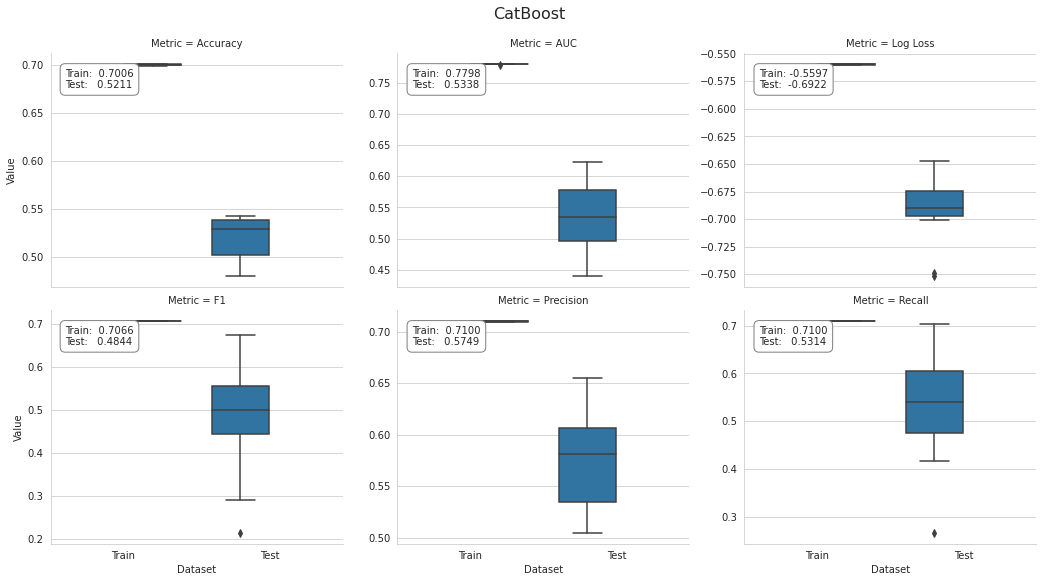

In [94]:
plot_result(cat_gpu_result, model='CatBoost', fname=f'figures/{algo}_cv_result')

## Compare Results

In [95]:
results = {'Baseline': dummy_result,
           'Random Forest': rf_result,
           'AdaBoost': ada_result,
           'Gradient Booster': gb_result,
           'XGBoost': xbg_result,
           'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result,
           'CatBoost': cat_result,
           'CatBoost GPU': cat_gpu_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']
                                       ).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
Gradient Booster,0.536793,0.505439,0.454815,-0.696830,0.564898,0.555223
AdaBoost,0.536026,0.504680,0.462678,-0.692850,0.542952,0.571182
CatBoost,0.535570,0.530186,0.539839,-0.690083,0.579023,0.551868
CatBoost GPU,0.533815,0.521131,0.484439,-0.692181,0.574918,0.531375
LightGBM Factors,0.531961,0.507112,0.423222,-0.723949,0.555119,0.505033
LightGBM Dummies,0.531726,0.512568,0.432572,-0.704388,0.563982,0.503945
Random Forest,0.527617,0.517378,0.509683,-0.692599,0.567070,0.544931
XGBoost,0.523467,0.501340,0.392318,-0.705452,0.503652,0.496645
Baseline,0.503582,0.503582,0.516424,-17.070718,0.548116,0.505758


In [96]:
algo_dict = dict(zip(['dummy_clf', 'random_forest', 'adaboost', 'sklearn_gbm', 
                      'xgboost', 'lgb_factors', 'lgb_dummies', 'catboost', 'catboost_gpu'],
                     ['Baseline', 'Random Forest', 'AdaBoost', 'Gradient Booster', 
                      'XGBoost', 'LightGBM Dummies', 'LightGBM Factors', 'CatBoost', 'CatBoost GPU']))

In [97]:
print(run_time)

{'dummy_clf': 3.888885736465454, 'random_forest': 534.8454701900482, 'adaboost': 394.19925689697266, 'sklearn_gbm': 54.56829643249512, 'xgboost': 385.2668263912201, 'lgb_factors': 57.30852460861206, 'lgb_dummies': 49.59844732284546, 'catboost': 1950.4419770240784, 'catboost_gpu': 642.1219692230225}


In [98]:
r = pd.Series(run_time).to_frame('t')
r.index = r.index.to_series().map(algo_dict)
r.to_csv(results_path / 'runtime.csv')

In [99]:
# r = pd.read_csv(results_path / 'runtime.csv', index_col=0)

In [100]:
auc = pd.concat([v.loc[(v.Dataset=='Test') & (v.Metric=='AUC'), 'Value'].to_frame('AUC').assign(Model=k) 
                 for k, v in results.items()])
# auc = auc[auc.Model != 'Baseline']

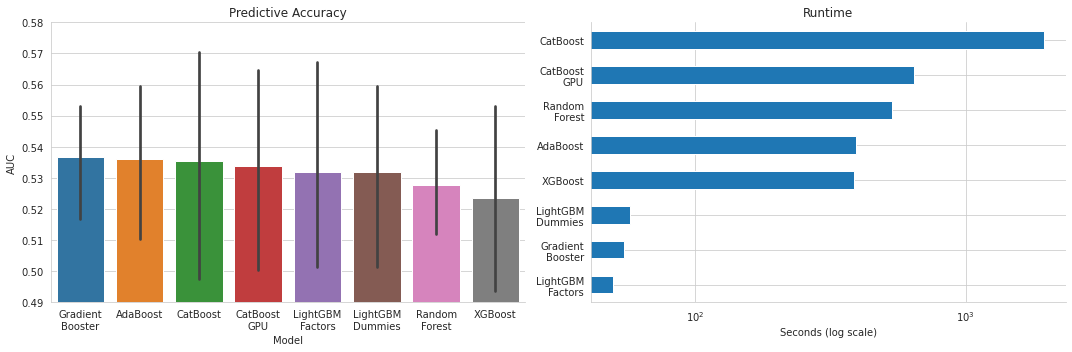

In [101]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2)
idx = df.T.drop('Baseline')['AUC'].sort_values(ascending=False).index
sns.barplot(x='Model', y='AUC',
            data=auc,
            order=idx, ax=axes[0])
axes[0].set_xticklabels([c.replace(' ', '\n') for c in idx])
axes[0].set_ylim(.49, .58)
axes[0].set_title('Predictive Accuracy')

(r.drop('Baseline').sort_values('t').rename(index=lambda x: x.replace(' ', '\n'))
 .plot.barh(title='Runtime', ax=axes[1], logx=True, legend=False))
axes[1].set_xlabel('Seconds (log scale)')
sns.despine()
fig.tight_layout()